<a href="https://colab.research.google.com/github/kaitken17/understand_nlp/blob/master/sythetic_analysis_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
!pip install tensorflow_text

In [44]:
import functools

import jax
import jax.numpy as jnp
from jax.experimental import optimizers, stax

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from tqdm.notebook import tqdm

import os
import time
import pickle

from sklearn.decomposition import PCA
from scipy.special import softmax

import sys
sys.path.append('/content/drive/My Drive/ml_research/fixedpoints_nlp/reverse-engineering-neural-networks')

import renn

In [45]:
# Skips any tests and just runs function definitions
run_tests = False

state_colors = ['firebrick', 'darkgreen', 'blue', 'darkorange', 'm', 'deeppink', 'r', 'k', 'gray', 'g', 'b']
state_colors_light = ['salmon', 'limegreen', 'cornflowerblue', 'bisque', 'plum', 'pink', 'tomato']

# Synthetic Data

#### Function Defs

In [46]:
def generateInputWordBank(toy_params):
  """ Creates the word bank based on various inputs.
  words contains words that can be added to phrase
  all_words contains all possible words including special character words """
  base_words = toy_params['base_words']
  words = ['I'+str(i) for i in range(base_words)]

  all_words = words.copy()

  if toy_params['var_length']:
    all_words.append('<pad>')
  
  all_words_pp = all_words.copy()
  if toy_params['pad_dim']: 
    # Adds additional words that aren't ever used to input to increase effective embedding dimension
    if len(all_words) < toy_params['emb_dim']:
      all_words.extend(['<in_dim_pad>' for _ in range(toy_params['emb_dim'] - len(all_words))])

  return all_words, all_words_pp, words

def make_toy_phrase(toy_params):
  """ Creates a single toy phrase from the word bank """
  
  if toy_params['var_length']:
    phrase_length = np.random.randint(toy_params['min_phrase_len'], toy_params['phrase_length'])
  else:
    phrase_length = toy_params['phrase_length']
  in_words = toy_params['phrase_words'] # only generates phrases from words that can be in a phrase
  phrase = []
  n_words = len(in_words)

  for idx in range(phrase_length):
    next_word = False
    while not next_word: # This infrastructure saved for implementing rules later
      next_word = False
      word_idx = np.random.randint(n_words)
      next_word = True
    
    phrase.append(in_words[word_idx])

  if toy_params['var_length']: # Adds padding if variable length
    phrase.extend(['<pad>' for _ in range(toy_params['phrase_length'] - phrase_length)])

  return phrase

def generateOutputWordBank(toy_params):
  """ Generates the output word bank and translation dictionary which is used to translate phrases """
  base_words = toy_params['base_words']
  if 'rules' not in toy_params: toy_params['rules'] = [] # Defaults

  output_words = []
  base_word_vals = {}
  for i in range(base_words):
    base_word_vals['I'+str(i)] = 'O'+str(i)
    output_words.append('O'+str(i))
  if 'prev0' in toy_params['rules']:
    output_words.append('O0P')

  if toy_params['var_length']: 
    output_words.append('<pad>')
    base_word_vals['<pad>'] = '<pad>' # amount of padding in input = amount in output

  output_words_pp = output_words.copy()
  if toy_params['pad_dim']: 
    # Adds additional words that aren't ever used to output to increase effective embedding dimension
    if len(output_words) < toy_params['emb_dim']:
      output_words.extend(['<out_dim_pad>' for _ in range(toy_params['emb_dim'] - len(output_words))])

  return output_words, output_words_pp, base_word_vals

def translate_toy_phrase(toy_phrase, toy_params):
  """ Evaluates a single toy phrase and returns another phrase """
  base_words = toy_params['base_words']
  translations = toy_params['translations']
  phrase_length = len(toy_phrase)

  out_phrase = []

  for idx in range(phrase_length):
    word_found = False
    # Various rule checks
    if 'prev0' in toy_params['rules'] and idx > 1:
      if toy_phrase[idx] == 'I0' and toy_phrase[idx-1] == 'I0':
        word_found = True
        out_phrase.append('O0P')
    
    # Regular translation
    if not word_found and toy_phrase[idx] in list(translations.keys()):
      out_phrase.append(translations[toy_phrase[idx]])

  return out_phrase

def wordToIndex(word, word_bank):
  """ Converts a word into corresponding index in words """
  return word_bank.index(word)

def wordToTensor(word, word_bank):
  """ Turn a letter into a <1 x n_words> Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  tensor[0][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def eosTensor(word_bank):
  """ Returns <1 x n_words> EoS Tensor """
  n_words = len(word_bank)
  tensor = np.zeros((1, n_words))
  return np.array(tensor)

def phraseToTensor(phrase, word_bank):
  """ Turn a phrase into a <phrase_length x n_words> (an array of one-hot letter vectors) 
  Works for both inputs phrases and output phrases """
  n_words = len(word_bank)
  tensor = np.zeros((len(phrase), n_words))
  for wi, word in enumerate(phrase):
      tensor[wi][wordToIndex(word, word_bank)] = 1
  return np.array(tensor)

def tensorToPhrase(tensor, word_bank):
  """ Turn an array of one-hot letter vectors into a phrase """
  phrase = []
  for idx in range(tensor.shape[0]):
      hot_idx = np.argmax(tensor[idx])
      phrase.append(word_bank[hot_idx])
  return phrase

def randomTrainingExample(toy_params):
  """
  Generates a random training example consisting of nput phrase and sentiment and corresponding tensors

  Returns:
  sentiment_tensor: time x input dim (word bank size)
  sentiment_tensor: 1 x output dim (sentiment bank size)
  target_mask:

  """
  # Unpacks toy_params (with defaults)
  phrase_length = toy_params['phrase_length']
  in_words = toy_params['in_words']
  out_words = toy_params['out_words']
  loss_type = toy_params['loss_type'] if 'loss_type' in toy_params else 'XE'

  in_phrase = make_toy_phrase(toy_params)
  in_phrase_tensor = phraseToTensor(in_phrase, toy_params['in_words'])
  out_phrase = translate_toy_phrase(in_phrase, toy_params)
  out_phrase_tensor = phraseToTensor(out_phrase, toy_params['out_words'])

  # Determines phrase length (+1 for EoS character, -1 because index)
  in_phrase_length = in_phrase.index('<pad>') if toy_params['var_length'] else toy_params['phrase_length']-1
  out_phrase_length = out_phrase.index('<pad>') if toy_params['var_length'] else toy_params['phrase_length']-1
  in_target_mask = np.array(in_phrase_length, dtype=int) # When target is defined.
  out_target_mask = np.array(in_phrase_length, dtype=int) # When target is defined.
  
  return out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, out_target_mask, in_target_mask

#### Toy Data Tests

In [47]:
# Various tests/confirmations of phrase generation
if run_tests:

  toy_params = {
    'phrase_length': 5,
    'var_length': True,
    'min_phrase_len': 2,
    'base_words': 3,
    'loss_type': 'XE',
    'rules': [], #prev0
    'pad_dim': True,
    'emb_dim': 20,
  }

  toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = generateOutputWordBank(toy_params)

  print('Input words:', toy_params['in_words'])
  print('Input phrase words:', toy_params['phrase_words'])
  print('Output words:', toy_params['out_words'])
  print('Translation dic:', toy_params['translations'])

  # Makes five phrases and reports scores
  print('Three phrases and translations:')
  for i in range(3):
    toy_phrase = make_toy_phrase(toy_params)
    print('Input phrase:', toy_phrase)
    out_phrase = translate_toy_phrase(toy_phrase, toy_params)
    print('Output phrase:', out_phrase)

  out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, target_mask = randomTrainingExample(toy_params)
  print('Input phrase:', in_phrase)
  print('Input phrase tensor:', in_phrase_tensor)
  print('Output phrase:', out_phrase)
  print('Output phrase tensor:', out_phrase_tensor)
  print('Target mask:', target_mask)

# SCAN Dataset

In [48]:
def read_and_split_file(file_name: str) -> list:
  text_data = list()
  current_file = os.path.abspath(file_name)
  if os.path.exists(current_file):
    open_file = open(current_file, 'r', encoding="latin-1")
    text_data = open_file.read().split('\n')
    text_data = list(filter(None, text_data))
  return text_data

# path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks.txt'
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/tasks_mod1.txt'
text_data = read_and_split_file(path)

In [49]:
def read_and_filter_scan(text_data, input_words):
  """ Reads in phrases from text_data and filters phrases to keep only those that have words in input_words """
  in_phrases = []
  out_phrases = []

  for i in range(len(text_data)): 
    in_idx = text_data[i].find('IN: ') + 4
    out_idx = text_data[i].find('OUT: ') + 5
    input = text_data[i][in_idx:out_idx-6]
    output = text_data[i][out_idx:]
    input_phrase = input.split(' ')
    output_phrase = output.split(' ')

    if all([input_phrase[j] in input_words for j in range(len(input_phrase))]):
      in_phrases.append(input_phrase)
      out_phrases.append(output_phrase)
    
  return in_phrases, out_phrases

def pad_and_tensor_scan(in_phrases, out_phrases, scan_params):
  """ Pads a set of scan in/out phrases and converts to tensor outputs (either raw or extended sets) """

  if '<pad>' not in scan_params['in_words']:
    scan_params['in_words'].append('<pad>')
    scan_params['out_words'].append('<pad>')
  scan_params['in_words_pp'] = scan_params['in_words'].copy()
  scan_params['out_words_pp'] = scan_params['out_words'].copy()
  if scan_params['pad_dim']: 
    # Adds additional words that aren't ever used to input and output words to increase effective embedding dimension
    if len(scan_params['in_words']) < scan_params['emb_dim']:
      scan_params['in_words'].extend(['<in_dim_pad>' for _ in range(scan_params['emb_dim'] - len(scan_params['in_words']))])
    if len(scan_params['out_words']) < scan_params['emb_dim']:
      scan_params['out_words'].extend(['<out_dim_pad>' for _ in range(scan_params['emb_dim'] - len(scan_params['out_words']))])

  
  max_in = max(list(map(len, in_phrases))) + 1 # Plus 1 because adding a single <pad> to longest phrase
  max_out = max(list(map(len, out_phrases))) + 1

  scan_inputs_np = np.zeros((len(in_phrases), max_in, len(scan_params['in_words'])))
  scan_targets_np = np.zeros((len(out_phrases), max_out, len(scan_params['out_words'])))
  scan_target_masks_np = np.zeros((len(in_phrases),))
  scan_input_masks_np = np.zeros((len(in_phrases),))

  for i in range(len(in_phrases)):
    scan_input_masks_np[i] = len(in_phrases[i])
    scan_target_masks_np[i] = len(out_phrases[i])
    in_phrases[i].extend(['<pad>' for _ in range(max_in - len(in_phrases[i]))])
    out_phrases[i].extend(['<pad>' for _ in range(max_out - len(out_phrases[i]))])

    scan_inputs_np[i] = phraseToTensor(in_phrases[i], scan_params['in_words'])
    scan_targets_np[i] = phraseToTensor(out_phrases[i], scan_params['out_words'])

    # print('Input:', input_phrase)
    # print('Input tensor:', in_phrase_tensor)
    # print('Output:', output_phrase)
    # print('Output tensor:', out_phrase_tensor

  scan_data_np = {
    'inputs': scan_inputs_np,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': scan_targets_np, # Sentiment tensors: dataset_size x phrase_len x out_dim
    'in_index': scan_input_masks_np, # Target mask: phrase_len
    'out_index': scan_target_masks_np, # Target mask: phrase_len
  }

  return scan_data_np, scan_params

def extend_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=1,  plot_lens=False):
  """ increases the length of SCAN phrases by appending them to one another"""
  min_len = scan_params['min_out_len']
  max_len = scan_params['max_out_len']
  
  new_ins = []
  new_outs = []

  raw_phrases = len(raw_in_phrases)
  if '<.>' not in scan_params['in_words'] and scan_params['periods']:
    scan_params['in_words'].append('<.>')
    scan_params['out_words'].append('<.>')

  while len(new_ins) < trials:
    new_in = []
    new_out = []
    while len(new_out) < min_len:
      rand_idx = np.random.randint(raw_phrases)
      if len(new_out) + len(raw_out_phrases[rand_idx]) + 1 > max_len:
        continue
      new_in.extend(raw_in_phrases[rand_idx])
      new_out.extend(raw_out_phrases[rand_idx])

      if scan_params['periods']:
        new_in.append('<.>')
        new_out.append('<.>')

    # Does not accept new phrase if greater than maximum input length (eliminates some weird outliers)
    if len(new_in) <= scan_params['max_in_len']:
      new_ins.append(new_in)
      new_outs.append(new_out)
    # else:
    #   print('Input too long: rejected')

  if plot_lens:
    in_lens = list(map(len, new_ins))
    out_lens = list(map(len, new_outs))

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist(in_lens)
    ax2.hist(out_lens)
    ax1.set_xlabel('Input lengths')
    ax2.set_xlabel('Output lengths')
  
  return new_ins, new_outs, scan_params

def generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=1):
  """ Function used to generate scan phrases (used for extended and normal) dataset """
  start_time = time.time()
  if scan_params['extend_scan']: # extends scan phrases
    in_phrases, out_phrases, scan_params = extend_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=trials, 
                                                       plot_lens=scan_params['plot_lens'])
  else:
    in_phrases = raw_in_phrases
    out_phrases = raw_out_phrases

  # Pads a set of scan and converts to tensor outputs
  scan_data_np, scan_params = pad_and_tensor_scan(in_phrases, out_phrases, scan_params)

  scan_data = {
    'inputs': jnp.asarray(scan_data_np['inputs']),  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': jnp.asarray(scan_data_np['labels']), # Sentiment tensors: dataset_size x phrase_len x out_dim
    'in_index': jnp.asarray(scan_data_np['in_index'], dtype=jnp.int32), # Target mask: phrase_len
    'out_index': jnp.asarray(scan_data_np['out_index'], dtype=jnp.int32), # Target mask: phrase_len
  }

  print('SCAN data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  return scan_data, scan_params

def filter_out_left_twice(raw_in_phrases, raw_out_phrases, scan_params):
  print('Filtering out left twice occurences.')

  new_in_phrases = []
  new_out_phrases = []

  for phrase, out_phrase in zip(raw_in_phrases, raw_out_phrases):
    phrase_idxs = np.array([scan_params['in_words'].index(word) for word in phrase])

    left_locs = phrase_idxs == scan_params['in_words'].index('left')
    twice_locs = phrase_idxs == scan_params['in_words'].index('twice')

    if not any(np.logical_and(left_locs[:-1], twice_locs[1:])):
      new_in_phrases.append(phrase)
      new_out_phrases.append(out_phrase)

  print('Before phrases:', len(raw_in_phrases))
  print('After phrases:', len(new_in_phrases))

  return new_in_phrases, new_out_phrases

#### Set SCAN params

Filtering out left twice occurences.
Before phrases: 156
After phrases: 90
Kept 90/20916 phrases. // Max in: 5 // Max out: 4 (pre-pad)
SCAN data generated in: 0.17 sec.
Input words: ['run', 'walk', 'jump', 'left', 'and', 'twice', '<.>', '<pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>', '<in_dim_pad>']
Output words: ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT', '<.>', '<pad>', '<out_d

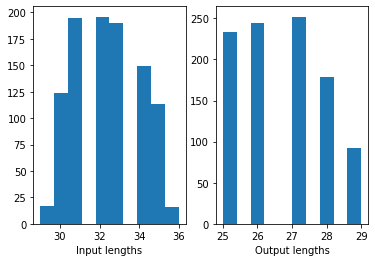

In [50]:
# Filter raw SCAN dataset and set toy parameters

# all_in_words = ['run', 'walk', 'look', 'jump', 'exercise', 'left', 'right', 'twice', 'opposite', 'thrice', 'turn', 'around', 'and', 'after']
# all_out_words = ['I_RUN', 'I_WALK', 'I_LOOK', 'I_JUMP', 'I_EXER1', 'I_EXER2', 'I_TURN_LEFT', 'I_TURN_RIGHT']

scan_params = {
  'in_words': ['run', 'walk', 'jump', 'left', 'and', 'twice'], 
  'out_words': ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT'],
  'extend_scan': True,
  'min_out_len': 25,
  'max_out_len': 30,
  'max_in_len': 37,
  'trials': 1000,
  'plot_lens': True,
  'periods': True,
  'pad_dim': True,
  'emb_dim': 50,
}

# Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
raw_in_phrases, raw_out_phrases = read_and_filter_scan(text_data, scan_params['in_words'])

# Filters out `left twice' occurences
raw_in_phrases, raw_out_phrases = filter_out_left_twice(raw_in_phrases, raw_out_phrases, scan_params)

max_in = max(list(map(len, raw_in_phrases)))
max_out = max(list(map(len, raw_out_phrases)))

print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

scan_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])
print('Input words:', scan_params['in_words'])
print('Output words:', scan_params['out_words'])

max_in = scan_data['inputs'].shape[1]
max_out = scan_data['labels'].shape[1]
print(f'Max in: {max_in} // Max out: {max_out} (post-pad)')

print('Scan input shape:', scan_data['inputs'].shape)
print('Scan labels shape:', scan_data['labels'].shape)
print('Scan in indexs shape:', scan_data['in_index'].shape)
print('Scan out indexs shape:', scan_data['out_index'].shape)

scan_params['plot_lens'] = False

# Sets toy parameters to match SCAN data so same code can be used below
toy_params = {
  'phrase_length': scan_params['max_in_len'],
  'var_length': True,
  'loss_type': 'XE',
  'in_words': scan_params['in_words'],
  'out_words': scan_params['out_words'],
  'scan_params': scan_params,
  'in_words_pp': scan_params['in_words_pp'],
  'out_words_pp': scan_params['out_words_pp'],
}


In [51]:
if run_tests:

  scan_params = {
    'in_words': ['run', 'walk', 'jump',],
    'out_words': ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT', 'I_TURN_RIGHT'],
    'extend_scan': True,
    'min_out_len': 25,
    'max_out_len': 30,
    'max_in_len': 31,
    'trials': 100,
    'plot_lens': True,
    'periods': False,
  }

  # Reads in phrases from text_data and filters phrases to keep only those that have words in input_words
  raw_in_phrases, raw_out_phrases = read_and_filter_scan(text_data, scan_params['in_words'])

  max_in = max(list(map(len, raw_in_phrases)))
  max_out = max(list(map(len, raw_out_phrases)))

  print(f'Kept {len(raw_in_phrases)}/{len(text_data)} phrases. // Max in: {max_in} // Max out: {max_out} (pre-pad)')

  scan_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=scan_params['trials'])

  max_in = scan_data['inputs'].shape[1]
  max_out = scan_data['labels'].shape[1]
  print('Total phrases:', scan_data['inputs'].shape[0], f'// Max in: {max_in} // Max out: {max_out} (post-pad)')

In [52]:
idx = 12
print('Input:', tensorToPhrase(scan_data['inputs'][idx], scan_params['in_words']))
print('Input tensor shape:', scan_data['inputs'][idx].shape)
print('Out Index:', scan_data['out_index'][idx])
print('Output:', tensorToPhrase(scan_data['labels'][idx], scan_params['out_words']))
print('Output tensor shape:', scan_data['labels'][idx].shape)

print('Input tensor:', scan_data['inputs'][idx][:10])
print('Label tensor:', scan_data['labels'][idx][:10])

Input: ['walk', 'left', 'and', 'run', 'left', '<.>', 'jump', 'left', 'and', 'walk', 'left', '<.>', 'jump', 'and', 'run', 'twice', '<.>', 'jump', 'left', '<.>', 'jump', 'twice', 'and', 'jump', 'left', '<.>', 'walk', 'left', 'and', 'run', 'left', '<.>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
Input tensor shape: (37, 50)
Out Index: 27
Output: ['I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_RUN', '<.>', 'I_TURN_LEFT', 'I_JUMP', 'I_TURN_LEFT', 'I_WALK', '<.>', 'I_JUMP', 'I_RUN', 'I_RUN', '<.>', 'I_TURN_LEFT', 'I_JUMP', '<.>', 'I_JUMP', 'I_JUMP', 'I_TURN_LEFT', 'I_JUMP', '<.>', 'I_TURN_LEFT', 'I_WALK', 'I_TURN_LEFT', 'I_RUN', '<.>', '<pad>', '<pad>', '<pad>']
Output tensor shape: (30, 50)
Input tensor: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Train and Build Network

In [53]:
def build_rnn(rnn_specs):
  """Builds a single layer RNN (Vanilla/GRU/LSTM/UGRNN with readout)"""

  vocab_size = rnn_specs['input_size']

  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']: # Attention mechanisms double hidden size
    num_units = 2*rnn_specs['hidden_size']
    print('Doubling hidden units for attention.')
  else:
    num_units = rnn_specs['hidden_size']
  num_outputs = rnn_specs['output_size']

  def build_cell_rnn(units):
    if rnn_specs['cell_type'] == 'Vanilla':
      cell = renn.rnn.cells.VanillaRNN(units)
    elif rnn_specs['cell_type'] == 'GRU':
      cell = renn.rnn.cells.GRU(units)
    elif rnn_specs['cell_type'] == 'LSTM':
      cell = renn.rnn.cells.LSTM(units)
    elif rnn_specs['cell_type'] == 'UGRNN':
      cell = renn.rnn.cells.UGRNN(units)
    return cell

  def build_readout():
    if rnn_specs['ro_bias']:
      readout_init, readout_apply = stax.Dense(num_outputs)
    else:
      readout_init, readout_apply = Dense_nobias(num_outputs)
    return readout_init, readout_apply

  def build_attention():
    phrase_length = rnn_specs['phrase_length']
    attention_init, attention_apply = attention(phrase_length)  
    return attention_init, attention_apply  

  def init_fun(prng_key, enc_input_shape, dec_input_shape):
    """Initializes the network (the embedding and the RNN cell)."""
    k0, k1, k2, k3 = jax.random.split(prng_key, 4)
    output_shape, rnn_params = cell.init(k0, enc_input_shape[1:])
    
    if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']: # Readout size reduced by 1/2 since only uses first half of hidden
      output_shape = output_shape[:-1] + (int(1/2*output_shape[-1]),)
    # Readout size is doubled since concatanation of hidden and context (only if recurrent part is used)
    elif rnn_specs['arch'] in ['enc_dec_atth'] and not rnn_specs['zero_context'] and not rnn_specs['zero_attention']:
      output_shape = output_shape[:-1] + (int(2*output_shape[-1]),)
      print('Using an output shape of:', output_shape)

    # We explicitly add the batch dimension back in.
    # (This is because we only applied `vmap` to the rnn_apply function above)
    batch_output_shape = (enc_input_shape[0],) + output_shape

    _, readout_params = readout_init(k1, output_shape)
    if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
      _, rnn_params_dec = cell_dec.init(k2, dec_input_shape[1:])
      return batch_output_shape, (rnn_params, rnn_params_dec, readout_params)
    elif rnn_specs['arch'] in ['enc_dec_att',]:
      _, rnn_params_dec = cell_dec.init(k2, dec_input_shape[1:])
      _, att_params = attention_init(k3, (phrase_length,))
      return batch_output_shape, (rnn_params, rnn_params_dec, att_params, readout_params)
    else:
      return batch_output_shape, (rnn_params, readout_params)

  def apply_fun_one_to_one(params, inputs, in_masks):
    """Applies the RNN in the usual way."""
    # Destructure parameter tuple.
    rnn_params, readout_params = params

    # [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])

    batch_apply = functools.partial(cell.batch_apply, rnn_params)
    
    all_logits = renn.rnn.unroll.unroll_rnn(initial_states, inputs, batch_apply, functools.partial(readout_apply, readout_params))
    return all_logits

  def apply_fun_enc_dec(params, inputs, in_masks):
    """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder"""
    # Destructure parameter tuple.
    rnn_params_enc, rnn_params_dec, readout_params = params

    # Only gets initial state from encoder, [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

    batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
    batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

    rnn_apply = batch_apply_enc, batch_apply_dec
    
    all_logits = encode_decode(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params))
    return all_logits

  def apply_fun_enc_dec_att(params, inputs, in_masks, return_att_matrix=False, step=0):
    """Applies the RNN using encoder-decoder structure with different cells for both encoder and decoder and with attention mechanism"""
    
    if rnn_specs['arch'] == 'enc_dec_short':
      rnn_params_enc, rnn_params_dec, readout_params = params
      # Builds attend matrix based on shorts
      att_params = jnp.diag(jnp.asarray([int(i in rnn_specs['shorts']) for i in range(phrase_length)]))
    elif rnn_specs['arch'] == 'enc_dec_att':
      rnn_params_enc, rnn_params_dec, att_params, readout_params = params
    elif rnn_specs['arch'] == 'enc_dec_atth':
      rnn_params_enc, rnn_params_dec, readout_params = params

    # Only gets initial state from encoder, [batch, len, dim]
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])

    batch_apply_enc = functools.partial(cell.batch_apply, rnn_params_enc)
    batch_apply_dec = functools.partial(cell_dec.batch_apply, rnn_params_dec)

    rnn_apply = batch_apply_enc, batch_apply_dec
    # Softmax across dimension multiplying encoder sequence

    if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']:
      att_apply = functools.partial(attention_apply, jax.nn.softmax(att_params, axis=0))
      outs = encode_decode_attn(initial_states, inputs, rnn_apply, att_apply,
                                      functools.partial(readout_apply, readout_params), zero_context=rnn_specs['zero_context'])
    elif rnn_specs['arch'] in ['enc_dec_atth']:
      dec_seq_size = (inputs.shape[0], rnn_specs['out_len'], len(toy_params['out_words'])) # (batch size, phrase len, output word size)
      outs = encode_decode_attnh(initial_states, inputs, in_masks, rnn_apply, functools.partial(readout_apply, readout_params), 
                                 rnn_specs=rnn_specs, variable_len=toy_params['var_length'], step=step,
                                 dec_seq_size=dec_seq_size, return_att_matrix=return_att_matrix)
    if return_att_matrix:
      # Unpacks outs
      all_logits, att_matrix = outs
      return all_logits, att_matrix
    else:
      all_logits = outs
      return all_logits

  def mask_fun(sequences, last_index):
    """Selects the last valid timestep from a batch of padded sequences."""
    # last_index.shape = (batch_size, phrase_length)
    last_index = last_index[:, :, jnp.newaxis]
    # sequences.shape = (batch_size, phrase_length, vocab_size)
    return jnp.take_along_axis(sequences, last_index, axis=1)

  def mask_sequences(sequences, last_index):
    """Set positions beyond the length of each sequence to 0. For sequences of shape (batch_size, seq_len, vocab_size)"""
    # sequences.shape = (batch_size, seq_length, vocab_size)
    # last_index.shape = (batch_size)
    mask = last_index[:, jnp.newaxis] >= jnp.arange(sequences.shape[1])
    return sequences * jnp.repeat(mask[:,:,jnp.newaxis], sequences.shape[-1], axis=2)

  def mask_sequences_one(sequences, last_index):
    """Set positions beyond the length of each sequence to 0. For sequences of shape (batch_size, seq_len)"""
    # sequences.shape = (batch_size, seq_length)
    # last_index.shape = (batch_size)
    mask = last_index[:, jnp.newaxis] >= jnp.arange(sequences.shape[1])
    return sequences * mask

  def sigmoid_xent_with_logits(logits, labels):
    return jnp.maximum(logits, 0) - logits * labels + \
        jnp.log(1 + jnp.exp(-jnp.abs(logits)))

  def xe_loss_fn(logits, labels, lengths):
    """
    Contains both log softmax and negative log liklihood loss
    """
    # Shifts maximum to zero
    shifted = logits - jax.lax.stop_gradient(logits.max(axis=-1, keepdims=True))
    log_probs = shifted - jnp.log(jnp.sum(jnp.exp(shifted), axis=-1, keepdims=True))

    labels_max = jnp.argmax(labels, axis=2)
    
    logliklihood = jnp.take_along_axis(log_probs, jnp.expand_dims(labels_max, axis=2), axis=2)
    
    # Masks the cross entropy loss
    xe_loss = -1 * np.mean(mask_sequences_one(jnp.squeeze(logliklihood), lengths))

    return xe_loss

  def loss_fun(params, batch, step=0):
    """Cross-entropy loss function."""
    all_logits = apply_fun(params, batch['inputs'], batch['in_index'], step=step)
    # logits = mask_sequences(all_logits, batch['out_index'])
    # labels = mask_sequences(batch['labels'], batch['out_index'])
    flatten = lambda params: jax.flatten_util.ravel_pytree(params)[0]
    l2_loss = train_params['l2reg'] * np.sum(flatten(params)**2)
    
    # xe_loss = xe_loss_fn(logits, labels)
    xe_loss = xe_loss_fn(all_logits, batch['labels'], batch['out_index'])

    loss = l2_loss + xe_loss
    # Average over the batch
    return loss

  @jax.jit
  def accuracy_fun(params, batch):
    all_logits = apply_fun(params, batch['inputs'], batch['in_index'])

    logits = mask_sequences(all_logits, batch['out_index'])
    labels = mask_sequences(batch['labels'], batch['out_index'])
    
    predictions = jnp.argmax(logits, axis=2).astype(jnp.int32)
    labels_max = jnp.argmax(labels, axis=2).astype(jnp.int32)
    # Returns both accs for entire phrase and individual words
    return np.all(labels_max == predictions, axis=1), labels_max == predictions

  # Build the RNN cell.
  cell = build_cell_rnn(num_units)
  readout_init, readout_apply = build_readout()
  
  if rnn_specs['arch'] == 'enc_dec':
    cell_dec = build_cell_rnn(num_units) # decoder cell
    apply_fun = apply_fun_enc_dec
  elif rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att']:
    cell_dec = build_cell_rnn(num_units) # decoder cell can take shorted input now
    attention_init, attention_apply = build_attention() # Uses attention with fixed shorts or learnable parameters
    apply_fun = apply_fun_enc_dec_att
  elif rnn_specs['arch'] in ['enc_dec_atth']:
    cell_dec = build_cell_rnn(num_units)
    apply_fun = apply_fun_enc_dec_att
  elif rnn_specs['arch'] == 'enc_dec_one':
    apply_fun = apply_fun_enc_dec_one
  elif rnn_specs['arch'] == 'one_to_one':
    apply_fun = apply_fun_one_to_one
  else:
    raise ValueError('Rnn arch not recognized.')
    
  return init_fun, apply_fun, mask_sequences, loss_fun, accuracy_fun

def build_optimizer_step(optimizer, initial_params, loss_fun, gradient_clip=None):
  """Builds training step function."""

  # Destructure the optimizer triple.
  init_opt, update_opt, get_params = optimizer
  opt_state = init_opt(initial_params)

  @jax.jit
  def optimizer_step_noclip(current_step, state, batch):
    """Takes a single optimization step."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun, argnums=0)(p, batch, current_step)
    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss

  @jax.jit
  def optimizer_step_clip(current_step, state, batch):
    """Takes a single optimization step with clipped gradients."""
    p = get_params(state)
    loss, gradients = jax.value_and_grad(loss_fun, argnums=0)(p, batch, current_step)
    
    gradients = optimizers.clip_grads(gradients, gradient_clip)

    new_state = update_opt(current_step, gradients, state)
    return current_step + 1, new_state, loss    
  
  if gradient_clip is None:
    return opt_state, optimizer_step_noclip
  else:
    return opt_state, optimizer_step_clip

def Dense_nobias(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for a dense (fully-connected) layer without bias."""
  def init_fun(rng, input_shape):
    # input shape = (seq_length, hidden_dims)
    # output shape = (seq_length, out_dim)
    output_shape = input_shape[:-1] + (out_dim,)
    k1, _ = jax.random.split(rng)
    W = W_init(k1, (input_shape[-1], out_dim))
    return output_shape, (W)
  def apply_fun(params, inputs, **kwargs):
    W = params
    return jnp.dot(inputs, W)
  return init_fun, apply_fun

def attention(out_dim, W_init=jax.nn.initializers.glorot_normal()):
  """Layer constructor function for an attention matrix."""
  def init_fun(rng, input_shape):
    # input shape = (# encoders,)
    # output shape = (# decoders,)
    output_shape = (out_dim,)
    k1, _ = jax.random.split(rng)
    att_mat = W_init(k1, (input_shape[0], out_dim))
    return output_shape, (att_mat)
  def apply_fun(params, inputs, **kwargs):
    att_mat = params
    return jnp.dot(inputs, att_mat)
  return init_fun, apply_fun

#### Synthetic/SCAN Training Functions

In [54]:
# Synthetic/scan data functions

def generate_data(dataset_size, toy_params, rnn_specs):
  """
  Generate training data in numpy and then converts to JAX arrays
  """

  out_size = rnn_specs['output_size']

  syn_out_phrases = []
  syn_in_phrases = []
  syn_targets_np = np.zeros((dataset_size, toy_params['phrase_length'], out_size))
  syn_inputs_np = np.zeros((dataset_size, toy_params['phrase_length'], len(toy_params['in_words'])))
  # syn_target_masks_np = []
  syn_target_masks_np = np.zeros((dataset_size,))
  syn_input_masks_np = np.zeros((dataset_size,))

  start_time = time.time()
  for trial in range(dataset_size):
    out_phrase, in_phrase, out_phrase_tensor, in_phrase_tensor, out_target_mask, in_target_mask = randomTrainingExample(toy_params)
    
    syn_targets_np[trial, :, :] = out_phrase_tensor
    syn_inputs_np[trial, :, :] = in_phrase_tensor
    syn_target_masks_np[trial] = out_target_mask
    syn_input_masks_np[trial] = in_target_mask
    # syn_target_masks_np.append(target_mask)

  print('Sythentic data generated in: {:0.2f} sec.'.format(time.time() - start_time))

  # Converts to JAX arrays 
  syn_target_masks = jnp.asarray(syn_target_masks_np, dtype=jnp.int32)
  # syn_target_masks =  syn_target_masks_np

  syn_data = {
    'inputs': jnp.asarray(syn_inputs_np)  ,  # Phrase tensors: dataset_size x phrase_len x in_dim
    'labels': jnp.asarray(syn_targets_np), # Sentiment tensors: dataset_size x phrase_len x out_dim
    'in_index': jnp.asarray(syn_input_masks_np, dtype=jnp.int32), # Target mask: list of integers up to phrase_len
    'out_index': jnp.asarray(syn_target_masks_np, dtype=jnp.int32), # Target mask: list of integers up to phrase_len
  }

  return syn_data

def shuffle_data(syn_data):
  """ Shuffles synthetic data for different epochs """
  dataset_size = syn_data['inputs'].shape[0]
  shuf_idxs = np.asarray(range(dataset_size), dtype=jnp.int32)
  np.random.shuffle(shuf_idxs)

  syn_data['inputs'] = syn_data['inputs'][shuf_idxs]
  syn_data['labels'] = syn_data['labels'][shuf_idxs]
  syn_data['in_index'] = syn_data['in_index'][shuf_idxs]
  syn_data['out_index'] = syn_data['out_index'][shuf_idxs]

  return syn_data

def override_data(path, save_file):
  if save_file and os.path.exists(path):
    print('File already exists at:', path)
    override = input('Override? (Y/N):')
    if override == 'Y':
      save_file = True
    else:
      save_file = False

  return save_file

def save_run_data(path, save_file, params_jax, toy_params, rnn_specs, train_params, save_loss=False, loss_data=[]):

  if save_file:
    with open(path, 'wb') as save_file:
      pickle.dump(params_jax, save_file, protocol=pickle.HIGHEST_PROTOCOL)
      pickle.dump(toy_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
      pickle.dump(rnn_specs, save_file, protocol=pickle.HIGHEST_PROTOCOL)
      pickle.dump(train_params, save_file, protocol=pickle.HIGHEST_PROTOCOL)
    print('Data Saved')
    # if save_loss:
    #   dot_idx = path.index('.')
    #   new_path = path[:dot_idx] + '_loss' + path[dot_idx:]
    #   with open(new_path, 'wb') as save_file:
    #     pickle.dump(loss_data, save_file, protocol=pickle.HIGHEST_PROTOCOL)
    #   print('Loss Data Saved')
  else:
    print('Data Not Saved')

def test_accuracy(params, test_batch):
  _phrase_accs, _accs = accuracy_fun(params, test_batch)

  return np.mean(_phrase_accs), np.mean(_accs)

def train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs):
  """ Generate sythetic and test data and train for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  num_batchs = train_params['num_batchs']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  for dataset in range(train_params['n_datasets']):
    # Generates new train/test datasets 
    syn_data = generate_data(train_set_size, toy_params, rnn_specs)
    syn_data_test = generate_data(test_set_size, toy_params, rnn_specs)

    # Sets output sequence length to length of output sequence
    rnn_specs['out_len'] = syn_data['labels'].shape[1]

    for epoch in range(train_params['epochs']):
      # Shuffles training data after first epoch
      if epoch > 0:
        print('Shuffling Data')
        syn_data = shuffle_data(syn_data)

      print('Running batches {} to {}'.format(global_step, global_step+num_batchs))
      start_time = time.time()  
      avg_loss = 0 
      for step in range(total_steps, total_steps+num_batchs):
        batch = step - total_steps 
        batch_data = {
          'inputs': syn_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # In phrase tensors: batch x phrase_len x in_dim
          'labels': syn_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Out phrase tensors: batch x phrase_len x out_dim
          'in_index': syn_data['in_index'][batch*batch_size:(batch+1)*batch_size], # In phrase mask: list of integers up to phrase_len
          'out_index': syn_data['out_index'][batch*batch_size:(batch+1)*batch_size], # Out phrase mask: list of integers up to phrase_len
        }

        global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
        train_losses.append(loss)
        avg_loss += loss

        if (global_step+1) % print_every == 0:
          phrase_acc, word_acc = test_accuracy(get_params(opt_state), syn_data_test)

          batch_time = time.time() - start_time
          step_size = decay_fun(global_step)
          s = "Step {}, step size: {:0.5f}, phrase acc {:0.4f}, word acc {:0.4f}, avg training loss {:0.4f}"
          print(s.format(global_step+1, step_size, phrase_acc, word_acc, avg_loss/print_every))
          start_time = time.time()
          avg_loss = 0
        # if (global_step+1) % 500 == 0:
        #   print('Positional Encoding:', rnn_specs['pos_enc_params']['pos_enc'])
        # if train_params['init_pos_enc'] and rnn_specs['pos_enc_params']['pos_enc'] != None: # Optional removal of positional encoding at a certain global step
        #   if global_step > train_params['remove_pos_enc_batch']:
        #     print('Removing positional encoding')
        #     rnn_specs['pos_enc_params']['pos_enc'] = None

      train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def train_on_scan_data(scan_data, opt_state, train_params, toy_params, rnn_specs):
  """ Train SCAN data (imported elsewhere) for some number of epochs"""
  
  train_set_size = train_params['train_set_size']
  test_set_size = train_params['test_set_size']
  global_step = train_params['global_step']
  total_steps = train_params['total_steps']
  train_losses = train_params['train_losses']
  decay_fun = train_params['decay_fun']
  print_every = train_params['print_every']
  batch_size = train_params['batch_size']

  scan_params = toy_params['scan_params']
  
  for dataset in range(train_params['n_datasets']):
    # Generate scan data (normal or extended, for latter doesn't use trial count)
    scan_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=train_params['train_set_size'])
    
    # max_in = scan_data['inputs'].shape[1]
    # max_out = scan_data['labels'].shape[1]
    # print(f'Max in: {max_in} // Max out: {max_out} (post-pad)')

    # print('Scan input shape:', scan_data['inputs'].shape)
    # print('Scan labels shape:', scan_data['labels'].shape)
    # print('Scan indexs shape:', scan_data['index'].shape)
    
    if scan_params['extend_scan']:  # Generates new test set for extended scan
      scan_test_data, scan_params = generate_scan(raw_in_phrases, raw_out_phrases, scan_params, trials=train_params['test_set_size'])
      num_batchs = train_params['num_batchs']
    else:
      # Handles incomplete batches
      num_batchs = int(np.floor(scan_data['inputs'].shape[0]/batch_size))
      print(f'Running {num_batchs} batches per epoch.')
      # For now, just uses full SCAN set as test set when not extending
      scan_test_data = scan_data
    # Sets output sequence length to length of output sequence
    rnn_specs['out_len'] = scan_test_data['labels'].shape[1]

    for epoch in range(train_params['epochs']):
      # Shuffles training data after first epoch
      if epoch > 0:
        scan_data = shuffle_data(scan_data)

      start_time = time.time()  
      avg_loss = 0 
      for step in range(total_steps, total_steps+num_batchs):
        batch = step - total_steps 
        batch_data = {
          'inputs': scan_data['inputs'][batch*batch_size:(batch+1)*batch_size, :, :], # In phrase tensors: batch x phrase_len x in_dim
          'labels': scan_data['labels'][batch*batch_size:(batch+1)*batch_size, :, :], # Out phrase tensors: batch x phrase_len x out_dim
          'in_index': scan_data['in_index'][batch*batch_size:(batch+1)*batch_size], # Out phrase mask: list of integers up to phrase_len
          'out_index': scan_data['out_index'][batch*batch_size:(batch+1)*batch_size], # Out phrase mask: list of integers up to phrase_len
        }

        global_step, opt_state, loss = step_fun(global_step, opt_state, batch_data)
        train_losses.append(loss)
        avg_loss += loss

        if (global_step+1) % print_every == 0:
          phrase_acc, word_acc = test_accuracy(get_params(opt_state), scan_test_data)

          batch_time = time.time() - start_time
          step_size = decay_fun(global_step)
          s = "Step {}, step size: {:0.5f}, phrase acc {:0.4f}, word acc {:0.4f}, avg training loss {:0.4f}"
          print(s.format(global_step+1, step_size, phrase_acc, word_acc, avg_loss/print_every))
          start_time = time.time()
          avg_loss = 0

      train_params['total_steps'] += num_batchs
  
  train_params['global_step'] = global_step
  train_params['train_losses'] = train_losses

  return opt_state, train_params

def default_params(train_params, toy_params, rnn_specs):
  """ Sets the defaults of many parameters if not specified"""

  if 'rules' not in toy_params: toy_params['rules'] = []
  if 'loss_type' not in toy_params: toy_params['loss_type'] = 'XE'

  if 'shorts' not in rnn_specs: rnn_specs['shorts'] = ()
  if 'cell_type' not in rnn_specs: rnn_specs['cell_type'] = 'GRU'
  if 'zero_context' not in rnn_specs: rnn_specs['zero_context'] = False
  if 'zero_decoder_inputs' not in rnn_specs: rnn_specs['zero_decoder_inputs'] = False

  if 'init_pos_enc' not in train_params: train_params['init_pos_enc'] = False
  if 'remove_pos_enc_step' not in train_params: train_params['remove_pos_enc_step'] = 0

  return train_params, toy_params, rnn_specs

#### Architecture Tests

In [108]:

#### Functions for encoder->decoder structure

def identity(x):
  """Identity function f(x) = x."""
  return x

def encode_decode(initial_states, input_sequences, rnn_update, readout=identity, return_hidden=False):

  def _step_e(state, inputs):
    """ Encoder step, output is simply hidden states """

    next_state = enc_update(inputs, state)
    outputs = identity(next_state)
    return next_state, outputs

  def _step_d(carry, null_inputs):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry

    next_state = dec_update(inputs, state)
    outputs = readout(next_state)
    
    # Convers outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state

  enc_update, dec_update = rnn_update

  # Run encoder
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_states, input_sequences)

  eos_input = jnp.zeros(input_sequences[0].shape)
  init_val = (encode_final, eos_input)

  # Run decoder
  input_seq_null = jnp.zeros(input_sequences.shape) # These inputs aren't used
  _, dec_outs = jax.lax.scan(_step_d, init_val, input_seq_null)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def encode_decode_attn(initial_states, input_sequences, rnn_update, attention_apply, readout=identity,
                       return_hidden=False, zero_context=False):
  """ 
  Encoder decoder structure which implements attention using a learnable attention layer. This 
  attention layer passes a context to the INPUT of the RNN by concatenating it with the hidden state.
  """

  hidden_state_keep = int(1/2*initial_states.shape[-1])
  # print('Keeping first {} of {} hidden'.format(hidden_state_keep, initial_states.shape[-1]))

  def _step_e(state, inputs):
    """ Encoder step, output is simply hidden states 
    state = (batch_size, 2*hidden_size)
    inputs = (batch_size, input_size)
    """
    if zero_context:
      state = jnp.zeros(state.shape)
    # Zeros second half of the hidden state
    state = jnp.concatenate([state[:,:hidden_state_keep], jnp.zeros((state.shape[0], hidden_state_keep))], axis=1)

    next_state = enc_update(inputs, state)
    outputs = identity(next_state[:,:hidden_state_keep])
    return next_state, outputs

  def _step_d(carry, seq_input):
    """ Decoder step, output goes through readouts now """
    state, inputs = carry # unpack carry
    if zero_context:
      print('Zeroing Context')
      state = jnp.zeros(state.shape)
    # Concatanate seq_input with hidden to get new hidden (for attention)
    state = jnp.concatenate([state[:,:hidden_state_keep], seq_input], axis=1)

    next_state = dec_update(inputs, state)
    # Only first half of hidden state goes to readout
    outputs = readout(next_state[:,:hidden_state_keep])
    
    # Converts outputs into one-hot vectors to pass back into network
    output_tensors = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, output_tensors
    
    if not return_hidden:
      return carry, outputs
    else:
      return carry, next_state[:,:hidden_state_keep]

  enc_update, dec_update = rnn_update

  # Run encoder
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_states, input_sequences)

  eos_input = jnp.zeros(input_sequences[0].shape)
  init_val = (encode_final, eos_input)

  # Run decoder
  input_seq_hidden = enc_outs # Hidden states of encoder (enc_seq_len, batch_size, hidden_size)

  # Multiplies hidden states by the attend matrix (with some swap axes to get everything the right shape)
  input_seq = jnp.swapaxes(attention_apply(jnp.swapaxes(input_seq_hidden, 0, 2)), 0, 2)

  _, dec_outs = jax.lax.scan(_step_d, init_val, input_seq)

  if not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def encode_decode_attnh(initial_states, input_sequences, input_masks, rnn_update, readout=identity,
                        rnn_specs={}, return_hidden=False, variable_len=False, dec_seq_size=None, 
                        return_att_matrix=False, step=0):
  """ 
  Encoder decoder structure with attention, this time using the hidden state overlap to find attention.
  Here the attention context vector gets concatenated with the decoder RNN output and passed to the readout.
  
  input_sequences: shape (batch_size, in_seq_len, input_dim)
  input_masks: shape (batch_size)
  dec_seq_size: (batch_size, out_seq_len, input_dim)
  
  """
  def switch_pos_enc(_):
    print('Removing positional encoding')
    return False
  def zero_pos_enc(input_vals):
    seq, _, amp, _ = input_vals

    # print('Removing positional encoding')
    # pos_enc = jnp.zeros(seq.shape[1:])
    # return jnp.repeat(pos_enc[jnp.newaxis, :, :], seq.shape[0], axis=0)

    pos_enc_vals = positional_encoding(input_vals)
    amp_mod = jnp.max(jnp.array((0.0, (2000 - (step - train_params['remove_pos_enc_step']))/2000)))
    return amp_mod * pos_enc_vals

  if variable_len:
    eos_idx = toy_params['in_words'].index('<pad>')

  # if train_params['init_pos_enc'] and rnn_specs['pos_enc_params']['pos_enc']: # Conditions for changing positional encoding
  #   rnn_specs['pos_enc_params']['pos_enc'] = jax.lax.cond(step > train_params['remove_pos_enc_step'], switch_pos_enc, 
  #                                                         lambda _: True, operand=None)
  
  def mask_aligns(sequences, last_index):
    """Set positions beyond the length of each sequence to large negative number. For sequences of shape (seq_len, batch_size)"""
    # sequences.shape = (seq_length, batch_size)
    # last_index.shape = (batch_size)
    alpha = 10000
    mask = (last_index[:, jnp.newaxis] >= jnp.arange(sequences.shape[0])).T
    mask_default = alpha * (mask - jnp.ones(mask.shape)) # alpha for anything that doesn't get past the mask
    return sequences * mask + mask_default

  def _step_e(carry, inputs):
    """ Encoder step, output is simply hidden states 
    state = (batch_size, 2*hidden_size)
    seq_input = (batch_size, input_size)
    """
    old_state, is_eos = carry
    seq_input, pos_enc_vals = inputs

    if zero_context: # Zeros out recurrent portion of input
      next_state = enc_update(seq_input + pos_enc_vals, jnp.zeros(old_state.shape))
    else:
      next_state = enc_update(seq_input + pos_enc_vals, old_state)
    # determines which state to carry to next input based on whether EoS has occurred
    carried_state = jnp.where(is_eos[:, np.newaxis], old_state, next_state)
    outputs = identity(carried_state)
    
    # Update is_eos (true if one-hot in eos_idx)
    if variable_len:
      is_eos = jnp.logical_or(is_eos, np.argmax(seq_input, axis=1) == eos_idx)
    
    return (carried_state, is_eos), outputs

  def _step_d(carry, pos_enc_vals):
    """ Decoder step, output goes through readouts now """
    old_state, seq_input = carry # unpack carry into hidden sate and previous input

    if zero_context: # Zeros out recurrent portion of input
      next_state = dec_update(seq_input + pos_enc_vals, jnp.zeros(old_state.shape))
    else:
      next_state = dec_update(seq_input + pos_enc_vals, old_state)

    if zero_attention: # Attention not used, only decoder output goes to readout
      outputs = readout(next_state)
    else: # Calculates attention
      # Uses the output of the decoder to calculate the attention state (can normalize by sqrt(hidden_size), similar to transformers)
      # (batch, hidden) x (seq_len, batch, hidden) -> (seq_len, batch)
      masked_aligns = mask_aligns(jnp.einsum('ij,kij->ki', next_state, input_seq_hidden), input_masks)
      attention_row = jax.nn.softmax(masked_aligns, axis=0)

      # attention_row = jax.nn.softmax(jnp.einsum('ij,kij->ki', next_state, input_seq_hidden)/np.sqrt(next_state.shape[1]), axis=0)
      # (seq_len, batch) x (seq_len, batch, hidden) -> (batch, hidden)
      attention_state = jnp.einsum('ij,ijk->jk', attention_row, input_seq_hidden)

      print('Zero context', zero_context)

      if zero_context: # Only attention state goes to readout
        outputs = readout(attention_state)
      else: # Concatenated hidden state and attention state go to readout
        outputs = readout(jnp.concatenate([next_state, attention_state], axis=1))
    
    if zero_decoder_inputs: # Just feeds zeros into decoder
      # next_seq_iznput = 1/outputs.shape[1] * jnp.ones(outputs.shape)
      next_seq_input = jnp.zeros(outputs.shape)
      next_seq_input = jax.ops.index_update(next_seq_input, jax.ops.index[:, 0], jnp.ones(outputs.shape[0]))
      # key = jax.random.PRNGKey(23232)
      # key, subkey = jax.random.split(key)
      # rand_ints = jax.random.randint(subkey, outputs.shape[0], 0, outputs.shape[1])
      # next_seq_input = jax.nn.one_hot(rand_ints, outputs.shape[1])
    else: # Converts outputs into one-hot vectors to pass to next step
      next_seq_input = jax.nn.one_hot(jnp.argmax(outputs, axis=1), outputs.shape[1])
    carry = next_state, next_seq_input
    
    if return_att_matrix:
      return carry, (outputs, attention_row)
    elif not return_hidden:
      return carry, outputs
    else:
      return carry, next_state

  pos_enc_params = rnn_specs['pos_enc_params']
  zero_context = rnn_specs['zero_context']
  zero_attention = rnn_specs['zero_attention']
  zero_decoder_inputs = rnn_specs['zero_decoder_inputs']
  
  enc_update, dec_update = rnn_update
  is_eos = jnp.zeros(input_sequences.shape[0], dtype=np.bool) # (batch_size)
  initial_carry = (initial_states, is_eos)
  
  #### Run encoder ####
  if pos_enc_params['pos_enc']:
    amp = pos_enc_params['amplitude']
    pos_enc_scale = pos_enc_params['time_scale']
    print(f'Adding pos_enc to encoder. \\ Amp: {amp} \\ Time Scale: {pos_enc_scale}')
    pos_enc_input = input_sequences, pos_enc_scale, amp, pos_enc_params['rot']
    if train_params['init_pos_enc']: # Positional encoding only at start of training)
      pos_enc_vals = jax.lax.cond(step > train_params['remove_pos_enc_step'], zero_pos_enc, positional_encoding, operand=pos_enc_input) 
    else: # Normal positional encoding
      pos_enc_vals = positional_encoding(pos_enc_input)
  else:
    pos_enc_vals = jnp.zeros(input_sequences.shape)

  pos_enc_vals = jnp.swapaxes(pos_enc_vals, 0, 1)
  input_sequences = jnp.swapaxes(input_sequences, 0, 1)
  # Keeps inputs and potential positional encoding values separate so EoS character still identifiable
  encode_final, enc_outs = jax.lax.scan(_step_e, initial_carry, (input_sequences, pos_enc_vals))

  encode_final_hs, _ = encode_final
  if dec_seq_size == None: # Assumes same dimension of output sequence as input sequence if left blank
    dec_seq_size = input_sequences.shape[:-1] + (rnn_specs['output_size'],)
  # Special character to start decoder is just average input  
  sos_input = 1/dec_seq_size[2] * jnp.ones((dec_seq_size[0], dec_seq_size[2])) # shape: (batch_size, decoder input dim)
  initial_carry = (encode_final_hs, sos_input)

  input_seq_hidden = enc_outs # Hidden states of encoder (used for attention) (enc_seq_len, batch_size, hidden_size)
  
  #### Run Decoder ####
  if pos_enc_params['pos_enc']:
    print(f'Adding pos_enc to decoder. \\ Amp: {amp} \\ Time Scale: {pos_enc_scale}')
    pos_enc_input = jnp.zeros(dec_seq_size), pos_enc_scale, amp, pos_enc_params['rot']
    if train_params['init_pos_enc']: # Positional encoding only at start of training
      pos_enc_vals = jax.lax.cond(step > train_params['remove_pos_enc_step'], zero_pos_enc, positional_encoding, operand=pos_enc_input) 
    else: # Normal positional encoding
      pos_enc_vals = positional_encoding(pos_enc_input) 
  else:
    pos_enc_vals = jnp.zeros(dec_seq_size) 
  
  pos_enc_vals = jnp.swapaxes(pos_enc_vals, 0, 1)
  _, dec_outs = jax.lax.scan(_step_d, initial_carry, pos_enc_vals)

  if return_att_matrix:
    raw_dec_outs, attn_matrix = dec_outs
    return jnp.swapaxes(raw_dec_outs, 0, 1), jnp.swapaxes(attn_matrix, 0, 2)
  elif not return_hidden:
    return jnp.swapaxes(dec_outs, 0, 1)
  else:
    full_hs = jnp.concatenate((enc_outs, dec_outs), axis=0)
    return jnp.swapaxes(full_hs, 0, 1)

def positional_encoding(input_vals):
  """ 
  Returns positional encoding values. 
  Assumes seq dimensions are (batch, seq_len, word_space) 
  """
  # Unpacks input
  seq, scale, amp, rot = input_vals

  pos_enc = jnp.zeros(seq.shape[1:])
  word_dim = seq.shape[2]

  for word_idx in range(word_dim):
    if word_idx % 2 == 0:
      # pos_enc[:, word_idx] = [amp*jnp.sin(seq_idx/(scale**(word_idx/word_dim))) for seq_idx in range(seq.shape[1])]
      pos_enc = jax.ops.index_update(pos_enc, jax.ops.index[:, word_idx], [amp*jnp.sin(seq_idx/(scale**(word_idx/word_dim))) for seq_idx in range(seq.shape[1])])
    else:
      # pos_enc[:, word_idx] = [amp*jnp.cos(seq_idx/(scale**((word_idx - 1)/word_dim))) for seq_idx in range(seq.shape[1])]
      pos_enc = jax.ops.index_update(pos_enc, jax.ops.index[:, word_idx], [amp*jnp.cos(seq_idx/(scale**((word_idx - 1)/word_dim))) for seq_idx in range(seq.shape[1])])

  if rot is None:
    rot = jnp.identity(pos_enc.shape[1])
  # Rotates positional encoding vectors (this is useful when using one-hot)
  pos_enc = jnp.matmul(pos_enc, rot)

  return jnp.repeat(pos_enc[jnp.newaxis, :, :], seq.shape[0], axis=0)

In [56]:
if run_tests:

  seed = 342343
  prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

  data_type = 'toy'

  ########## Toy data parameters ##########
  if data_type == 'toy':
    toy_params = {
      'phrase_length': 30,
      'base_words': 3,
      'var_length': True,
      'min_phrase_len': 25,
      'loss_type': 'XE',
      'pad_dim': True,
      'emb_dim': 10,
      'rules': [None,] # prev0
    }

    toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
    toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = generateOutputWordBank(toy_params)

  ########## RNN hyperparameters ##########
  rnn_specs = {
    'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
    'arch': 'enc_dec_atth',                          # Type of architecture
    'pos_enc_params': {'pos_enc': True, 'time_scale': 25, 'amplitude': 1.0}, 
    'shorts': (),
    'zero_context': False,
    'zero_attention': False,
    'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
    'hidden_size': 128,                              # Number of units in the RNN
    'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
    'ro_bias': True,                                 # Include a bias with the readout
    'ro_simplex_init': False,
    'phrase_length': toy_params['phrase_length']     # Needed to build the attention matrix
  }

  ########## Train hyperparameters ##########

  train_params = {
    'batch_size': 2,                     # How many examples in each batch
    'num_batchs': 1,                    # Total number of batches to train on.
  }

  train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 

  # Generate the data to run through the RNN
  if data_type == 'toy':
    syn_data = generate_data(train_params['train_set_size'], toy_params, rnn_specs)
  else:
    syn_data, _ = generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=train_params['train_set_size'])
  
  rnn_specs['out_len'] = syn_data['labels'].shape[1]

  print('Vocab:', toy_params['in_words'])
  print('Sythetic in lengths:', syn_data['in_index'])
  print('Sythetic out lengths:', syn_data['out_index'])

  # Initialize the optimizer.
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  if rnn_specs['arch'] == 'enc_dec_att':
    rnn_params, rnn_params_dec, att_params, readout_params = initial_params
  elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
    rnn_params, rnn_params_dec, readout_params = initial_params
  else:
    rnn_params, readout_params = initial_params

  # cell = build_cell(rnn_specs)
  out_logits, attn_matrix = apply_fun(initial_params, syn_data['inputs'], syn_data['in_index'], return_att_matrix=True)

  print('Output logits shape:', out_logits.shape)
  print('Output logits:', out_logits)
  # print('Output logits:', out_logits[0, :5, :2])
  # print('Output logits:', out_logits[1, :5, :2])
  print('Output labels:', syn_data['labels'])

First time step: [-0.8588102  -0.59512043  0.5433111   0.74938595 -0.28132457  1.0835403
 -0.49060664]


Text(0, 0.5, 'Sequence Index')

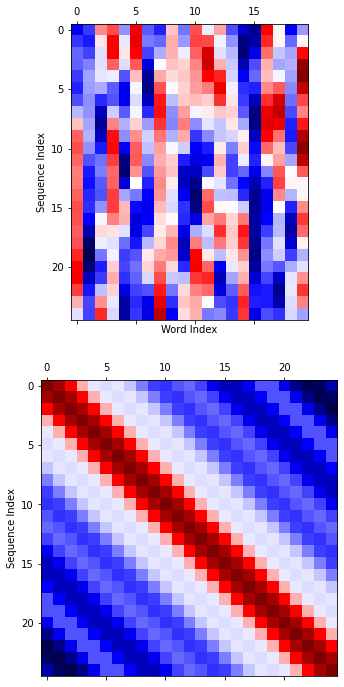

In [57]:
def rvs(dim=3):
  random_state = np.random
  H = np.eye(dim)
  D = np.ones((dim,))
  for n in range(1, dim):
      x = random_state.normal(size=(dim-n+1,))
      D[n-1] = np.sign(x[0])
      x[0] -= D[n-1]*np.sqrt((x*x).sum())
      # Householder transformation
      Hx = (np.eye(dim-n+1) - 2.*np.outer(x, x)/(x*x).sum())
      mat = np.eye(dim)
      mat[n-1:, n-1:] = Hx
      H = np.dot(H, mat)
      # Fix the last sign such that the determinant is 1
  D[-1] = (-1)**(1-(dim % 2))*D.prod()
  # Equivalent to np.dot(np.diag(D), H) but faster, apparently
  H = (D*H.T).T
  return H

seq_len_test = 25
word_dims = 20
test_seq = np.zeros((5, seq_len_test, word_dims))
scale = 50
amp = 1

# random_pos_enc_rot = np.identity(word_dims) 
random_pos_enc_rot = rvs(word_dims) 
pos_enc_inputs = test_seq, scale, amp, random_pos_enc_rot
pos_enc = positional_encoding(pos_enc_inputs)

print('First time step:', pos_enc[0,0,:7])

pos_enc_dots = np.zeros((seq_len_test, seq_len_test))
for i in range(seq_len_test):
  for j in range(seq_len_test):
    pos_enc_dots[i,j] = np.dot(pos_enc[0,i], pos_enc[0,j])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

ax1.matshow(pos_enc[0], cmap=plt.cm.seismic)
ax2.matshow(pos_enc_dots, cmap=plt.cm.seismic)

ax1.set_ylabel('Sequence Index')
ax1.set_xlabel('Word Index')

ax2.set_ylabel('Sequence Index')
ax2.set_ylabel('Sequence Index')

(3, 20)


Text(0, 0.5, 'PC2')

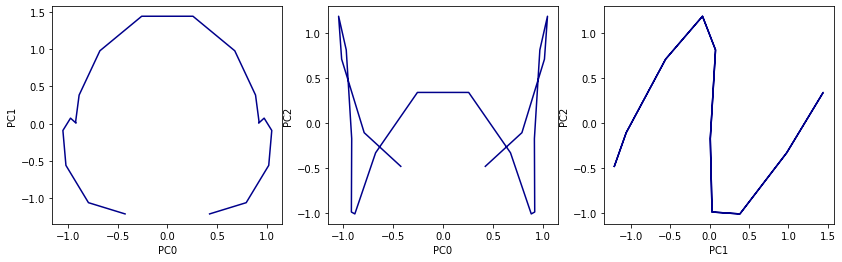

In [58]:
seq_len_test = 20
word_dims = 6
test_seq = np.zeros((1, seq_len_test, word_dims))

amp = 1.0
pos_enc_scale = 20
pod_enc_inputs = test_seq, pos_enc_scale, amp, np.identity(word_dims)
pos_enc = positional_encoding(pod_enc_inputs)

pca_time = PCA(n_components=3)
pca_pe = pca_time.fit_transform(pos_enc[0]).T
print(pca_pe.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4))
ax1.plot(pca_pe[0], pca_pe[1], color='darkblue')
ax2.plot(pca_pe[0], pca_pe[2], color='darkblue')
ax3.plot(pca_pe[1], pca_pe[2], color='darkblue')
# ax1.plot(pos_enc[0, :, 0], pos_enc[0, :, 1], color='darkblue')
# ax1.plot(pos_enc[0, :, 2], pos_enc[0, :, 3], color='darkred')
# ax1.plot(pos_enc[0, :, 4], pos_enc[0, :, 5], color='darkgreen')
# ax2.plot(pos_enc[0, :, 0], pos_enc[0, :, 2], color='darkblue')
# ax3.plot(pos_enc[0, :, 2], pos_enc[0, :, 4], color='darkblue')
ax1.set_xlabel('PC0')
ax1.set_ylabel('PC1')
ax2.set_xlabel('PC0')
ax2.set_ylabel('PC2')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')

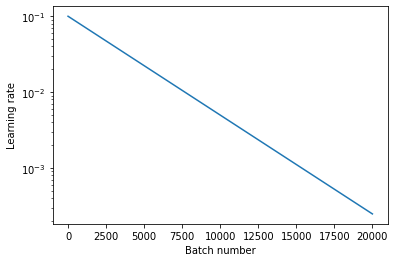

In [59]:
# Optimization hyperparameters
num_batchs = 20000        # Total number of batches to train on.
init_lr = 0.1          # initial learning rate
decay_factor = 0.9997     # decay the learning rate this much

learning_rate = optimizers.exponential_decay(init_lr, decay_steps=1, 
                                         decay_rate=decay_factor)

batch_idxs = np.linspace(1, num_batchs)
plt.semilogy(batch_idxs, [learning_rate(b) for b in batch_idxs])
plt.axis('tight')
plt.xlabel('Batch number')
plt.ylabel('Learning rate');

#### Train the Network

In [ ]:
seed = 342343
prng_key = jax.random.PRNGKey(seed) # create a random key for jax for use on device.

data_type = 'scan' # toy or scan

if data_type == 'toy':
  ########## Toy data parameters ##########
  toy_params = {
    'phrase_length': 30,    # INPUT phrase length (output phrase length could be different)
    'base_words': 3,
    'var_length': True,
    'min_phrase_len': 25,
    'pad_dim': True,
    'emb_dim': 50,
  }

  toy_params['in_words'], toy_params['in_words_pp'], toy_params['phrase_words'] = generateInputWordBank(toy_params)
  toy_params['out_words'], toy_params['out_words_pp'], toy_params['translations'] = generateOutputWordBank(toy_params)
 
########## RNN hyperparameters ##########
rnn_specs = {
  'cell_type': 'GRU',                              # Supports 'Vanilla', 'GRU', 'LSTM', or 'UGRNN'
  'arch': 'enc_dec_atth',                  # Architecture, supports 'one_to_one', 'enc_dec', 'enc_dec_short', 'enc_dec_att',
                                          # 'enc_dec_atth'
  'pos_enc_params': {'pos_enc': True, 'time_scale': 30.0, 'amplitude': 1.0},
  'zero_context': False,
  'zero_attention': False,
  'input_size': len(toy_params['in_words']),       # Number of inputs to the RNN
  'hidden_size': 128,                              # Number of units in the RNN
  'output_size': len(toy_params['out_words']),     # Number of outputs in the RNN
  'ro_bias': False,                                # Include a bias with the readout
}

########## Train hyperparameters ##########

train_params = {
  'max_grad_norm': 10.0,      # max gradient norm before clipping, clip to this value.
  'l2reg': 1e-4,           # amount of L2 regularization on the weights

  'init_lr': 0.1,                     # initial learning rate
  'decay_factor': 0.9997,             # decay the learning rate this much
  'adam_b1': 0.9,                     # Adam parameters (b1=0.9, b2=0.99, eps=1e-8 are defaults)
  'adam_b2': 0.99,
  'adam_eps': 1e-1,

  'batch_size': 128,                     # How many examples in each batch
  'num_batchs': 1000,                    # Total number of batches to train on.
  'print_every': 100,                     # Print training informatino every so often

  'n_datasets': 5,                           # Number of new train sets to generate total (this is slow)
  'epochs': 2,                               # How many times to go through each train set completely
  'test_set_size': 200,

  'init_pos_enc': False,
  'remove_pos_enc_step': 2000
}

train_params['decay_fun'] = optimizers.exponential_decay(train_params['init_lr'], decay_steps=1, 
                                                         decay_rate=train_params['decay_factor'])
train_params['train_set_size'] = train_params['batch_size'] * train_params['num_batchs'] 
# Sets default parameters if they weren't set above
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

########## Run ##########

print('# Input words (with dim pad):', len(toy_params['in_words']), '// (without):', len(toy_params['in_words_pp']), '// Input words:', toy_params['in_words_pp'])
print('# Output words (with dim pad):', len(toy_params['out_words']), '// (without):', len(toy_params['out_words_pp']), '// Output words:', toy_params['out_words_pp'])
print('Architecture:', rnn_specs['arch'])

# rnn_specs['pos_enc_params']['rot'] = np.identity(rnn_specs['input_size']) 
if rnn_specs['pos_enc_params']['pos_enc']:
  print('Adding random positional encoding rotation')
  rnn_specs['pos_enc_params']['rot'] = rvs(rnn_specs['input_size']) 

new_network = True
load_network = False
save_data = True
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_posenc_andlefttwicescan_nolefttwice_5datasets_l2is1e-4_5.pickle'
save_data = override_data(path, save_data)

if new_network:
  # Initialize the optimizer.  Please see jax/experimental/optimizers.py
  init_fun, apply_fun, mask_fun, loss_fun, accuracy_fun = build_rnn(rnn_specs)
  enc_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['in_words']))
  dec_input_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))
  output_shape, initial_params = init_fun(prng_key, enc_input_shape, dec_input_shape)

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])
  
  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = []
  train_params['global_step'] = 0
  train_params['total_steps'] = 0

elif load_network:
 
  initial_params = params_loaded_jax
  output_shape = (train_params['batch_size'], toy_params['phrase_length'], len(toy_params['out_words']))

  opt = optimizers.adam(train_params['decay_fun'], train_params['adam_b1'], train_params['adam_b2'], train_params['adam_eps'])
  opt_state, step_fun = build_optimizer_step(opt, initial_params, loss_fun, gradient_clip=train_params['max_grad_norm'])

  init_opt, update_opt, get_params = opt

  train_params['train_losses'] = train_params['train_losses'] if 'train_losses' in train_params else []
  train_params['global_step'] = train_params['total_steps']

else:
  train_params['train_losses'] = []
  train_params['total_steps'] = 12000
  train_params['global_step'] = train_params['total_steps']

# Generate synthetic data and run training on said data
if data_type == 'toy':
  opt_state, train_params = train_on_synthetic_data(opt_state, train_params, toy_params, rnn_specs)
elif data_type == 'scan':
  opt_state, train_params = train_on_scan_data(scan_data, opt_state, train_params, toy_params, rnn_specs)

train_params.pop('decay_fun') # Can't pickle with decay fun
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params, save_loss=True, )

# Destructure the trained parameters of the RNN.
final_params = get_params(opt_state)
if rnn_specs['arch'] == 'enc_dec_att':
  rnn_params, rnn_params_dec, att_params, readout_params = final_params
elif rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_atth']:
  rnn_params, rnn_params_dec, readout_params = final_params
else:
  rnn_params, readout_params = final_params

# Input words (with dim pad): 50 // (without): 8 // Input words: ['run', 'walk', 'jump', 'left', 'and', 'twice', '<.>', '<pad>']
# Output words (with dim pad): 50 // (without): 6 // Output words: ['I_RUN', 'I_WALK', 'I_JUMP', 'I_TURN_LEFT', '<.>', '<pad>']
Architecture: enc_dec_atth
Adding random positional encoding rotation
Using an output shape of: (37, 256)


In [19]:
# Save the network
path =  '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/vec_toy_3words_15to20_l2is1e-4_2.pickle'

if 'decay_fun' in train_params: train_params.pop('decay_fun')

save_data = override_data(path, True)
save_run_data(path, save_data, get_params(opt_state), toy_params, rnn_specs, train_params)

NameError: ignored

In [111]:
# Loads network
path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_toy_3words_15to20_l2is1e-3_2.pickle'

with open(path, 'rb') as load_file:
  params_loaded = pickle.load(load_file)
  toy_params = pickle.load(load_file)
  rnn_specs = pickle.load(load_file)
  train_params = pickle.load(load_file)

rnn_params, rnn_params_dec, readout_params = params_loaded
final_params = params_loaded
train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)
data_type = 'toy'

print('Data Loaded: data type:', data_type)

Data Loaded: data type: toy


Text(0, 0.5, 'Train Loss')

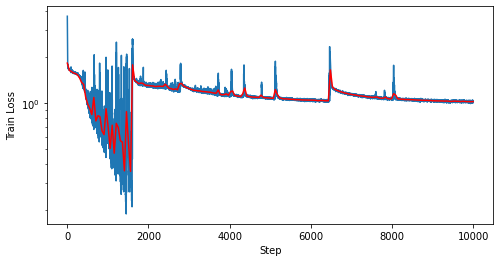

In [42]:
train_losses = train_params['train_losses']

plt.figure(figsize=(8, 4))
n_avg = 50
avg_loss = [1/n_avg * np.sum(train_losses[i*n_avg:(i+1)*n_avg]) for i in range(int(len(train_losses)/n_avg))]

plt.semilogy(np.linspace(1,len(train_losses),len(train_losses)), train_losses)
plt.semilogy(np.linspace(1,len(train_losses),int(len(train_losses)/n_avg)), avg_loss,'r')
plt.xlabel('Step')
plt.ylabel('Train Loss')

# Network Analysis

In [114]:
rnn_specs['zero_decoder_inputs'] = True

### Hidden State Analysis

In [115]:
from scipy.spatial.distance import pdist, squareform

def build_cell(rnn_specs):
  if 'cell_type' not in rnn_specs: rnn_specs['cell_type']  = 'GRU' # Default
  
  hm = 1 # hidden state size modifier
  if rnn_specs['arch'] == 'enc_dec_short':
    hm = 2

  print('Using {} cell'.format(rnn_specs['cell_type']))
  if rnn_specs['cell_type'] == 'Vanilla':
    cell = renn.VanillaRNN(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'GRU':
    cell = renn.GRU(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'LSTM':
    cell = renn.LSTM(hm * rnn_specs['hidden_size'])
  elif rnn_specs['cell_type'] == 'UGRNN':
    cell = renn.UGRNN(hm * rnn_specs['hidden_size'])
  if rnn_specs['arch'] == 'one_to_one':
     return cell
  else:
    if rnn_specs['ro_bias']:
      readout_init, readout_apply = stax.Dense(rnn_specs['output_size'])
    else:
      readout_init, readout_apply = Dense_nobias(rnn_specs['output_size'])
    return cell, readout_apply

# Some helper functions to collect RNN hidden states.
@jax.jit
def _get_all_states(inputs, in_masks, params):
  """Get RNN states in response to a batch of inputs (also returns masked states)."""
  print('Get all states with arch:', rnn_specs['arch'])
  
  if rnn_specs['arch'] == 'enc_dec': # Vanilla encoder decoder
    rnn_params_enc, rnn_params_dec, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply
    
    return encode_decode(initial_states, inputs, rnn_apply, functools.partial(readout_apply, readout_params), 
                         return_hidden=True)
  elif rnn_specs['arch'] in ['enc_dec_att', 'enc_dec_short']: # Encoder decoder with attention/shorts
    def attention_apply(params, inputs):
      att_mat = params
      return jnp.dot(inputs, att_mat)
    
    if rnn_specs['arch'] == 'enc_dec_short':
      rnn_params_enc, rnn_params_dec, readout_params = params
      # Builds attend matrix based on shorts
      att_params = jnp.diag(jnp.asarray([int(i in rnn_specs['shorts']) for i in range(toy_params['phrase_length'])]))
    elif rnn_specs['arch'] == 'enc_dec_att':
      rnn_params_enc, rnn_params_dec, att_params, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply
    att_apply = functools.partial(attention_apply, jax.nn.softmax(att_params, axis=0))
      
    return encode_decode_attn(initial_states, inputs, rnn_apply, att_apply, functools.partial(readout_apply, readout_params), 
                             return_hidden=True, zero_context=rnn_specs['zero_context'])
  
  elif rnn_specs['arch'] in ['enc_dec_atth']: # Encoder decoder with attention via hidden states
    rnn_params_enc, rnn_params_dec, readout_params = params
    initial_states = cell.get_initial_state(rnn_params_enc, batch_size=inputs.shape[0])
    enc_apply = functools.partial(cell.batch_apply, rnn_params_enc)
    dec_apply = functools.partial(cell_dec.batch_apply, rnn_params_dec)
    rnn_apply = enc_apply, dec_apply

    dec_seq_size = (inputs.shape[0], rnn_specs['out_len'], len(toy_params['out_words'])) # (batch size, phrase len, output word size)
    
    print('Running attnh with pos_enc:', rnn_specs['pos_enc_params']['pos_enc'])
    return encode_decode_attnh(initial_states, inputs, in_masks, rnn_apply, functools.partial(readout_apply, readout_params), 
                             return_hidden=True, rnn_specs=rnn_specs, variable_len=toy_params['var_length'],
                             dec_seq_size=dec_seq_size)
  elif rnn_specs['arch'] == 'one_to_one':
    rnn_params, readout_params = params
    
    initial_states = cell.get_initial_state(rnn_params, batch_size=inputs.shape[0])
    return renn.unroll_rnn(initial_states, inputs, functools.partial(cell.batch_apply, rnn_params))

def rnn_states(batch, params, rnn_specs, only_final=False):
  """Return RNN states."""
  states = _get_all_states(batch['inputs'], batch['in_index'], params)
  if only_final: # returns only the final hidden state
    raise NotImplementedError
  else:
    return [h for h in states]

def keep_unique_fixed_points(fps, identical_tol=0.0, do_print=True):
  """Get unique fixed points by choosing a representative within tolerance.
  Args:
    fps: numpy array, FxN tensor of F fixed points of N dimension
    identical_tol: float, tolerance for determination of identical fixed points
    do_print: Print useful information? 
  Returns:
    2-tuple of UxN numpy array of U unique fixed points and the kept indices
  """
  keep_idxs = np.arange(fps.shape[0])
  if identical_tol <= 0.0:
    return fps, keep_idxs
  if fps.shape[0] <= 1:
    return fps, keep_idxs
  
  nfps = fps.shape[0]
  example_idxs = np.arange(nfps)
  all_drop_idxs = []

  # If point a and point b are within identical_tol of each other, and the
  # a is first in the list, we keep a.
  distances = squareform(pdist(fps, metric="euclidean"))
  for fidx in range(nfps-1):
    distances_f = distances[fidx, fidx+1:]
    drop_idxs = example_idxs[fidx+1:][distances_f <= identical_tol]
    all_drop_idxs += list(drop_idxs)
       
  unique_dropidxs = np.unique(all_drop_idxs)
  keep_idxs = np.setdiff1d(example_idxs, unique_dropidxs)
  if keep_idxs.shape[0] > 0:
    unique_fps = fps[keep_idxs, :]
  else:
    unique_fps = np.array([], dtype=np.int64)

  if do_print:
    print("    Kept %d/%d unique fixed points with uniqueness tolerance %f." %
          (unique_fps.shape[0], nfps, identical_tol))
    
  return unique_fps, keep_idxs

def participation_ratio_vector(C):
  """Computes the participation ratio of a vector of variances."""
  return np.sum(C) ** 2 / np.sum(C*C)

def generate_labels(toy_params):
  """ Generates all possible labels a phrase can have """
  total_labels = len(toy_params['out_words'])**toy_params['phrase_length']
  labels = []
  for i in range(toy_params['phrase_length']):
    if labels == []:
      labels = [[i] for i in range(len(toy_params['out_words']))]
    else:
      new_labels = []
      for j in range(len(labels)):
        for k in range(len(toy_params['out_words'])):
          temp_label = labels[j].copy()
          temp_label.append(k)
          new_labels.append(temp_label)
      labels = new_labels

  return labels

In [116]:
# Get RNN hidden states in response to a test batch.
n_trials = 1000
eos_idx = toy_params['in_words'].index('<pad>') # assumes eos is last word in vocab

_, apply_fun, _, _, accuracy_fun = build_rnn(rnn_specs)

# rnn_specs['zero_context'] = True
if data_type == 'toy':
  hs_data = generate_data(n_trials, toy_params, rnn_specs)
elif data_type == 'scan':
  scan_data, _ = generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=n_trials)
  hs_data =  {
    'inputs': scan_data['inputs'],
    'labels': scan_data['labels'],
    'in_index': scan_data['in_index'],
    'out_index': scan_data['out_index'],
  }

phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
print('******** Test Acc:', np.mean(phrase_acc), 'Word Acc:', np.mean(word_acc), '********')

input_phrase_len = hs_data['inputs'].shape[1]

if rnn_specs['arch'] == 'one_to_one':
  cell = build_cell(rnn_specs)
  raw_hs = rnn_states(hs_data, final_params)
else: 
  cell, readout_apply = build_cell(rnn_specs)
  if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
    cell_dec, readout_apply = build_cell(rnn_specs)
  print('Running full data for plotting hidden states')
  raw_hs = rnn_states(hs_data, final_params, rnn_specs)
  
  # Creates special inputs to get outputs from just positional encoding
    # First (rnn_specs['input_size']) of these will be all a given input with '<pad>' at end
    # idx -2 will be average input with '<pad>' at end
    # idx -1 will be no input (with no pad)
  special_inputs = np.zeros((2 + rnn_specs['input_size'],) + hs_data['inputs'][0].shape)
  for i in range(rnn_specs['input_size']): # Creates an input that is one-hot in same position
    special_inputs[i, :-1, i] = np.ones((hs_data['inputs'][0].shape[0]-1))
  special_inputs[-2, :-1, :] = 1/rnn_specs['input_size'] * np.ones((hs_data['inputs'][0].shape[0]-1, hs_data['inputs'][0].shape[1])) # average input
  special_inputs[:-1, -1, eos_idx] =  np.ones((1 + rnn_specs['input_size']))
  special_data =  {
    'inputs': special_inputs,
    'labels': jnp.zeros((special_inputs.shape[0],) + hs_data['labels'][0].shape), # These aren't used
    'in_index': jnp.asarray([np.max(hs_data['in_index']) for _ in range(special_inputs.shape[0])]),
    'out_index': jnp.asarray([np.max(hs_data['out_index']) for _ in range(special_inputs.shape[0])]),
  }
  print('Running special data ')
  special_hs = rnn_states(special_data, final_params, rnn_specs)

  hs = {}
  
  hs = {
    'enc': [h[:input_phrase_len] for h in raw_hs],
    'dec': [h[input_phrase_len:input_phrase_len + len] 
                for h, len in zip(raw_hs, hs_data['out_index'])], # includes final encoder hs 
    'encf': [h[input_phrase_len-1] for h in raw_hs],
    'decf': [h[input_phrase_len + len -1] for h, len in zip(raw_hs, hs_data['out_index'])],
  }

  print('Encoder list length:', len(hs['enc']) ,'// Individual shape:', hs['enc'][0].shape)
  print('Decoder list length:', len(hs['dec']) ,'// Individual shape:', hs['dec'][1].shape)

hs['all'] = raw_hs
hs['special'] = special_hs
print('All list length:', len(hs['all']) ,'// Individual shape:', hs['all'][0].shape)

# test_acc = accuracy_fun_ext(final_params, hs_data)
# print('Test Accuracy:', test_acc)
# rnn_specs['zero_context'] = False

if rnn_specs['arch'] in ['enc_dec_atth'] and not rnn_specs['zero_context']  and not rnn_specs['zero_attention']:
  if rnn_specs['ro_bias']: raise NotImplementedError
  hidden_split = rnn_specs['hidden_size'] if rnn_specs['cell_type'] != 'LSTM' else 2*rnn_specs['hidden_size']
  readout = readout_params[hidden_split:, :len(toy_params['out_words_pp'])].T # Ignores padded dimensions
  readout_dec = readout_params[:hidden_split, :len(toy_params['out_words_pp'])].T
  print('Readout_enc/Readout_dec ratio:', np.linalg.norm(readout)/ np.linalg.norm(readout_dec))
else:
  if rnn_specs['ro_bias']:
    wO, bO = readout_params
  else:
    readout = readout_params[:, :len(toy_params['out_words_pp'])].T
print('Readout shape:', readout.shape)

Sythentic data generated in: 0.12 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
******** Test Acc: 1.0 Word Acc: 1.0 ********
Using GRU cell
Using GRU cell
Running full data for plotting hidden states
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: standard
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Running special data 
Get all states with arch: enc_dec_atth
Running attnh with pos_enc: standard
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 20.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 20.0
Zero context True
Encoder list length: 1000 // Individual shape: (20, 128)
Decoder list length: 1000 // Individual shape: (19, 128)
All list length: 1000 // Individual shape: (40, 128)
Readout shape: (4, 128)


In [ ]:
# Filter to only certain subset of labels
phrase_idx = 1
label_val = 2

lbl_idxs = [lbl_idx for lbl_idx in range(len(labels)) if labels[lbl_idx][phrase_idx] == label_val]

hs_filtered = []
for idx in lbl_idxs:
  hs_filtered.extend(states[idx])
pts_filtered = np.vstack(hs_filtered)

pca_filtered = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_filtered.fit_transform(pts_filtered)

explained_var = pca_filtered.explained_variance_ratio_
print('PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_filtered.explained_variance_))

NameError: ignored

Top 10 components: 0.994447 ( [0.5021073  0.24866082 0.18915665 0.01714227 0.01015232 0.00902332
 0.00831214 0.00628344 0.00198266 0.00162611] )
Participation Ratio: 2.854538681136366
Copy this: PCA: [0.5021073  0.24866082 0.18915665 0.01714227 0.01015232 0.00902332
 0.00831214 0.00628344 0.00198266 0.00162611] PR: 2.854538681136366
Readout vec proj via PCA: [[-9.298231   -9.217187   -9.412267   -9.174599  ]
 [ 3.7303343   3.7761307   3.7425847   3.7457247 ]
 [ 6.1450686   6.189988    6.1098537   6.1357803 ]
 [ 1.2987163   2.0124898   1.1034311   1.6171789 ]
 [ 0.3537476  -3.1536102  -0.9199006  -1.2891941 ]
 [-3.3608732  -1.8062534   0.5270071  -1.600996  ]
 [-2.3677163  -0.8830718  -3.7797341  -2.5374298 ]
 [-1.5260998  -2.2345102  -2.0018165  -2.1593957 ]
 [ 1.1189644   1.2571428   1.0661917   2.115413  ]
 [-0.42297775 -0.34585246 -0.3941247  -1.9673532 ]]
h0 shape (128,)


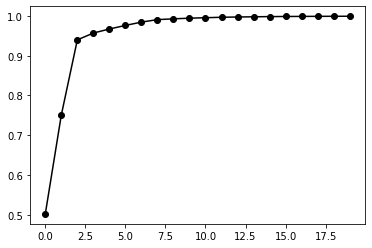

In [151]:
pc_dims = 10
pts_subset = 'enc' # supports 'enc', 'dec', 'all', and 'encf'

# Finds percentage of variance explained by top pc_dims of PCA
# pca_full = PCA(n_components=rnn_specs['hidden_size'])
pca_full = PCA(n_components=np.min([len(hs[pts_subset]), rnn_specs['hidden_size']]))
_ = pca_full.fit_transform(np.vstack(hs[pts_subset]))
explained_var = pca_full.explained_variance_ratio_
print('Top', pc_dims, 'components:', np.sum(explained_var[:pc_dims]), '(', explained_var[:pc_dims],')')
print('Participation Ratio:', participation_ratio_vector(pca_full.explained_variance_))
print('Copy this: PCA:', explained_var[:pc_dims], 'PR:', participation_ratio_vector(pca_full.explained_variance_))
total_exvar = []
for i in range(rnn_specs['hidden_size']-1):
  total_exvar.append(np.sum(explained_var[:i+1]))
plt.figure()
plt.plot(total_exvar[:20], 'k-o')

# We use principal components analysis (PCA) for visualization.
pca = PCA(n_components=pc_dims).fit(np.vstack(hs[pts_subset]))
print('Readout vec proj via PCA:', pca.transform(readout).T)

# The initial state.
h0 = cell.get_initial_state(rnn_params)[:rnn_specs['hidden_size']]
print('h0 shape', h0.shape)

Example phrase length: 17
Example phrase: ['I2', 'I2', 'I0', 'I2', 'I0', 'I0', 'I1', 'I1', 'I1', 'I1', 'I1', 'I2', 'I0', 'I0', 'I1', 'I2', 'I1', '<pad>', '<pad>', '<pad>']
Example phrase length: 19
Example phrase: ['I0', 'I2', 'I2', 'I1', 'I1', 'I1', 'I0', 'I2', 'I1', 'I0', 'I1', 'I1', 'I0', 'I2', 'I1', 'I0', 'I1', 'I1', 'I2', '<pad>']
Example phrase length: 19
Example phrase: ['I1', 'I1', 'I0', 'I0', 'I1', 'I1', 'I0', 'I2', 'I0', 'I0', 'I2', 'I1', 'I1', 'I2', 'I1', 'I1', 'I2', 'I1', 'I0', '<pad>']


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


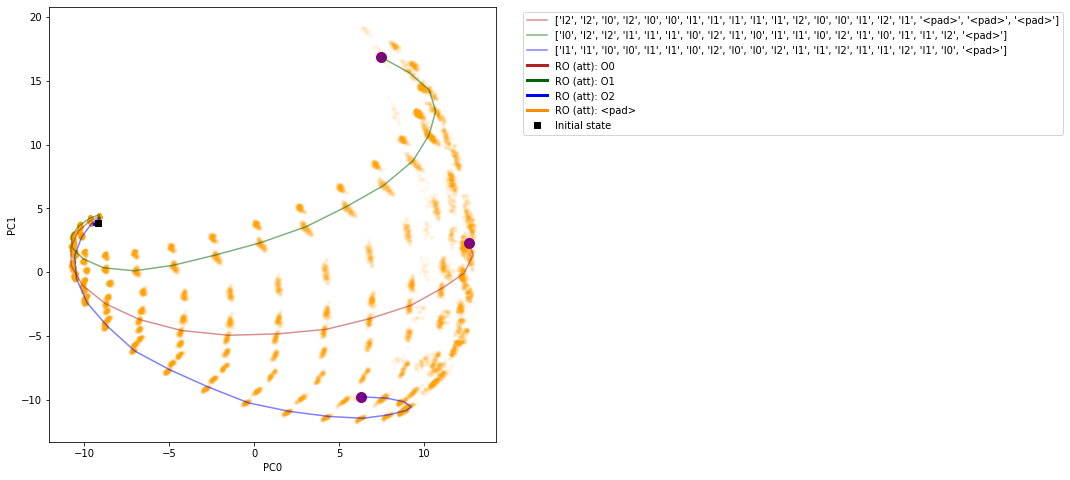

In [152]:
# Here, we visualize the hidden states of the RNN, projected into a
# low-dimensional 2D state space.

pts_subset = 'enc'

plt.figure(figsize=(8, 8))

pc1 = 0
pc2 = 1

final_hs_idx = 2*toy_params['phrase_length'] if pts_subset == 'all' and not rnn_specs['arch'] == 'one_to_one' else toy_params['phrase_length']
encode_hs_idx = 0 if pts_subset == 'dec' else input_phrase_len

# pca_h0 = pca.transform(np.atleast_2d(h0)).T
pca_h0 = pca.transform(np.atleast_2d(np.concatenate([h0, np.zeros((h0.shape))], axis=0))).T


# Plots hidden states
fs_alpha = 0.05
pca_hs = pca.transform(np.vstack(hs[pts_subset])).T
if pts_subset == 'all':
  pl = input_phrase_len
  plt.scatter(pca_hs[pc1][:pl], pca_hs[pc2][:pl], color = 'k', marker='.', alpha=fs_alpha)
  plt.scatter(pca_hs[pc1][pl-1:], pca_hs[pc2][pl-1:], color = 'gray', marker='.', alpha=fs_alpha)
else:
  plt.scatter(pca_hs[pc1], pca_hs[pc2], color = 'orange', marker='.', alpha=fs_alpha)
hs_idxs = [5, 6 ,7] # [0]
for hs_idx in hs_idxs: # Plots example paths
  print('Example phrase length:', hs_data['out_index'][hs_idx])
  print('Example phrase:', tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca.transform(hs[pts_subset][hs_idx]).T), axis=1) 
  if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
    pca_decf = pca.transform(np.atleast_2d(hs['decf'][hs_idx])).T
    plt.scatter(pca_decf[pc1], pca_decf[pc2], color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  elif pts_subset == 'enc':
    plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  else:
    pca_state = pca.transform(hs[pts_subset][hs_idx]).T
    plt.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))

  plt.scatter(pca_state[pc1, encode_hs_idx], pca_state[pc2, encode_hs_idx], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Special inputs plotting
# pos_enc_idxs = [0, 1, 2, 3]
# pos_enc_labs = ['0 hot', '1 hot', '2 hot', '3 hot', 'pos enc']
# for pos_enc_idx in pos_enc_idxs:
#   if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#     pca_state = np.concatenate((pca_h0, pca.transform(hs['pos_enc'][pos_enc_idx]).T), axis=1) 
#   if pts_subset == 'all':
#     plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], 
#              marker=None, alpha=1.0, label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#     plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[pos_enc_idxs.index(pos_enc_idx)],
#              marker=None, alpha=1.0)
#   else:
#     plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#               label=pos_enc_labs[pos_enc_idxs.index(pos_enc_idx)])
#   plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#                 s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# pca_states = pca.transform(np.vstack(hs)).T
# plt.plot(pca_states[pc1], pca_states[pc2], c = 'k', marker='o', alpha=0.01, label='Hidden sates')

# Plots readout direction
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
pca_ro = pca.transform(readout_plot)
# pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
pca_zero = pca.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label=f'RO ({readout_type}): '+ toy_params['out_words'][i])

# path_idxs = [54, 56, 57]
# for path_idx in path_idxs:
#   print('Path labels:', syn_data_test['labels'][path_idx])
#   path_pca = pca.transform(hs[path_idx]).T
#   plt.plot(path_pca[pc1], path_pca[pc2], c='orange', marker='.', label='Random Path')

plt.plot(pca_h0[pc1], pca_h0[pc2], 'ks', label='Initial state')

plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))
plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [ ]:
for i in range(12):
  print(f'Example phrase {i}:', tensorToPhrase(hs_data['inputs'][i], toy_params['in_words']))

Example phrase 0: ['run', '<pad>', '<pad>', '<pad>']
Example phrase 1: ['walk', 'and', 'jump', '<pad>']
Example phrase 2: ['jump', 'and', 'run', '<pad>']
Example phrase 3: ['walk', '<pad>', '<pad>', '<pad>']
Example phrase 4: ['run', 'and', 'walk', '<pad>']
Example phrase 5: ['walk', 'and', 'run', '<pad>']
Example phrase 6: ['run', 'and', 'jump', '<pad>']
Example phrase 7: ['run', 'and', 'run', '<pad>']
Example phrase 8: ['jump', 'and', 'jump', '<pad>']
Example phrase 9: ['jump', 'and', 'walk', '<pad>']
Example phrase 10: ['jump', '<pad>', '<pad>', '<pad>']
Example phrase 11: ['walk', 'and', 'walk', '<pad>']


#### Readout Vector Analysis

In [ ]:
from itertools import combinations 

def subspace_perc(A, b):
  """
  A: an N x M matrix, whose column space represents some M-dimensional subspace
  b: an N x P vector
  For each of b's columns, finds the percentage of its magnitude which lies in 
  the subspace formed by the columns of A (its columnspace). Then averages these together
  """
  proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # N x N matrix
  b_proj = np.matmul(proj, b) # N x P martix

  norm_perc = np.linalg.norm(b_proj, axis=0)/np.linalg.norm(b, axis=0) # P dim vector

  return np.mean(norm_perc)

def ro_subspace_analysis(readout):
  readout = np.asarray(readout)
  ro_n = readout.shape[0]
  indices = [i for i in range(ro_n)]
  for ss_dim in range(1, ro_n): # Tries dimensions from 1 to ro_n - 1
    comb = combinations(indices, ss_dim) # Gets all possible combinations
    n_comb = 0
    perc_vals = 0
    for subspace_idxs in list(comb): # For each combination
      n_comb += 1
      A_idxs = list(subspace_idxs)
      b_idxs = list(filter(lambda a: a not in list(subspace_idxs), indices))
      A = readout[A_idxs]
      b = readout[b_idxs] 
      perc_vals += subspace_perc(A.T, b.T)
    print('Avg perc in rest for subspace dim {}:'.format(ss_dim), 1/n_comb * perc_vals)

readout_mags = []
readout_pca_mags = []
pc_dims = 2
for i in range(len(readout)):
  readout_mags.append(np.linalg.norm(readout[i]))
  # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  print('Readout {} mag:'.format(i), readout_mags[i])
  # print('Readout {}'.format(i), '(perc in first {} PC dims):'.format(pc_dims), readout_pca_mags[i]/readout_mags[i])

for i in range(len(readout)):
  for j in range(i):
    print('Angle ({}, {}):'.format(i,j), 180/np.pi * np.arccos(np.dot(readout[i], readout[j])/(readout_mags[i]*readout_mags[j])))

ro_subspace_analysis(readout)

if rnn_specs['arch'] in ['enc_dec_atth']:
  for i in range(len(readout_dec)):
    print('Readout (decoder) {} mag:'.format(i), np.linalg.norm(readout_dec[i]))
    # readout_pca_mags.append(np.linalg.norm(np.matmul(comp, readout.T).T[i][:pc_dims]))
  for i in range(len(readout_dec)):
    print('Readout att/decoder {} dot:'.format(i), 180/np.pi * np.arccos(np.dot(readout[i], readout_dec[i])/
          (np.linalg.norm(readout[i])*np.linalg.norm(readout_dec[i]))))

Readout 0 mag: 3.9141
Readout 1 mag: 3.8970046
Readout 2 mag: 3.9691508
Readout 3 mag: 4.007365
Readout 4 mag: 1.2966049
Readout 5 mag: 1.467334
Angle (1, 0): 108.34536469056633
Angle (2, 0): 108.87228646427613
Angle (2, 1): 108.65870644892983
Angle (3, 0): 107.46310915547578
Angle (3, 1): 108.34397133197564
Angle (3, 2): 108.20469011442074
Angle (4, 0): 87.11663814635729
Angle (4, 1): 86.67764139783306
Angle (4, 2): 88.13600972903583
Angle (4, 3): 89.00772628223706
Angle (5, 0): 90.14312911853578
Angle (5, 1): 84.029693169835
Angle (5, 2): 92.36022901368943
Angle (5, 3): 92.863518332871
Angle (5, 4): 116.04028313025937
Avg perc in rest for subspace dim 1: 0.17867425953348476
Avg perc in rest for subspace dim 2: 0.3144105200966199
Avg perc in rest for subspace dim 3: 0.4457833379507065
Avg perc in rest for subspace dim 4: 0.5955171118179957
Avg perc in rest for subspace dim 5: 0.7800966302553812
Readout (decoder) 0 mag: 1.5214894
Readout (decoder) 1 mag: 1.6672632
Readout (decoder) 2 m

x 1.0
y 0.99999994
x.y 0.0
Example phrase length: 15
Example phrase: ['I0', 'I0', 'I0', 'I0', 'I0', 'I2', 'I2', 'I0', 'I1', 'I1', 'I2', 'I2', 'I1', 'I0', 'I1', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


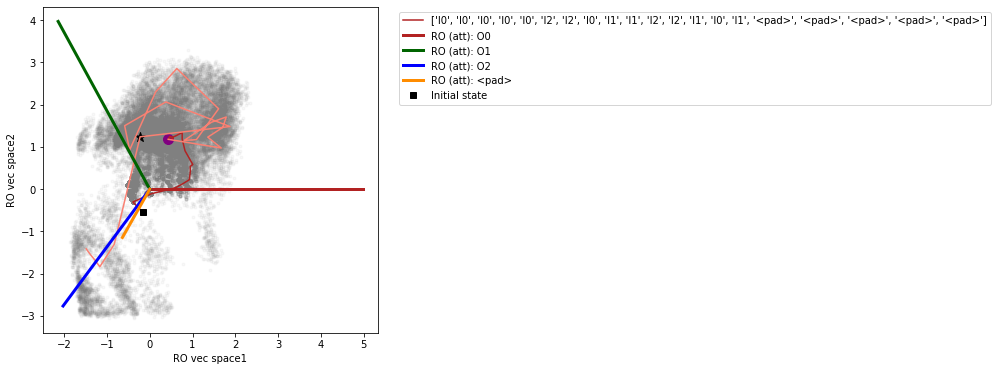

In [122]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
readout_type = 'att' # 'att' or 'hs'
readout_plot = readout if readout_type == 'att' else readout_dec
x_basis = readout_plot[ro1] / np.linalg.norm(readout_plot[ro1])
y_vec = readout_plot[ro2] - np.dot(x_basis, readout_plot[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)

# Plots hidden states
fs_alpha = 0.05
hs_x_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), x_basis)
hs_y_vals = np.dot(np.matmul(np.vstack(hs[pts_subset]), proj), y_basis)
if pts_subset == 'all':
  pl = input_phrase_len
  plt.scatter(hs_x_vals[:pl], hs_y_vals[:pl], color = 'k', marker='.', alpha=fs_alpha)
  plt.scatter(hs_x_vals[pl-1:], hs_y_vals[pl-1:], color = 'gray', marker='.', alpha=fs_alpha)
else:
  plt.scatter(hs_x_vals, hs_y_vals, color = 'purple', marker='.', alpha=fs_alpha)

hs_idxs = [0]
for hs_idx in hs_idxs: # Plots example paths
  print('Example phrase length:', hs_data['out_index'][hs_idx])
  print('Example phrase:', tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
    hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), x_basis)))
    hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs[pts_subset][hs_idx]), proj), y_basis)))
  if pts_subset == 'dec' or pts_subset == 'all':  # Puts star on final hidden state
    x_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), x_basis)
    y_decf = np.dot(np.matmul(hs['decf'][hs_idx], proj), y_basis)
    plt.scatter(x_decf, y_decf, color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    plt.plot(hs_path_x[:pl+1], hs_path_y[:pl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    plt.plot(hs_path_x[pl:], hs_path_y[pl:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    plt.plot(hs_path_x, hs_path_y, color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  plt.scatter(hs_path_x[encode_hs_idx+1], hs_path_y[encode_hs_idx+1], color = 'purple', marker='o', 
                s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# # Positional encoding plotting
# if pts_subset == 'enc' or pts_subset == 'all': # Adds h0 to path
#   hs_path_x = np.concatenate((np.asarray([h0_x_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), x_basis)))
#   hs_path_y = np.concatenate((np.asarray([h0_y_val,]), np.dot(np.matmul(np.vstack(hs['special'][0]), proj), y_basis)))
# if pts_subset == 'all':
#   plt.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = 'k', marker=None, alpha=1.0,
#             label='Pos Enc Output')
#   plt.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = 'k', marker=None, alpha=1.0)
# else:
#   plt.plot(pca_state[pc1], pca_state[pc2], color =  'k', marker=None, alpha=0.5, 
#             label='Pos Enc Output')
# plt.scatter(pca_state[pc1, encode_hs_idx+1], pca_state[pc2, encode_hs_idx+1], color = 'k', marker='o', 
#               s=100.0, alpha=1.0) # Puts circle on full encoded hidden state

# Plots readout direction
pca_ro = pca.transform(readout_plot)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout_plot.shape[0]):
  ro_proj = np.matmul(proj, readout_plot[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], color=state_colors[i], 
           linewidth = 3, label=f'RO ({readout_type}): '+toy_params['out_words'][i])

plt.plot(h0_x_val, h0_y_val, 'ks', label='Initial state')

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

plt_lim = None
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#### Attention Analysis

Zero context False
In index 17
Out index 14
In index 13
Out index 10


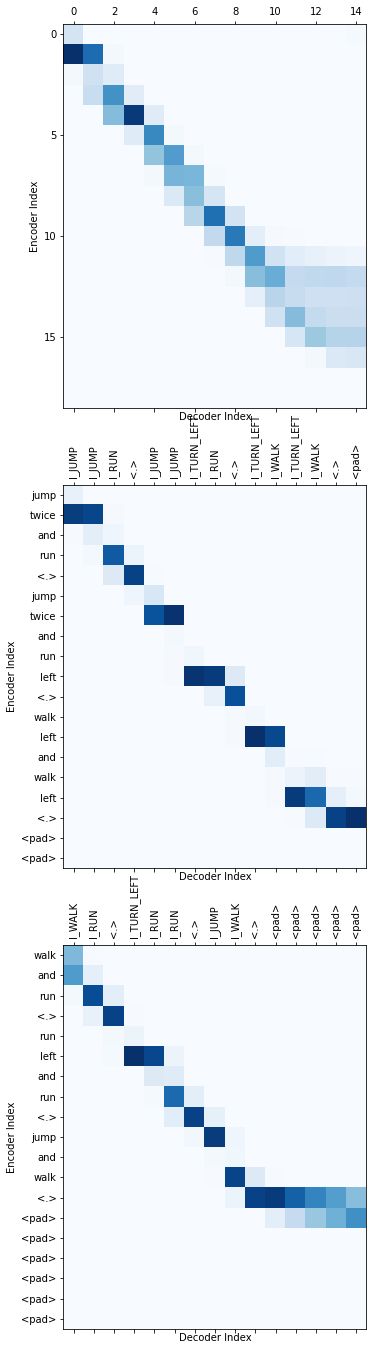

In [35]:
# Calculate attention matrix via apply function
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]

_, new_apply_fun, _, _, _ = build_rnn(rnn_specs)
all_logits, attn_matrix_dir = new_apply_fun(final_params, hs_data['inputs'], hs_data['in_index'], return_att_matrix=True)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,24))

phrase_idxs = [0, 1]

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

# Mean attention matrix
ax1.matshow(np.mean(attn_matrix_dir, axis=0), cmap=plt.cm.Blues)

for ax, i in zip((ax2, ax3), phrase_idxs):
  print('In index', hs_data['in_index'][i])
  print('Out index', hs_data['out_index'][i])
  
  ax.matshow(attn_matrix_dir[i], cmap=plt.cm.Blues)
  enc_labels = tensorToPhrase(hs_data['inputs'][i], toy_params['in_words'])
  dec_labels = tensorToPhrase(hs_data['labels'][i], toy_params['out_words'])

  ax.set_ylabel('Encoder Index')
  ax.set_xlabel('Decoder Index')

  ax.set_xticks([j for j in range(dec_len)])
  ax.set_yticks([j for j in range(enc_len)])
  ax.set_yticklabels(enc_labels, rotation=0)
  ax.set_xticklabels(dec_labels, rotation=90)

Single sequence shape: (33, 256)
0


KeyboardInterrupt: ignored

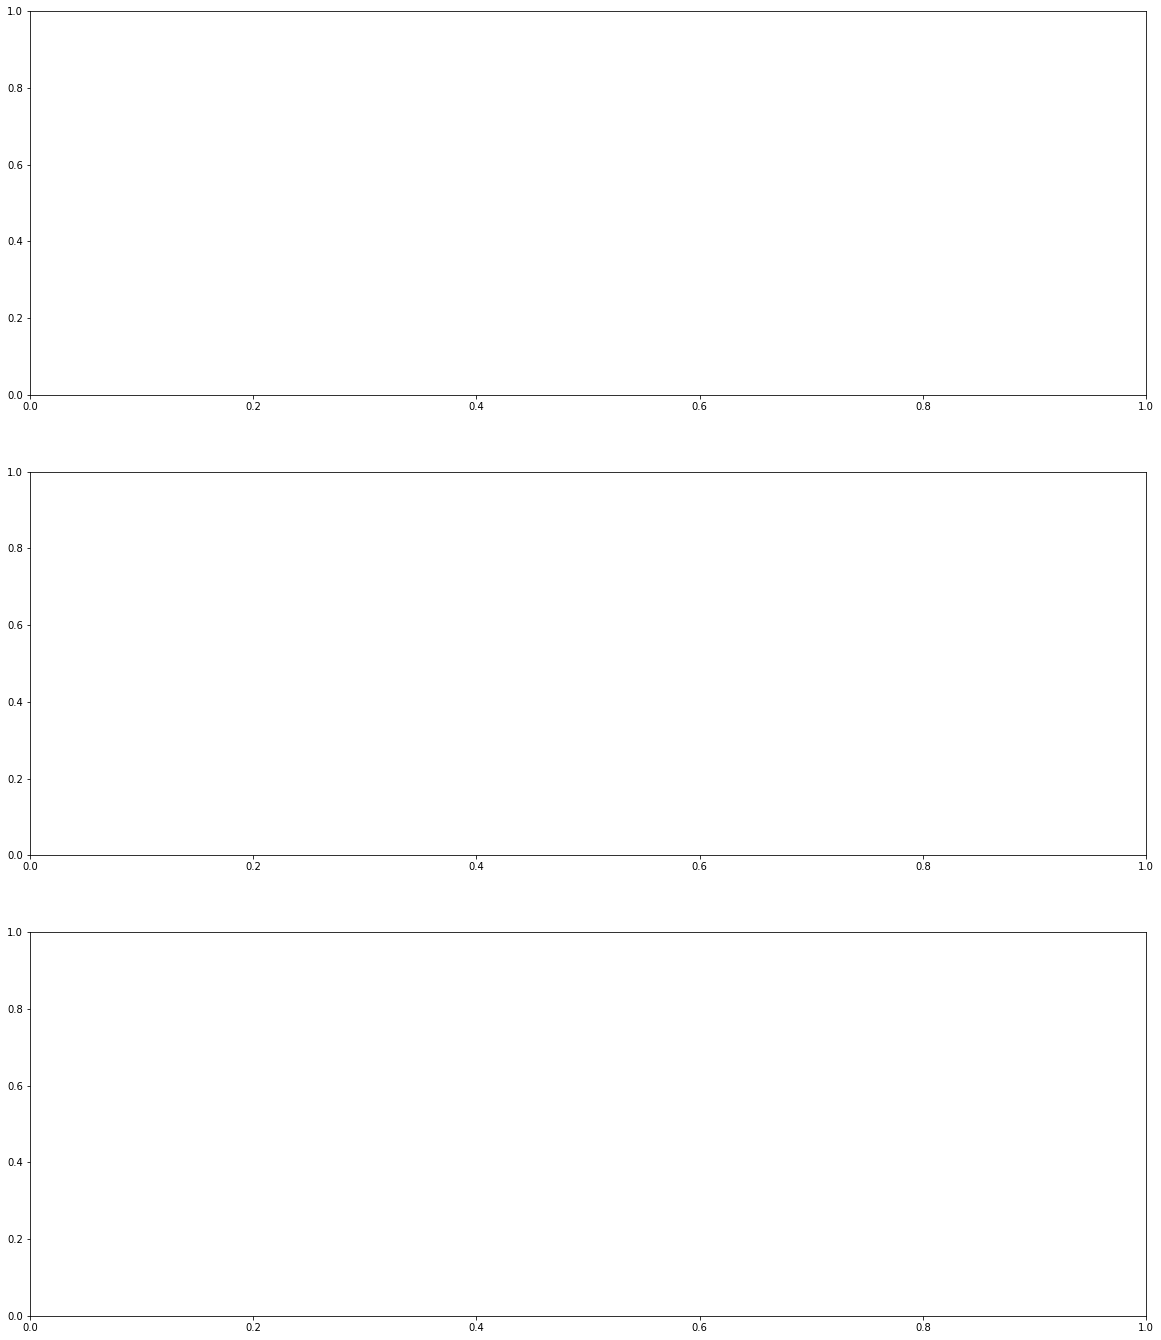

In [28]:
# Calculate attention matrix by hand via hidden states

from scipy.special import softmax
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,24))

print('Single sequence shape:', hs['all'][0].shape)
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
attention_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
for h_idx in range(len(hs['all'])):
  if h_idx % 100 == 0: print(h_idx)
  enc_seq = hs['all'][h_idx][:enc_len]
  for seq_idx in range(dec_len):
    raw_aligns = np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx])
    # Masks if beyond in_index length
    raw_aligns[hs_data['in_index'][h_idx]+1:] = -10000 * np.ones((enc_len - hs_data['in_index'][h_idx]-1))
    attention_matrix[h_idx, :, seq_idx] = softmax(raw_aligns)

# Mean attention matrix
ax1.matshow(np.mean(attention_matrix, axis=0), cmap=plt.cm.Blues)

phrase_idxs = [8, 9]

ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

for ax, i in zip((ax2, ax3), phrase_idxs):
  ax.matshow(attention_matrix[i], cmap=plt.cm.Blues)
  enc_labels = tensorToPhrase(hs_data['inputs'][i], toy_params['in_words'])
  dec_labels = tensorToPhrase(hs_data['labels'][i], toy_params['out_words'])

  ax.set_ylabel('Encoder Index')
  ax.set_xlabel('Decoder Index')

  ax.set_xticks([j for j in range(dec_len)])
  ax.set_yticks([j for j in range(enc_len)])
  ax.set_yticklabels(enc_labels, rotation=0)
  ax.set_xticklabels(dec_labels, rotation=90)

True


### Find Fixed Points

In [ ]:
add_noise = True
noise_scale = 0.5
cell_type = 'enc'

word = '<pad>' # 'I0'
if word == None:
  word_tensor = 1/rnn_specs['input_size']*jnp.ones(rnn_specs['input_size'])
elif cell_type == 'enc':
  word_tensor = wordToTensor(word, toy_params['in_words'])[0]
elif cell_type == 'dec':
  word_tensor = wordToTensor(word, toy_params['out_words'])[0]

xstar = np.repeat(word_tensor[np.newaxis, :], pts[pts_subset].shape[0], axis=0)

if add_noise:
  seed_pts = pts[pts_subset] + np.random.normal(loc=0.0, scale=noise_scale, size=pts[pts_subset].shape)
else:
  seed_pts = pts[pts_subset]

if rnn_specs['arch'] in ['enc_dec', 'enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  if cell_type == 'dec':
    print('Decoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell_dec, rnn_params_dec)
  elif cell_type == 'enc':
    print('Encoder fixed points.')
    fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
  if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']: # add zeros to hidden state
    null_hs = np.zeros(pts[pts_subset].shape)
    seed_pts = np.concatenate((seed_pts, null_hs), axis=1)
else:
  fp_loss_fun = renn.build_fixed_point_loss(cell, rnn_params)
xstar = jnp.asarray(xstar)
fixed_points, loss_hist, fp_losses = renn.find_fixed_points(fp_loss_fun, seed_pts, xstar, optimizers.adam(0.01),
                                                            tolerance=1e-2)
print('Done')

if rnn_specs['arch'] in ['enc_dec_short', 'enc_dec_att', 'enc_dec_atth']:
  fixed_points = fixed_points[:, :rnn_specs['hidden_size']]

pca_fixed_points = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_fixed_points.fit_transform(fixed_points)
print('Fixed Points PR:', participation_ratio_vector(pca_fixed_points.explained_variance_ratio_))
print('% Var Exp:', pca_fixed_points.explained_variance_ratio_[:5])

Encoder fixed points.
Done
Fixed Points PR: 1.0157657504933155
% Var Exp: [9.9219364e-01 5.1310076e-03 2.0770244e-03 3.1081797e-04 1.2073886e-04]


Text(0, 0.5, 'PC5')

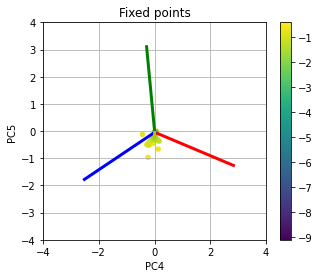

In [ ]:
# 2D Visualization of the approximate fixed points: the line attractor.

pc1 = 4
pc2 = 5

plt.figure(figsize=(5, 4))
pca_fps = pca.transform(np.vstack(fixed_points)).T
# pca_fps = pca.transform(np.vstack(hs_grid_points)).T
plt.scatter(pca_fps[pc1], pca_fps[pc2], s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()

plt.colorbar()

# pca_word = 1*word_deflection('kinda0', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='k')
# pca_word = 1*word_deflection('kinda1', cell, toy_params, rnn_params, rnn_specs, fixed_points[fp_idx], comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='r')
# pca_word = 3*word_deflection('kinda01', cell, toy_params, rnn_params, rnn_specs, h0, comp)
# plt.plot([pca_h0[pc1], pca_word[pc1]], [pca_h0[pc2], pca_word[pc2]], color='b')

# Plots readout direction
pca_ro = pca.transform(readout)
pca_zero = pca.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
for i in range(readout.shape[0]):
  x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
  y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
  plt.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, label='RO'+str(i))

pca_h0 = pca.transform(np.atleast_2d(h0)).T
# plt.plot(pca_h0[pc1], pca_h0[pc2], '*', color='k', ms=18)
plt.title('Fixed points')


plt_lim = 4
if plt_lim != None:
  plt.xlim(-plt_lim, plt_lim)
  plt.ylim(-plt_lim, plt_lim)
plt.xlabel('PC'+str(pc1))
plt.ylabel('PC'+str(pc2))

x 1.0
y 1.0
x.y 7.4505806e-08


Text(0, 0.5, 'RO vec space2')

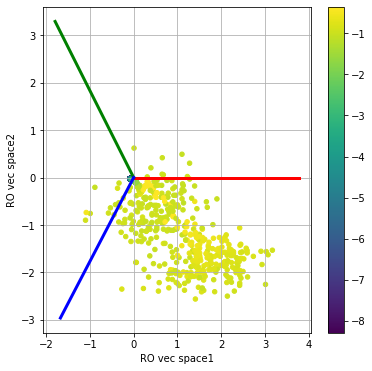

In [ ]:
# Project hidden states onto the readout space
ro1 = 0
ro2 = 1

# Creates basis vectors for the readout space
x_basis = readout[ro1] / np.linalg.norm(readout[ro1])
y_vec = readout[ro2] - np.dot(x_basis, readout[ro2]) * x_basis
y_basis = y_vec / np.linalg.norm(y_vec)
print('x', np.linalg.norm(x_basis))
print('y', np.linalg.norm(y_basis))
print('x.y', np.dot(x_basis, y_basis))

A = np.array([x_basis, y_basis]).T
proj = np.matmul(np.matmul(A, np.linalg.inv(np.matmul(A.T, A))), A.T) # 2 x n_hidden
plt.figure(figsize=(6, 6))

if rnn_specs['arch'] in ['enc_dec_atth']:
  h0_x_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0[:rnn_specs['hidden_size']], proj), y_basis)
else:
  h0_x_val = np.dot(np.matmul(h0, proj), x_basis)
  h0_y_val = np.dot(np.matmul(h0, proj), y_basis)


fps_x_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), x_basis)
fps_y_vals = np.dot(np.matmul(np.vstack(fixed_points), proj), y_basis)
plt.scatter(fps_x_vals, fps_y_vals, s=20, c=np.log10(fp_losses))
# plt.xlim(-8, 8)
# plt.ylim(-8, 8)
plt.grid()
plt.colorbar()

ro_colors = ['r', 'g', 'b', 'y', 'm']
for i in range(len(readout)):
  ro_proj = np.matmul(proj, readout[i])
  plt.plot([0, np.dot(x_basis, ro_proj)], [0, np.dot(y_basis, ro_proj)], ro_colors[i], linewidth = 3)

plt.xlabel('RO vec space1')
plt.ylabel('RO vec space2')

# plt.xlim(-7, 7)
# plt.ylim(-7, 7)

### Temporal Analysis

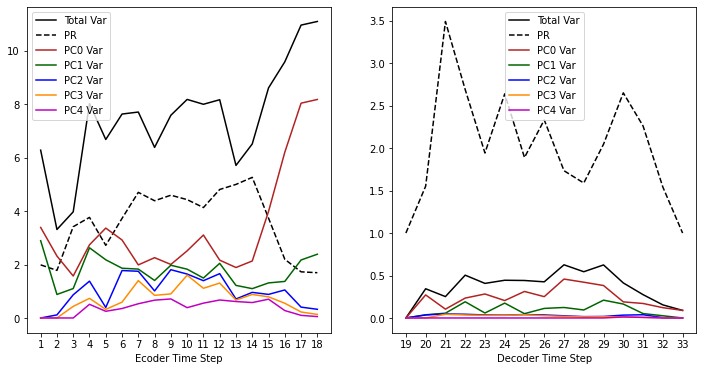

In [264]:
# Plots various variances and the participation ratio of hidden states as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

pc_dims = 5

time_var = np.zeros((hs['all'][0].shape[0]))
time_pr = np.zeros((hs['all'][0].shape[0]))
time_pc_var = np.zeros((hs['all'][0].shape[0], pc_dims))

for time_idx in range(hs['all'][0].shape[0]):
  time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
  pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
  _ = pca_time.fit_transform(time_hs)
  time_var[time_idx] = np.sum(pca_time.explained_variance_)
  time_pr[time_idx] = participation_ratio_vector(pca_time.explained_variance_)
  time_pc_var[time_idx] = pca_time.explained_variance_[:pc_dims]

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(enc_times, time_var[:enc_len], color='k', label='Total Var')
ax1.plot(enc_times, time_pr[:enc_len], color='k', linestyle='dashed', label='PR')
ax2.plot(dec_times, time_var[enc_len:], color='k', label='Total Var')
ax2.plot(dec_times, time_pr[enc_len:], color='k', linestyle='dashed', label='PR')
for i in range(pc_dims):
  ax1.plot(enc_times, time_pc_var[:enc_len, i], color=state_colors[i], label=f'PC{i} Var')
  ax2.plot(dec_times, time_pc_var[enc_len:, i], color=state_colors[i], label=f'PC{i} Var')

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_pca.py:454: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


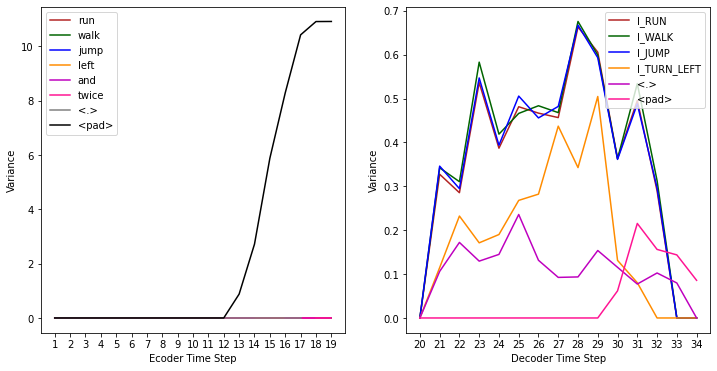

In [69]:
# Plots variances of hidden states corresponding to individual inputs/ouput words as a function of time step 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

words = np.max([len(toy_params['in_words']), len(toy_params['out_words'])])
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
all_hs_array = np.asarray(hs['all'])

word_var = np.zeros((hs['all'][0].shape[0], words))

for time_idx in range(enc_len):
  for inp_idx in range(len(toy_params['in_words_pp'])):
    time_hs = np.asarray([h for h, inp in zip(all_hs_array[:, time_idx, :], hs_data['inputs'][:, time_idx, :]) if np.argmax(inp) == inp_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    if time_hs.shape[0] > 0: # Sometimes it is not possible for words to appear at a certain input position
      _ = pca_time.fit_transform(time_hs)
      word_var[time_idx, inp_idx] = np.sum(pca_time.explained_variance_)
for time_idx in range(enc_len, enc_len+dec_len):
  for out_idx in range(len(toy_params['out_words_pp'])):
    time_hs = np.asarray([h for h, out in zip(all_hs_array[:, time_idx, :], hs_data['labels'][:, time_idx - enc_len, :]) if np.argmax(out) == out_idx]) 
    pca_time = PCA(n_components=np.min([time_hs.shape[0], rnn_specs['hidden_size']]))
    if time_hs.shape[0] > 0: # Sometimes it is not possible for words to appear at a certain output position
      _ = pca_time.fit_transform(time_hs)
      word_var[time_idx, out_idx] = np.sum(pca_time.explained_variance_)

enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
for inp_idx in range(len(toy_params['in_words_pp'])):
  ax1.plot(enc_times, word_var[:enc_len, inp_idx], color=state_colors[inp_idx], label=toy_params['in_words_pp'][inp_idx])
for out_idx in range(len(toy_params['out_words_pp'])):
  ax2.plot(dec_times, word_var[enc_len:, out_idx], color=state_colors[out_idx], label=toy_params['out_words_pp'][out_idx])

ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_ylabel('Variance')
ax2.set_ylabel('Variance')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

ax1.legend()
ax2.legend()

In [301]:
# Gets word frequencies

in_word_count = np.zeros((len(toy_params['in_words_pp'])))
out_word_count = np.zeros((len(toy_params['out_words_pp'])))

for in_idx, out_idx, input, label in zip(hs_data['in_index'], hs_data['out_index'], hs_data['inputs'], hs_data['labels']):
  in_word_count += np.sum(input[:in_idx+1], axis=0)[:len(toy_params['in_words_pp'])]
  out_word_count += np.sum(label[:out_idx+1], axis=0)[:len(toy_params['out_words_pp'])]

print('In word count:', in_word_count)
print('Out word count:', out_word_count)

In word count: [1845. 1786. 1785. 1813. 2564. 1851. 2852. 1000.]
Out word count: [2438. 2423. 2406. 1813. 2852. 1000.]


Finding average hidden state at each time step...
Finding average hidden state at each time step...


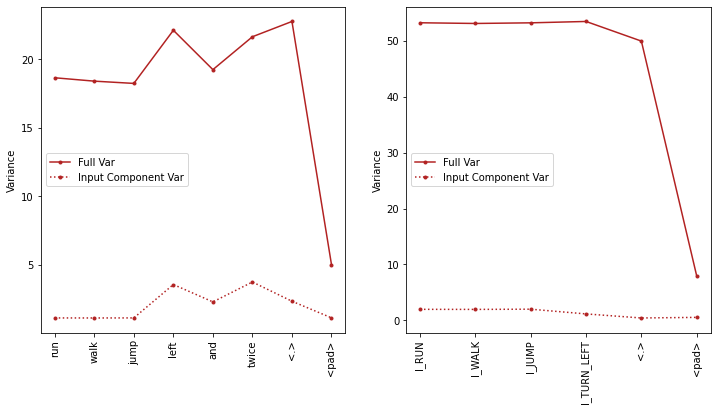

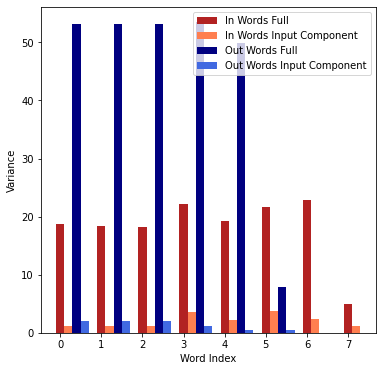

In [54]:
# Plots variance of words before and after temporal subtraction

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

hs_time_word_enc, hs_time_word_dec = sort_hs_by_time_and_word(hs, hs_data, toy_params)
hs_time_word_enc_ic, hs_time_word_dec_ic = sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=True)
avg_hs = find_avg_hs(hs, hs_data, toy_params)

word_var_enc = np.zeros((len(toy_params['in_words_pp'])))
word_var_enc_ic = np.zeros((len(toy_params['in_words_pp'])))
word_var_dec = np.zeros((len(toy_params['out_words_pp'])))
word_var_dec_ic = np.zeros((len(toy_params['out_words_pp'])))

for word_idx in range(len(toy_params['in_words_pp'])):
  word_hs = []
  word_hs_ic = []
  for time_idx in range(enc_len):
    word_hs.extend(hs_time_word_enc[time_idx][word_idx])
    word_hs_ic.extend(hs_time_word_enc_ic[time_idx][word_idx])

  word_hs = np.array(word_hs) 
  pca_word = PCA(n_components=np.min([word_hs.shape[0], rnn_specs['hidden_size']]))
  _ = pca_word.fit_transform(word_hs)
  word_var_enc[word_idx] = np.sum(pca_word.explained_variance_)

  word_hs_ic = np.array(word_hs_ic) 
  pca_word = PCA(n_components=np.min([word_hs_ic.shape[0], rnn_specs['hidden_size']]))
  _ = pca_word.fit_transform(word_hs_ic)
  word_var_enc_ic[word_idx] = np.sum(pca_word.explained_variance_)

for word_idx in range(len(toy_params['out_words_pp'])):
  word_hs = []
  word_hs_ic = []
  for time_idx in range(dec_len):
    word_hs.extend(hs_time_word_dec[time_idx][word_idx])
    word_hs_ic.extend(hs_time_word_dec_ic[time_idx][word_idx])

  word_hs = np.array(word_hs) 
  pca_word = PCA(n_components=np.min([word_hs.shape[0], rnn_specs['hidden_size']]))
  _ = pca_word.fit_transform(word_hs)
  word_var_dec[word_idx] = np.sum(pca_word.explained_variance_)

  word_hs_ic = np.array(word_hs_ic) 
  pca_word = PCA(n_components=np.min([word_hs_ic.shape[0], rnn_specs['hidden_size']]))
  _ = pca_word.fit_transform(word_hs_ic)
  word_var_dec_ic[word_idx] = np.sum(pca_word.explained_variance_)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
fig, ax3 = plt.subplots(1, 1, figsize=(6,6))

ax1.plot([i for i in range(len(toy_params['in_words_pp']))], word_var_enc, marker='.', color='firebrick',  label='Full Var')
ax1.plot([i for i in range(len(toy_params['in_words_pp']))], word_var_enc_ic, marker='.', color='firebrick', linestyle='dotted', label='Input Component Var')
ax1.set_ylabel('Variance')
ax1.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
ax1.set_xticklabels(toy_params['in_words_pp'], rotation=90)
ax1.legend()

ax2.plot([i for i in range(len(toy_params['out_words_pp']))], word_var_dec, marker='.', color='firebrick',  label='Full Var')
ax2.plot([i for i in range(len(toy_params['out_words_pp']))], word_var_dec_ic, marker='.', color='firebrick', linestyle='dotted', label='Input Component Var')
ax2.set_ylabel('Variance')
ax2.set_xticks([i for i in range(len(toy_params['out_words_pp']))])
ax2.set_xticklabels(toy_params['out_words_pp'], rotation=90)
ax2.legend()

ax3.bar([i for i in range(len(toy_params['in_words_pp']))], word_var_enc, width=0.2, color='firebrick',  label='In Words Full')
ax3.bar([i+0.2 for i in range(len(toy_params['in_words_pp']))], word_var_enc_ic, width=0.2, color='coral', linestyle='dotted', label='In Words Input Component')
ax3.bar([i+0.4 for i in range(len(toy_params['out_words_pp']))], word_var_dec, width=0.2, color='navy',  label='Out Words Full')
ax3.bar([i+0.6 for i in range(len(toy_params['out_words_pp']))], word_var_dec_ic, width=0.2, color='royalblue', linestyle='dotted', label='Out Words Input Component')
ax3.set_ylabel('Variance')
ax3.set_xlabel('Word Index')
ax3.legend()

Finding average hidden state at each time step...


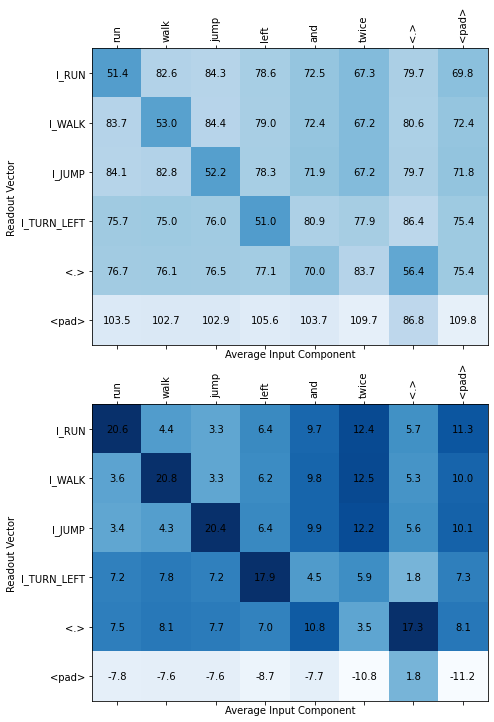

In [60]:
# Plots alignments between readout vectors and average states

def angle_degrees(a, b):
  return 180/np.pi * np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# hs_time_word_enc_ic, hs_time_word_dec_ic = sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=True)
hs_time_word_enc_ic, hs_time_word_dec_ic = sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=False)
avg_hs = find_avg_hs(hs, hs_data, toy_params)

avg_ic_enc = np.zeros((len(toy_params['in_words_pp']), rnn_specs['hidden_size']))

for word_idx in range(len(toy_params['in_words_pp'])):
  word_hs = []
  for time_idx in range(enc_len):
    word_hs.extend(hs_time_word_enc_ic[time_idx][word_idx])
  avg_ic_enc[word_idx] = np.mean(np.array(word_hs), axis=0)

readout_avg_aligns = np.zeros((readout.shape[0], len(toy_params['in_words_pp'])))
readout_avg_dots = np.zeros((readout.shape[0], len(toy_params['in_words_pp'])))

for ro_idx in range(readout.shape[0]):
  for word_idx in range(len(toy_params['in_words_pp'])):
    readout_avg_aligns[ro_idx, word_idx] = angle_degrees(readout[ro_idx], avg_ic_enc[word_idx])
    readout_avg_dots[ro_idx, word_idx] = np.dot(readout[ro_idx], avg_ic_enc[word_idx])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))

ax1.matshow(readout_avg_aligns, cmap=plt.cm.Blues_r, vmin= 0, vmax=120)
ax2.matshow(readout_avg_dots, cmap=plt.cm.Blues, vmin= -10, vmax=15)

for i in range(readout_avg_aligns.shape[1]):
  for j in range(readout_avg_aligns.shape[0]):
    c = readout_avg_aligns[j,i]
    ax1.text(i, j, str(round(c, 1)), va='center', ha='center')
    c = readout_avg_dots[j,i]
    ax2.text(i, j, str(round(c, 1)), va='center', ha='center')

for ax in (ax1, ax2):
  ax.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
  ax.set_xticklabels(toy_params['in_words_pp'], rotation=90)
  ax.set_yticks([i for i in range(len(toy_params['out_words_pp']))])
  ax.set_yticklabels(toy_params['out_words_pp'], rotation=0)
  ax.set_ylabel('Readout Vector')
  ax.set_xlabel('Average Input Component')

#### Time Averaging

Finding average hidden state at each time step...
Encoder magnitude ratio: 13.920003548682917
Decoder magnitude ratio: 26.715880864445158
Attention matrix \ Max: 0.915896265260274 \ Min: 1.220483976572137e-25
Attention null \ Max: 0.7556260824203491 \ Min: 2.0570591187295763e-26
Var ex ratios: [0.37929002 0.27129198 0.23854404 0.04635677 0.03782   ]
PR: 3.4083210102812287


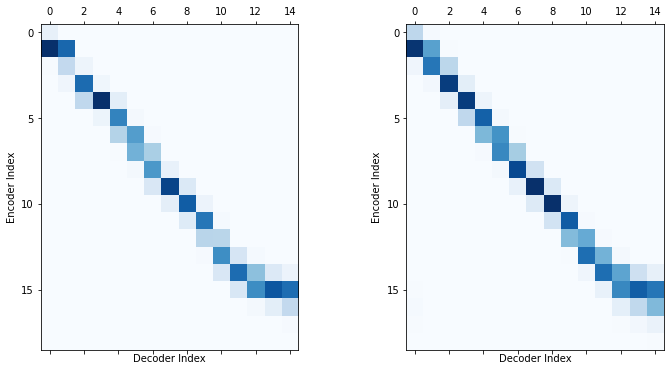

In [36]:
# Checks to see if attention matrix can be explained by average of hidden states at a given time step
from scipy.special import softmax

def find_avg_hs(hs, hs_data, toy_params):
  """ Finds the average hidden states, accounting for pads """

  print('Finding average hidden state at each time step...')

  enc_len = hs_data['inputs'][0].shape[0]
  dec_len = hs_data['labels'][0].shape[0]

  avg_hs = np.zeros((hs['all'][0].shape))
  pad_in_idx = toy_params['in_words'].index('<pad>')
  pad_out_idx = toy_params['out_words'].index('<pad>')

  for time_idx in range(hs['all'][0].shape[0]):
    if time_idx < enc_len: # Encoder
      time_hs = []
      for h, inp in zip(hs['all'], hs_data['inputs']):
        if time_idx > 0:
          if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
            time_hs.append(h[time_idx])
        else: # Automatically adds if first index
          time_hs.append(h[time_idx])
      time_hs = np.asarray(time_hs)
    else: # Decoder
      time_hs = []
      for h, out in zip(hs['all'], hs_data['labels']):
        if time_idx - enc_len> 0:
          if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
            time_hs.append(h[time_idx])
        else: # Automatically adds if first index
          time_hs.append(h[time_idx])
      time_hs = np.asarray(time_hs)
    if time_hs.shape[0] > 0:
      avg_hs[time_idx] = np.mean(time_hs, axis=0)
    else:
      print('Zero length')

  return avg_hs

def angle_degrees(a, b):
  return 180/np.pi * np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

avg_hs = find_avg_hs(hs, hs_data, toy_params)
hs_inputs = np.asarray([h - avg_hs for h in hs['all']])

print('Encoder magnitude ratio:', np.mean(np.linalg.norm(avg_hs[:enc_len]))/np.mean(np.linalg.norm(hs_inputs[:, :enc_len, :], axis=2)))
print('Decoder magnitude ratio:', np.mean(np.linalg.norm(avg_hs[enc_len:]))/np.mean(np.linalg.norm(hs_inputs[:, enc_len:, :], axis=2)))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# Attention matrix from mean input states
attn_matrix = np.zeros((enc_len, dec_len))
enc_seq = avg_hs[:enc_len, :]
for seq_idx in range(dec_len):
  attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, avg_hs[enc_len + seq_idx, :]))

# Attention matrix from null input
attn_matrix_null = np.zeros((enc_len, dec_len))
enc_seq = hs['special'][-1][:enc_len, :]
for seq_idx in range(dec_len):
  attn_matrix_null[:, seq_idx] = softmax(np.dot(enc_seq, hs['special'][-1][enc_len + seq_idx, :]))

print(f'Attention matrix \\ Max: {np.max(attn_matrix)} \\ Min: {np.min(attn_matrix)}')
ax1.matshow(attn_matrix, cmap=plt.cm.Blues)
ax1.set_ylabel('Encoder Index')
ax1.set_xlabel('Decoder Index')

print(f'Attention null \\ Max: {np.max(attn_matrix_null)} \\ Min: {np.min(attn_matrix_null)}')
ax2.matshow(attn_matrix_null, cmap=plt.cm.Blues)
ax2.set_ylabel('Encoder Index')
ax2.set_xlabel('Decoder Index')

# pca_avg = PCA(n_components=np.min([avg_hs.shape[0], rnn_specs['hidden_size']]))
pca_avg = PCA(n_components=5)
_ = pca_avg.fit_transform(avg_hs[:]).T
pca_avg_hs = pca_avg.transform(avg_hs).T
pca_avg_input = pca_avg.transform(hs['special'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', participation_ratio_vector(pca_avg.explained_variance_))

In [37]:
# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder

avg_hs = find_avg_hs(hs, hs_data, toy_params)

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]
pad_in_idx = toy_params['in_words_pp'].index('<pad>')
pad_out_idx = toy_params['out_words_pp'].index('<pad>')
# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - temporal_hs for h in hs['all']]

hs_inputs = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_outputs = [[] for _ in range(len(toy_params['out_words_pp']))]
hs_inputs_bare = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_outputs_bare = [[] for _ in range(len(toy_params['out_words_pp']))]
for hs_idx in range(len(hs['all'])):
  if hs_idx % 100 == 0: print(hs_idx)
  max_in = hs_data['in_index'][hs_idx] + 1
  max_out = enc_len + hs_data['out_index'][hs_idx] + 1
  for inp_idx in range(len(toy_params['in_words_pp'])):
    for h, hb, inp in zip(hs_mod_pos_enc[hs_idx][:max_in], hs['all'][hs_idx][:max_in], hs_data['inputs'][hs_idx][:max_in]):
      if np.argmax(inp) == inp_idx:
         hs_inputs[inp_idx].append(h)
         hs_inputs_bare[inp_idx].append(hb)
  for out_idx in range(len(toy_params['out_words_pp'])):
    for h, hb, out in zip(hs_mod_pos_enc[hs_idx][enc_len:max_out], hs['all'][hs_idx][enc_len:max_out], hs_data['labels'][hs_idx][:max_out-enc_len]):
      if np.argmax(out) == out_idx:
         hs_outputs[out_idx].append(h)
         hs_outputs_bare[out_idx].append(hb)

Finding average hidden state at each time step...
Using true average hidden state as temporal part
0
100
200
300
400
500
600
700
800
900


Var ex ratios: [0.37929002 0.27129198 0.23854404 0.04635677 0.03782   ]
PR: 3.5962091237916867


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


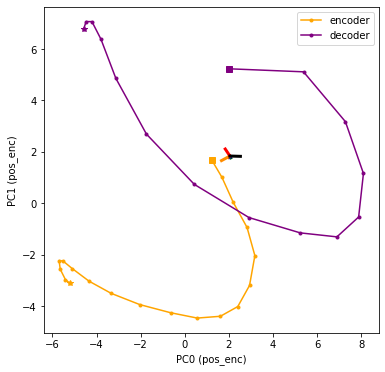

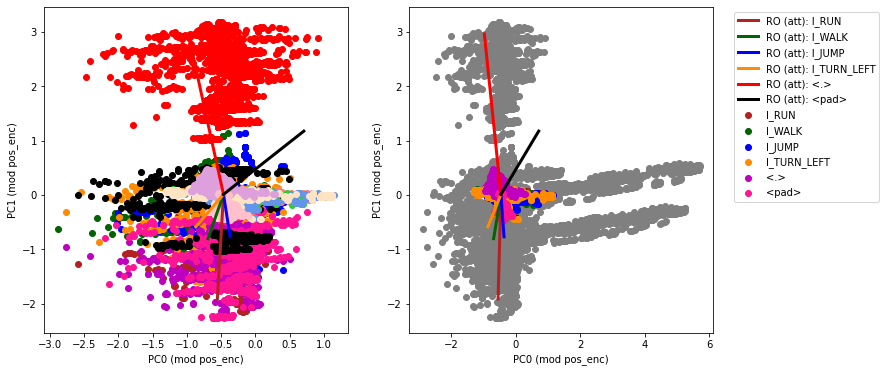

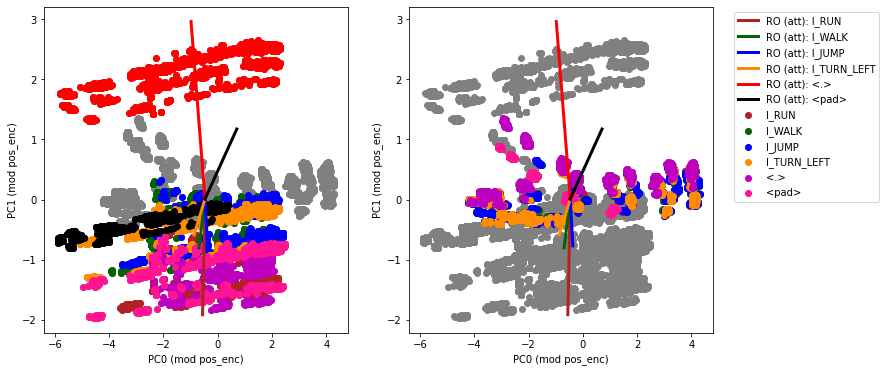

In [38]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))
fig2, (ax2, ax3) = plt.subplots(1, 2, figsize=(12, 6))
fig3, (ax4, ax5) = plt.subplots(1, 2, figsize=(12, 6))

##### Plotting for temporal part #####

pts_subset = 'all'

pc1 = 0
pc2 = 1

# pca_avg = PCA(n_components=5)
if pts_subset == 'enc': # Fits PCA to only enecoder hidden states
  pca_avg = PCA(n_components=np.min([temporal_hs[:enc_len].shape[0], rnn_specs['hidden_size']]))
  _ = pca_avg.fit(temporal_hs[:enc_len])
  pca_avg_hs = pca_avg.transform(temporal_hs).T
elif pts_subset == 'all':
  pca_avg = PCA(n_components=np.min([temporal_hs.shape[0], rnn_specs['hidden_size']]))
  pca_avg_hs = pca_avg.fit_transform(temporal_hs).T
pca_mod_pe_hs = pca_avg.transform(np.vstack(hs_mod_pos_enc)).T
pca_avg_input = pca_avg.transform(hs['special'][-2]).T
pca_null_input = pca_avg.transform(hs['special'][-1]).T
print('Var ex ratios:', pca_avg.explained_variance_ratio_[:5])
print('PR:', participation_ratio_vector(pca_avg.explained_variance_))

ax1.plot(pca_avg_hs[pc1,:enc_len], pca_avg_hs[pc2,:enc_len], marker='.', color='orange', label='encoder')
ax1.plot(pca_avg_hs[pc1,enc_len:], pca_avg_hs[pc2,enc_len:], marker='.', color='purple', label='decoder')
# Squares at start of each
ax1.plot(pca_avg_hs[pc1,0], pca_avg_hs[pc2,0], marker='s', color='orange')
ax1.plot(pca_avg_hs[pc1,enc_len], pca_avg_hs[pc2,enc_len], marker='s', color='purple')
# Stars at the end
ax1.plot(pca_avg_hs[pc1,enc_len-1], pca_avg_hs[pc2,enc_len-1], marker='*', color='orange')
ax1.plot(pca_avg_hs[pc1,-1], pca_avg_hs[pc2,-1], marker='*', color='purple')

# ax1.plot(pca_avg_input[pc1,:enc_len], pca_avg_input[pc2,:enc_len], color='orange', linestyle='dashed', label='encoder (avg inp)')
# ax1.plot(pca_avg_input[pc1,enc_len:], pca_avg_input[pc2,enc_len:], color='purple', linestyle='dashed', label='decoder (avg inp)')
# ax1.plot(pca_null_input[pc1,:enc_len], pca_null_input[pc2,:enc_len], color='red', linestyle='dashed', label='encoder (zero inp)')
# ax1.plot(pca_null_input[pc1,enc_len:], pca_null_input[pc2,enc_len:], color='green', linestyle='dashed', label='decoder (zero inp)')
ax1.legend()

ax1.set_xlabel('PC'+str(pc1)+' (pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (pos_enc)')

# Plots readout direction
readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_color_idxs = [0, 1, 2, 3, 6, 7]
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_avg.transform(readout_plot)
  pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  # pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T

  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    ax1.plot(x_ro, y_ro, color=state_colors[ro_color_idxs[i]], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])
if pts_subset == 'enc': # Fits PCA to only enecoder hidden states
  _ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
  pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T
elif pts_subset == 'all':
  pca_mod_pe_hs = pca_mod_pe.fit_transform(np.vstack(hs_mod_pos_enc)).T
pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
# ax2.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax4.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for inp_idx in range(len(toy_params['in_words_pp'])):
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_inputs[inp_idx])).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_word = pca_mod_pe.transform(np.vstack(hs_inputs_bare[inp_idx])).T
  ax4.scatter(pca_word[pc1], pca_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
for out_idx in range(len(toy_params['out_words_pp'])):
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_outputs[out_idx])).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors_light[out_idx])


ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
ax5.scatter(pca_hs[pc1], pca_hs[pc2], color='grey')
for out_idx in range(len(toy_params['out_words_pp'])):
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_outputs[out_idx])).T
  ax3.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])
  pca_word = pca_mod_pe.transform(np.vstack(hs_outputs_bare[out_idx])).T
  ax5.scatter(pca_word[pc1], pca_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Average directions of hidden states for encoder/decoder (used to project readouts)
avg_enc = np.mean(temporal_hs[:enc_len], axis=0)
avg_dec = np.mean(temporal_hs[enc_len:], axis=0)
avg_enc_dir = avg_enc/(np.linalg.norm(avg_enc))
avg_dec_dir = avg_dec/(np.linalg.norm(avg_dec))

# Plots readout direction
readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_mod_pe.transform(readout_plot)
  pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  # pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((2*rnn_specs['hidden_size'],)))).T
  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    for ax in [ax2, ax3, ax4, ax5]:
      ax.plot(x_ro, y_ro, color=state_colors[ro_color_idxs[i]], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

# ax2.legend()
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax5.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in [ax2, ax3, ax4, ax5]:
  ax.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
  ax.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

for ax in [ax1, ax2]:
  plt_lim = None
  if plt_lim != None:
    ax.xlim(-plt_lim, plt_lim)
    ax.ylim(-plt_lim, plt_lim)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


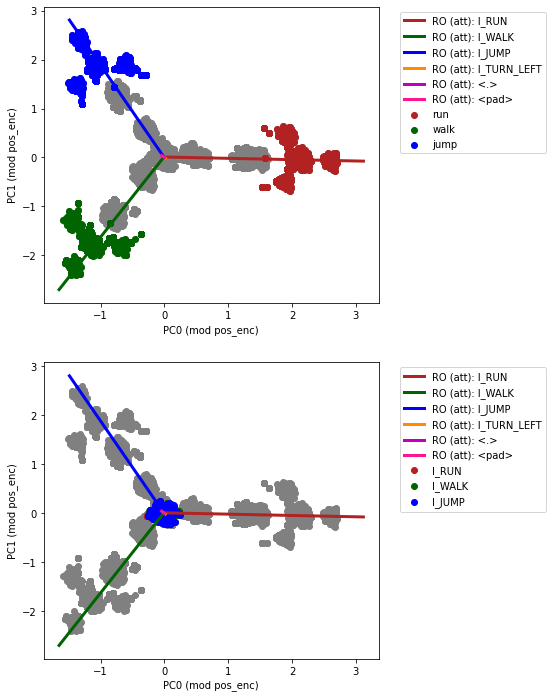

In [39]:
# Plot using a more specific PCA

fig2, (ax2, ax3) = plt.subplots(2, 1, figsize=(6, 12))

words_in_pca = ['run', 'walk', 'jump']
words_in_pca_idxs = [toy_params['in_words_pp'].index(word) for word in words_in_pca]
pca_list = []
for inp_idx in words_in_pca_idxs:
  pca_list = pca_list + hs_inputs[inp_idx]

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])
_ = pca_mod_pe.fit(np.vstack(np.asarray(pca_list)))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

ax2.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
# for inp_idx in range(len(toy_params['in_words_pp'])):
for inp_idx in words_in_pca_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_inputs[inp_idx])).T
  ax2.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])

ax3.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')
# for out_idx in range(len(toy_params['out_words_pp'])):
for out_idx in words_in_pca_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_outputs[out_idx])).T
  ax3.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[out_idx], label=toy_params['out_words'][out_idx])

# Plots readout direction
readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
ro_styles = ['solid', 'dotted', 'dashed']
for idx in range(len(readout_types)):
  if readout_types[idx] == 'att':
    readout_plot = readout 
    # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
  elif readout_types[idx] == 'hs':
    readout_plot = readout_dec
    # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
  elif readout_types[idx] == 'sum':
    readout_plot = readout + readout_dec
  pca_ro = pca_mod_pe.transform(readout_plot)
  pca_zero = pca_mod_pe.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
  for i in range(readout_plot.shape[0]):
    x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
    y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
    for ax in [ax2, ax3, ax4, ax5]:
      ax.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
              label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for ax in [ax2, ax3]:
  ax.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
  ax.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

Using true average hidden state as temporal part


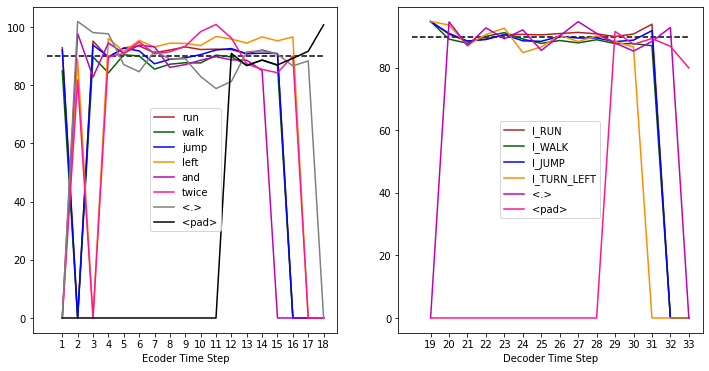

In [265]:
# Checks average dot products between temporal part and non-temporal part
def angle_degrees(a, b):
  norm_a = np.linalg.norm(a)
  norm_b = np.linalg.norm(b)
  # if norm_a == 0.0: raise ValueError('a zero Norm!')
  # if norm_b == 0.0: raise ValueError('b zero Norm!')
  return 180/np.pi * np.arccos(np.dot(a, b)/(norm_a*norm_b))
def proj_perc(a, b):
  """ Projects a onto b and then sees what percentage of magnitude lives in space """
  norm_a = np.linalg.norm(a)
  norm_proj_a = np.linalg.norm(a - np.dot(a, b) * (b / np.linalg.norm(b)))
  return norm_proj_a/norm_a

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>')

avg_angle_enc = np.zeros((len(toy_params['in_words_pp']), enc_len))
avg_angle_dec = np.zeros((len(toy_params['out_words_pp']), dec_len))

for time_idx in range(enc_len): # Encoder
  time_hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
  for h, inp in zip(hs['all'], hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        time_hs_word[np.argmax(inp[time_idx])].append(h[time_idx])
    else: # Automatically adds if first index
      time_hs_word[np.argmax(inp[time_idx])].append(h[time_idx])
  for word_idx in range(len(time_hs_word)):
    if len(time_hs_word[word_idx]) > 0:
      time_word_array = np.asarray(time_hs_word[word_idx])
      angles = np.asarray([angle_degrees(hid - temporal_hs[time_idx], temporal_hs[time_idx]) for hid in time_word_array])
      # angles = np.asarray([proj_perc(hid - temporal_hs[time_idx], temporal_hs[time_idx]) for hid in time_word_array])
      avg_angle_enc[word_idx, time_idx] = np.mean(angles, axis=0)
for time_idx in range(dec_len): # Decoder
  time_hs_word = [[] for _ in range(len(toy_params['out_words_pp']))]
  for h, out in zip(hs['all'], hs_data['labels']):
    if time_idx > 0:
      if np.argmax(out[time_idx]) != pad_out_idx or np.argmax(out[time_idx-1]) != pad_out_idx:
        time_hs_word[np.argmax(out[time_idx])].append(h[enc_len + time_idx])
    else: # Automatically adds if first index
      time_hs_word[np.argmax(out[time_idx])].append(h[enc_len + time_idx])
  for word_idx in range(len(time_hs_word)):
    if len(time_hs_word[word_idx]) > 0:
      time_word_array = np.asarray(time_hs_word[word_idx])
      # if (time_word_array == temporal_hs[enc_len + time_idx]).any():
      #   raise ValueError('Output is same as null')
      angles = np.asarray([angle_degrees(hid - temporal_hs[enc_len + time_idx], temporal_hs[enc_len + time_idx]) for hid in time_word_array])
      # angles = np.asarray([proj_perc(hid - temporal_hs[enc_len + time_idx], temporal_hs[enc_len + time_idx]) for hid in time_word_array])
      avg_angle_dec[word_idx, time_idx] = np.mean(angles, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
enc_times = [i+1 for i in range(enc_len)]
dec_times = [i+1+enc_len for i in range(dec_len)]
for word_idx in range(len(toy_params['in_words_pp'])):
  ax1.plot(enc_times, avg_angle_enc[word_idx], color=state_colors[word_idx], label=toy_params['in_words_pp'][word_idx])
for word_idx in range(len(toy_params['out_words_pp'])):
  ax2.plot(dec_times, avg_angle_dec[word_idx], color=state_colors[word_idx], label=toy_params['out_words_pp'][word_idx])

ax1.hlines(90.0, 0, enc_len, color='k', linestyle='dashed')
ax2.hlines(90.0, enc_len, enc_len+dec_len, color='k', linestyle='dashed')
ax1.set_xlabel('Ecoder Time Step')
ax2.set_xlabel('Decoder Time Step')
ax1.set_xticks(enc_times)
ax2.set_xticks(dec_times)

# ax1.set_ylim([80, 100])
# ax2.set_ylim([80, 100])

ax1.legend()
ax2.legend()

Text(0, 0.5, 'PC1 (pos_enc)')

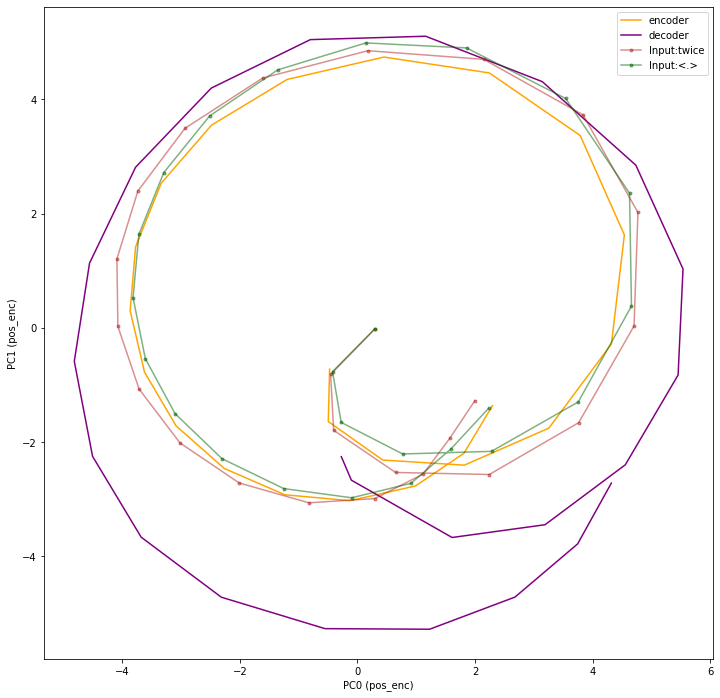

In [ ]:
"Plots some example paths in the temporal subspace

pts_subset = 'enc'

fig1, ax1 = plt.subplots(1, 1, figsize=(12, 12))

pc1 = 0
pc2 = 1

if pts_subset in ['all', 'enc']:
  ax1.plot(pca_avg_hs[pc1,:enc_len], pca_avg_hs[pc2,:enc_len], color='orange', label='encoder')
  # ax1.plot(pca_avg_input[pc1,:enc_len], pca_avg_input[pc2,:enc_len], color='orange', linestyle='dashed', label='encoder (avg inp)')
if pts_subset in ['all', 'dec', 'enc']:
  ax1.plot(pca_avg_hs[pc1,enc_len:], pca_avg_hs[pc2,enc_len:], color='purple', label='decoder')
  # ax1.plot(pca_avg_input[pc1,enc_len:], pca_avg_input[pc2,enc_len:], color='purple', linestyle='dashed', label='decoder (avg inp)')

pca_h0 = pca_avg.transform(np.atleast_2d(h0)).T

hs_idxs = [] # [5, 6, 7] # [0]
for hs_idx in hs_idxs: # Plots example paths
  print('Example phrase length:', hs_data['index'][hs_idx])
  print('Example phrase:', tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
  if pts_subset in ['enc', 'all']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs[pts_subset][hs_idx]).T), axis=1) 
  if pts_subset in ['dec', 'all']:  # Puts star on final hidden state
    pca_decf = pca_avg.transform(np.atleast_2d(hs['decf'][hs_idx])).T
    ax1.scatter(pca_decf[pc1], pca_decf[pc2], color = 'k', marker='*', 
                s=100.0, alpha=1.0)
  if pts_subset == 'all':
    ax1.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[hs_idxs.index(hs_idx)], marker=None, alpha=1.0,
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    ax1.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[hs_idxs.index(hs_idx)], marker=None, alpha=1.0)
  else:
    ax1.plot(pca_state[pc1], pca_state[pc2], color = state_colors[hs_idxs.index(hs_idx)], marker='.', alpha=0.5, 
             label=tensorToPhrase(hs_data['inputs'][hs_idx], toy_params['in_words']))
    
# Special inputs
pos_enc_idxs = [3, 4]
for pos_enc_idx in pos_enc_idxs:
  if pts_subset in ['all']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs['pos_enc'][pos_enc_idx]).T), axis=1)
    ax1.plot(pca_state[pc1][:pl+1], pca_state[pc2][:pl+1], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], 
             marker=None, alpha=1.0, label='Input:' + toy_params['in_words'][pos_enc_idx])
    ax1.plot(pca_state[pc1][pl:], pca_state[pc2][pl:], color = state_colors_light[pos_enc_idxs.index(pos_enc_idx)],
             marker=None, alpha=1.0)
  elif pts_subset in ['enc']: # Adds h0 to path
    pca_state = np.concatenate((pca_h0, pca_avg.transform(hs['special'][pos_enc_idx][:enc_len]).T), axis=1)
    ax1.plot(pca_state[pc1], pca_state[pc2], color = state_colors[pos_enc_idxs.index(pos_enc_idx)], marker='.', 
             alpha=0.5, label='Input:' + toy_params['in_words'][pos_enc_idx]) 

ax1.legend()
ax1.set_xlabel('PC'+str(pc1)+' (pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (pos_enc)')

In [ ]:
# Analyzing average encoder/decoder hidden states without he time-average
avg_word_vec_enc = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_inputs)))
avg_word_vec_dec = np.asarray(list(map(lambda l: np.mean(np.asarray(l), axis=0), hs_outputs)))

enc_vec_mags = []
for i in range(avg_word_vec_enc.shape[0]):
  enc_vec_mags.append(np.linalg.norm(avg_word_vec_enc[i]))
  print(f'Encoder vec {i} mag:', enc_vec_mags[i])
dec_vec_mags = []
for i in range(avg_word_vec_dec.shape[0]):
  dec_vec_mags.append(np.linalg.norm(avg_word_vec_dec[i]))
  print(f'Decoder vec {i} mag:', dec_vec_mags[i])

for i in range(avg_word_vec_enc.shape[0]):
  for j in range(i):
    print('Enc Angle ({}, {}):'.format(toy_params['in_words'][i], toy_params['in_words'][j]), 180/np.pi * np.arccos(np.dot(avg_word_vec_enc[i], avg_word_vec_enc[j])/(enc_vec_mags[i]*enc_vec_mags[j])))
for i in range(avg_word_vec_dec.shape[0]):
  for j in range(i):
    print('Dec Angle ({}, {}):'.format(toy_params['out_words'][i], toy_params['out_words'][j]), 180/np.pi * np.arccos(np.dot(avg_word_vec_dec[i], avg_word_vec_dec[j])/(dec_vec_mags[i]*dec_vec_mags[j])))

ro_subspace_analysis(avg_word_vec_enc)
ro_subspace_analysis(avg_word_vec_dec)


Encoder vec 0 mag: 2.480907242977628
Encoder vec 1 mag: 2.563709742418082
Encoder vec 2 mag: 3.1087776445854067
Encoder vec 3 mag: 2.4286292188779766
Encoder vec 4 mag: 1.6385918977157738
Encoder vec 5 mag: 2.8367859323494153
Decoder vec 0 mag: 0.5900644340770043
Decoder vec 1 mag: 0.5797797786816894
Decoder vec 2 mag: 0.5744389197076835
Decoder vec 3 mag: 1.3642710648103895
Decoder vec 4 mag: 0.874456118155978
Decoder vec 5 mag: 0.8538030736276189
Decoder vec 6 mag: 0.5616385893311335
Enc Angle (walk, run): 98.65153220416849
Enc Angle (exercise, run): 103.67359581231544
Enc Angle (exercise, walk): 108.19445166500758
Enc Angle (left, run): 88.0109383130951
Enc Angle (left, walk): 91.84856906315059
Enc Angle (left, exercise): 97.01232867766201
Enc Angle (<.>, run): 109.59557601914719
Enc Angle (<.>, walk): 102.56206001875826
Enc Angle (<.>, exercise): 105.09181200032906
Enc Angle (<.>, left): 133.311673722844
Enc Angle (<pad>, run): 84.8881621597011
Enc Angle (<pad>, walk): 77.545603892

NameError: ignored

In [40]:
# Calculate alignments by hand via hidden states and then decomposes maxiumum dot product

from scipy.special import softmax

print('Using true average hidden state as temporal part')
temporal_hs = avg_hs
# print('Using null input hidden state as temporal part')
# temporal_hs = hs['special'][-1]

print('Single sequence shape:', hs['all'][0].shape)
enc_len = hs_data['inputs'][0].shape[0]
dec_len =  hs_data['labels'][0].shape[0]
attention_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
# First index corresponds to maximum alignment, second corresponds to diagonal alignment
enc_dec_dots = np.zeros((len(hs['all']), dec_len, 2))
enct_dect = np.zeros((len(hs['all']), dec_len, 2))
encw_decw = np.zeros((len(hs['all']), dec_len, 2))
enct_decw = np.zeros((len(hs['all']), dec_len, 2))
encw_dect = np.zeros((len(hs['all']), dec_len, 2))

for h_idx in range(len(hs['all'])):
  if h_idx % 100 == 0: print(h_idx)
  enc_seq = hs['all'][h_idx][:enc_len]
  for seq_idx in range(dec_len):
    raw_aligns = np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx])
    # Masks if beyond in_index length
    raw_aligns[hs_data['in_index'][h_idx]+1:] = -10000 * np.ones((enc_len - hs_data['in_index'][h_idx]-1))
    
    max_align_idx = np.argmax(raw_aligns)
    
    word_enc = enc_seq[max_align_idx] - temporal_hs[max_align_idx]
    word_dec = hs['all'][h_idx][enc_len + seq_idx] - temporal_hs[enc_len + seq_idx]

    enc_dec_dots[h_idx, seq_idx, 0] = np.max(raw_aligns)
    enct_dect[h_idx, seq_idx, 0]  = np.dot(temporal_hs[max_align_idx], temporal_hs[enc_len + seq_idx])
    encw_decw[h_idx, seq_idx, 0]  = np.dot(word_enc, word_dec)
    enct_decw[h_idx, seq_idx, 0]  = np.dot(temporal_hs[max_align_idx], word_dec)
    encw_dect[h_idx, seq_idx, 0]  = np.dot(word_enc, temporal_hs[enc_len + seq_idx])
  for seq_idx in range(np.min([dec_len, enc_len])):
    word_enc = enc_seq[seq_idx] - temporal_hs[seq_idx]
    word_dec = hs['all'][h_idx][enc_len + seq_idx] - temporal_hs[enc_len + seq_idx]

    if raw_aligns[seq_idx] > -1000:
      enc_dec_dots[h_idx, seq_idx, 1]  = raw_aligns[seq_idx]
      enct_dect[h_idx, seq_idx, 1]  = np.dot(temporal_hs[seq_idx], temporal_hs[enc_len + seq_idx])
      encw_decw[h_idx, seq_idx, 1]  = np.dot(word_enc, word_dec)
      enct_decw[h_idx, seq_idx, 1]  = np.dot(temporal_hs[seq_idx], word_dec)
      encw_dect[h_idx, seq_idx, 1]  = np.dot(word_enc, temporal_hs[enc_len + seq_idx])


Using true average hidden state as temporal part
Single sequence shape: (34, 256)
0
100
200
300
400
500
600
700
800
900


Temporal Dot / Total: 0.9605736787648201
Input Dot / Total: 0.0004024207283940617
Enc time . dec input / Total: -0.02918629897709157
Enc input . dec time / Total: 0.06821020023471396


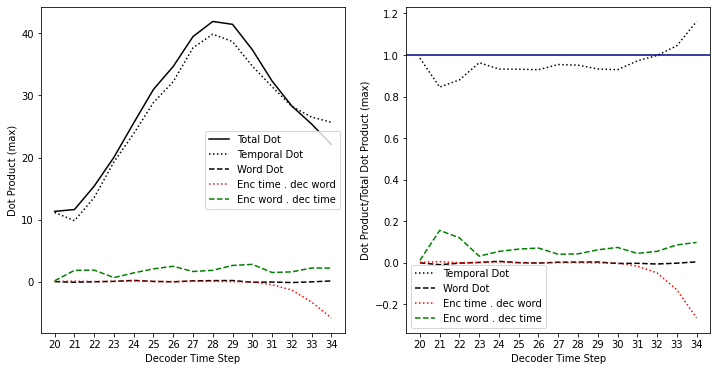

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plt_type = 'max' # 'diag'
plt_idx = 0 if plt_type == 'max' else 1

print('Temporal Dot / Total:', np.mean(np.mean(enct_dect, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx]))
print('Input Dot / Total:', np.mean(np.mean(encw_decw, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx]))
print('Enc time . dec input / Total:', np.mean(np.mean(enct_decw, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx]))
print('Enc input . dec time / Total:', np.mean(np.mean(encw_dect, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx]))

dec_times = [i+1+enc_len for i in range(dec_len)]
ax1.plot(dec_times, np.mean(enc_dec_dots, axis=0)[:, plt_idx], color='k', label='Total Dot')
ax1.plot(dec_times, np.mean(enct_dect, axis=0)[:, plt_idx], color='k', linestyle='dotted', label='Temporal Dot')
ax1.plot(dec_times, np.mean(encw_decw, axis=0)[:, plt_idx], color='k', linestyle='dashed', label='Word Dot')
ax1.plot(dec_times, np.mean(enct_decw, axis=0)[:, plt_idx], color='r', linestyle='dotted', label='Enc time . dec word')
ax1.plot(dec_times, np.mean(encw_dect, axis=0)[:, plt_idx], color='g', linestyle='dashed', label='Enc word . dec time')
ax2.plot(dec_times, np.mean(enct_dect, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx], color='k', linestyle='dotted', label='Temporal Dot')
ax2.plot(dec_times, np.mean(encw_decw, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx], color='k', linestyle='dashed', label='Word Dot')
ax2.plot(dec_times, np.mean(enct_decw, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx], color='r', linestyle='dotted', label='Enc time . dec word')
ax2.plot(dec_times, np.mean(encw_dect, axis=0)[:, plt_idx]/np.mean(enc_dec_dots, axis=0)[:, plt_idx], color='g', linestyle='dashed', label='Enc word . dec time')

ax1.set_xlabel('Decoder Time Step')
ax1.set_ylabel(f'Dot Product ({plt_type})')
ax1.set_xticks(dec_times)

ax2.set_xlabel('Decoder Time Step')
ax2.set_ylabel(f'Dot Product/Total Dot Product ({plt_type})')
ax2.set_xticks(dec_times)
ax2.axhline(1.0, color='darkblue')

ax1.legend()
ax2.legend()

#### Modifier Word Analyses

In [43]:
# Using the test phrases, finds the average hidden state for each time step for each word

def sort_hs_by_time_and_word(hs, hs_data, toy_params, subtract_avg=False):
  """ Returns two nested lists of hidden states, one for the encoder and decoder.
  They are each indexed as [time_idx][word_idx]. Can optionally subtract average
  hidden state from all hidden states. """

  enc_len = hs_data['inputs'][0].shape[0]
  dec_len = hs_data['labels'][0].shape[0]
  
  if subtract_avg:
    avg_hs = find_avg_hs(hs, hs_data, toy_params)
    hidden_states = [h - avg_hs  for h in hs['all']]
  else:
    hidden_states = hs['all']

  hs_time_word_enc = [[[] for _ in range(len(toy_params['in_words_pp']))] for _ in range(enc_len)]
  hs_time_word_dec = [[[] for _ in range(len(toy_params['out_words_pp']))] for _ in range(dec_len)]

  pad_in_idx = toy_params['in_words'].index('<pad>')
  pad_out_idx = toy_params['out_words'].index('<pad>') 

  for time_idx in range(enc_len): # Encoder
    # time_hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
    for h, inp in zip(hidden_states, hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          hs_time_word_enc[time_idx][np.argmax(inp[time_idx])].append(h[time_idx])
      else: # Automatically adds if first index
        hs_time_word_enc[time_idx][np.argmax(inp[time_idx])].append(h[time_idx])
  for time_idx in range(dec_len): # Decoder
    # time_hs_word = [[] for _ in range(len(toy_params['out_words_pp']))]
    for h, out in zip(hidden_states, hs_data['labels']):
      if time_idx > 0:
        if np.argmax(out[time_idx]) != pad_out_idx or np.argmax(out[time_idx-1]) != pad_out_idx:
          hs_time_word_dec[time_idx][np.argmax(out[time_idx])].append(h[enc_len + time_idx])
      else: # Automatically adds if first index
        hs_time_word_dec[time_idx][np.argmax(out[time_idx])].append(h[enc_len + time_idx])

  return hs_time_word_enc, hs_time_word_dec

hs_time_word_enc, hs_time_word_dec = sort_hs_by_time_and_word(hs, hs_data, toy_params)

avg_hs = find_avg_hs(hs, hs_data, toy_params)

avg_hs_word_enc = np.zeros((len(toy_params['in_words_pp']), enc_len, rnn_specs['hidden_size']))
avg_hs_word_dec = np.zeros((len(toy_params['out_words_pp']), dec_len, rnn_specs['hidden_size']))

for time_idx in range(enc_len): # Encoder
  for word_idx in range(len(hs_time_word_enc[time_idx])):
    if len(hs_time_word_enc[time_idx][word_idx]) > 0:
      avg_hs_word_enc[word_idx, time_idx, :] = np.mean(np.asarray(hs_time_word_enc[time_idx][word_idx]), axis=0)
for time_idx in range(dec_len): # Decoder
  for word_idx in range(len(hs_time_word_dec[time_idx])):
    if len(hs_time_word_dec[time_idx][word_idx]) > 0:
      avg_hs_word_dec[word_idx, time_idx, :] = np.mean(np.asarray(hs_time_word_dec[time_idx][word_idx]), axis=0)

print('Done')

Finding average hidden state at each time step...
Done


In [73]:
for i in range(len(toy_params['in_words_pp'])):
  word_input = avg_hs_word_enc[i] - avg_hs[:enc_len]
  print('Word {} in mag:'.format(toy_params['in_words_pp'][i]), np.mean(np.linalg.norm(word_input, axis=1)))
  print('Word {} full mag:'.format(toy_params['in_words_pp'][i]), np.mean(np.linalg.norm(avg_hs_word_enc[i], axis=1)))
for i in range(len(toy_params['out_words_pp'])):
  word_input = avg_hs_word_dec[i] - avg_hs[enc_len:]
  print('Word {} in mag:'.format(toy_params['out_words_pp'][i]), np.mean(np.linalg.norm(word_input, axis=1)))
  print('Word {} full mag:'.format(toy_params['out_words_pp'][i]), np.mean(np.linalg.norm(avg_hs_word_dec[i], axis=1)))

for i in range(len(toy_params['in_words_pp'])):
  enc_word_input = avg_hs_word_enc[i] - avg_hs[:enc_len]
  dec_word_input = avg_hs_word_dec[i] - avg_hs[enc_len:]
  print('Word Dot {} and {}:'.format(toy_params['in_words_pp'][i], toy_params['out_words_pp'][i]), 
        np.mean([np.dot(ew, dw) for ew, dw in zip(enc_word_input, dec_word_input)]))

Word run in mag: 4.210326823340248
Word run full mag: 5.921070190145967
Word walk in mag: 4.21997496168575
Word walk full mag: 6.072807508657176
Word jump in mag: 4.0363925571617285
Word jump full mag: 6.392227521889953
Word left in mag: 4.121779331327723
Word left full mag: 6.242415305025892
Word and in mag: 3.485307575165261
Word and full mag: 5.798109312866551
Word twice in mag: 3.676875800621792
Word twice full mag: 5.759303021130434
Word <.> in mag: 2.8891321604437983
Word <.> full mag: 7.053072281654585
Word <pad> in mag: 4.805754736185588
Word <pad> full mag: 3.05177529470647
Word I_RUN in mag: 0.8090669365389119
Word I_RUN full mag: 4.621917999531918
Word I_WALK in mag: 0.8007830392074405
Word I_WALK full mag: 4.633314031257796
Word I_JUMP in mag: 0.7910623797751611
Word I_JUMP full mag: 4.629019444667566
Word I_TURN_LEFT in mag: 1.2435379854185475
Word I_TURN_LEFT full mag: 4.313386741801088
Word <.> in mag: 1.0005491406722518
Word <.> full mag: 4.569976806137221
Word <pad> in

IndexError: ignored

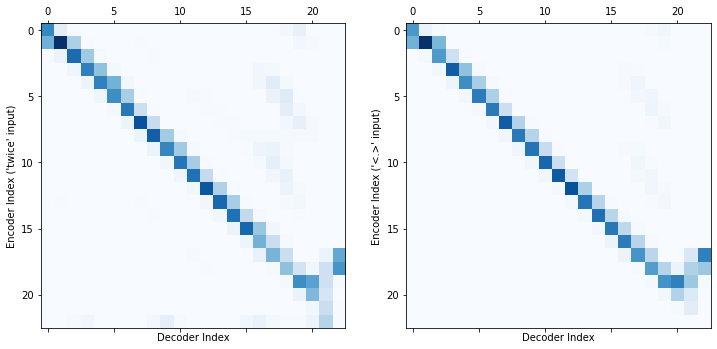

In [ ]:
# Encoder to compare
words = ['twice', '<.>'] #['<.>', 'left']

# Decoder to compare to
dec_seq_word = '<avg>'

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

if dec_seq_word == '<avg>': # Calculates and compares to average decoder sequence
  dec_seq = np.zeros((hs['all'][0].shape))
  for time_idx in range(hs['all'][0].shape[0]):
    time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
    dec_seq[time_idx] = np.mean(time_hs, axis=0)
else:
  dec_seq =  hs['special'][toy_params['out_words'].index(dec_seq_word)]
  
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for word, ax in zip(words, axs):
  # Attention matrix from mean input states
  # attn_matrix = np.zeros((enc_len, dec_len))
  # print('Word index:', toy_params['in_words'].index(word))
  # # Encoder sequence from chosen special word
  # enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :] 
  # for seq_idx in range(dec_len):
  #   attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, dec_seq[enc_len + seq_idx, :]))

  attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  for h_idx in range(len(hs['all'])):
    enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :]
    for seq_idx in range(dec_len):
      attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx]))

  attn_matrix = np.mean(attn_matrix, axis=0)

  ax.matshow(attn_matrix, cmap=plt.cm.Blues)
  ax.set_ylabel(f'Encoder Index (\'{word}\' input)')
  ax.set_xlabel('Decoder Index')

ValueError: ignored

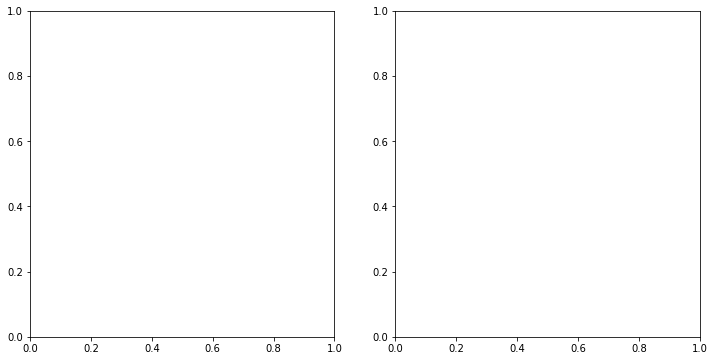

In [ ]:
# Encoder to compare
enc_seq_words = ['exercise', 'exercise'] 

# Decoder to compare to
dec_seq_words = ['I_EXER1', 'I_EXER2']

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# if enc_seq_word == '<avg>': # Calculates and compares to average decoder sequence
#   enc_seq = np.zeros((hs['all'][0].shape))
#   for time_idx in range(hs['all'][0].shape[0]):
#     time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
#     enc_seq[time_idx] = np.mean(time_hs, axis=0)
# else:
#   enc_seq =  hs['special'][toy_params['in_words'].index(enc_seq_word)]
  
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for enc_word, dec_word, ax in zip(enc_seq_words, dec_seq_words, axs):
  # Attention matrix from mean input states
  # attn_matrix = np.zeros((enc_len, dec_len))
  # print('Word index:', toy_params['in_words'].index(word))
  # # Encoder sequence from chosen special word
  # enc_seq = hs['special'][toy_params['in_words'].index(word)][:enc_len, :] 
  # for seq_idx in range(dec_len):
  #   attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, dec_seq[enc_len + seq_idx, :]))

  # attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  # dec_seq = avg_hs_word_dec[toy_params['out_words'].index(word), :, :]
  # for h_idx in range(len(hs['all'])):
  #   enc_seq = hs['all'][h_idx][:enc_len]
  #   for seq_idx in range(enc_len):
  #     attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(word), seq_idx, :]))

  # attn_matrix = np.mean(attn_matrix, axis=0)

  attn_matrix = np.zeros((enc_len, dec_len))
  enc_seq = avg_hs_word_dec[toy_params['in_words'].index(enc_word), :, :]
  for seq_idx in range(enc_len):
    attn_matrix[:, seq_idx] = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(dec_word), seq_idx, :]))

  # attn_matrix = 

  ax.matshow(attn_matrix, cmap=plt.cm.Blues)
  ax.set_ylabel(f'Encoder Index (\'{enc_word}\' input)')
  ax.set_xlabel(f'Decoder Index (\'{dec_word}\' input)')

[Text(0, 0, 'run'),
 Text(0, 0, 'walk'),
 Text(0, 0, 'exercise'),
 Text(0, 0, 'left'),
 Text(0, 0, '<.>'),
 Text(0, 0, '<pad>')]

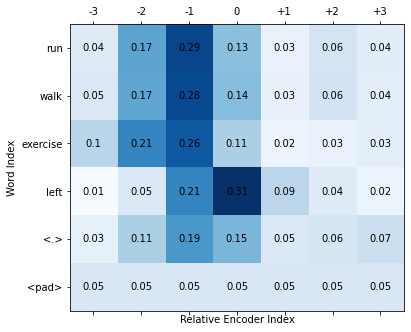

In [ ]:
look_dist = 3 # How many squares to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dec_seq = np.zeros((hs['all'][0].shape))
for time_idx in range(hs['all'][0].shape[0]):
  time_hs = np.asarray([hs['all'][i][time_idx] for i in range(len(hs['all']))])
  dec_seq[time_idx] = np.mean(time_hs, axis=0)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))
relative_aligns = np.zeros((len(toy_params['in_words_pp']), 2*look_dist + 1))

for word_idx in range(len(toy_params['in_words_pp'])):
  # Finds the average attention matrix
  attn_matrix = np.zeros((len(hs['all']), enc_len, dec_len))
  for h_idx in range(len(hs['all'])):
    enc_seq = hs['special'][word_idx][:enc_len, :]
    for seq_idx in range(dec_len):
      attn_matrix[h_idx, :, seq_idx] = softmax(np.dot(enc_seq, hs['all'][h_idx][enc_len + seq_idx]))

  attn_matrix = np.mean(attn_matrix, axis=0)

  relative_aligns_word = np.zeros((dec_len-2*look_dist, 2*look_dist + 1))
  for dec_idx in range(look_dist, min_len-look_dist): # Each decoder location for a given look_dist
    relative_aligns_word[dec_idx - look_dist] = attn_matrix[dec_idx - look_dist:dec_idx + look_dist + 1, dec_idx]

  relative_aligns[word_idx] = np.mean(relative_aligns_word , axis=0)

ax1.matshow(relative_aligns, cmap=plt.cm.Blues)
ax1.set_ylabel('Word Index')
ax1.set_xlabel('Relative Encoder Index')

for i in range(relative_aligns.shape[1]):
  for j in range(relative_aligns.shape[0]):
    c = relative_aligns[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(len(toy_params['in_words_pp']))])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels(toy_params['in_words_pp'], rotation=0)

Using minimum sequence length of: 18


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

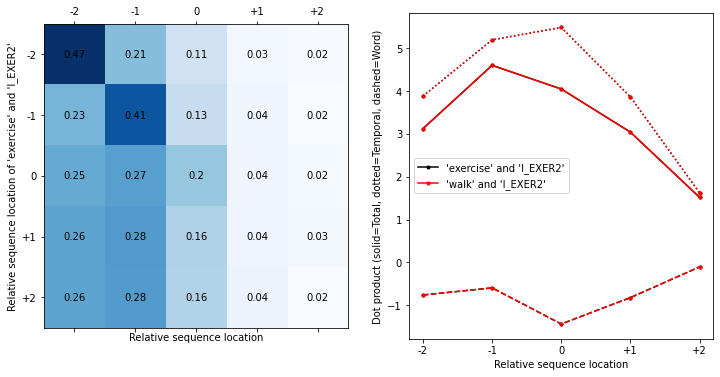

In [ ]:
# Sees if a word in the decoder latches onto particular other words as a function of distance.
# Uses the average states to compute said latching.

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['exercise', 'I_EXER2'] # Input-Output pair to test
other_in_words = ['walk', 'run', '<.>']

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]


      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

# Decomposes dot product of latch words into temporal and word components
latch_dot = np.zeros((2*look_dist+1, min_len-2*look_dist, 2))
non_latch_dot = np.zeros((2*look_dist+1, min_len-2*look_dist, 2))
for os_idx in range(2*look_dist+1):
  offset = os_idx - look_dist
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = seq_idx + offset # Location of latch word in input
    dec_loc = seq_idx # Location of latch word in output
    enc_hs_word = avg_hs_word_dec[toy_params['in_words'].index(latch_words[0]), enc_loc] - avg_hs[enc_loc]
    dec_hs_word = avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc] - avg_hs[dec_loc + enc_len]

    enc_hs_nl_word = avg_hs_word_dec[toy_params['in_words'].index(other_in_words[0]), enc_loc] - avg_hs[enc_loc]

    latch_dot[os_idx, seq_idx, 0] = np.dot(avg_hs[enc_loc], avg_hs[dec_loc + enc_len])
    latch_dot[os_idx, seq_idx, 1] = np.dot(enc_hs_word, dec_hs_word)
    non_latch_dot[os_idx, seq_idx, 0] = np.dot(avg_hs[enc_loc], avg_hs[dec_loc + enc_len])
    non_latch_dot[os_idx, seq_idx, 1] = np.dot(enc_hs_nl_word, dec_hs_word)
# Averages over sequence location
latch_dot = np.mean(latch_dot, axis=1)
non_latch_dot = np.mean(non_latch_dot, axis=1) 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 0] + latch_dot[:, 1], color='k', 
         marker='.', linestyle='solid', label=f'\'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 0], color='k', marker='.',
         linestyle='dotted')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], latch_dot[:, 1], color='k', marker='.',
         linestyle='dashed')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 0] + non_latch_dot[:, 1], color='r', 
         marker='.', linestyle='solid', label=f'\'{other_in_words[0]}\' and \'{latch_words[1]}\'')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 0], color='r', marker='.',
         linestyle='dotted')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], non_latch_dot[:, 1], color='r', marker='.',
         linestyle='dashed')
ax2.set_ylabel(f'Dot product (solid=Total, dotted=Temporal, dashed=Word)')
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

(34, 256)


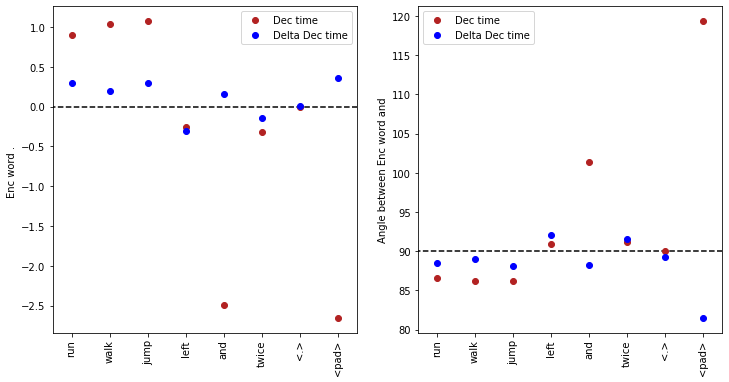

In [47]:
# Checks the dot product of the encoder word subspace with the decoder time subspace. 
# This has shown up in multiple modifier words as a way of lowering the overall dot product.
def angle_degrees(a, b):
  return 180/np.pi * np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

pad_dist = 2 
# temporal_hs = avg_hs
temporal_hs = hs['special'][-1]
delta_temporal = [temporal_hs[i+1] - temporal_hs[i] for i in range(temporal_hs.shape[0]-1)]

print(avg_hs.shape)

avg_word_dots = np.zeros((len(toy_params['in_words_pp']), 2))
avg_word_angles = np.zeros((len(toy_params['in_words_pp']), 2))

for word_idx in range(len(toy_params['in_words_pp'])):
  word_dots = []
  delta_word_dots = []
  word_angles = []
  delta_word_angles = []
  for seq_idx in range(np.min((enc_len, dec_len))):
    if not np.all(avg_hs_word_enc[word_idx][seq_idx] == np.zeros(rnn_specs['hidden_size'])): # Makes sure average is not zeros
      word_enc = avg_hs_word_enc[word_idx][seq_idx] - temporal_hs[seq_idx]
      word_dots.append(np.dot(temporal_hs[enc_len+seq_idx], word_enc))
      word_angles.append(angle_degrees(temporal_hs[enc_len+seq_idx], word_enc))
      if seq_idx < np.min((enc_len, dec_len)) - 1:
        delta_word_dots.append(np.dot(delta_temporal[enc_len+seq_idx], word_enc))
        delta_word_angles.append(angle_degrees(delta_temporal[enc_len+seq_idx], word_enc))

  avg_word_dots[word_idx, 0] = np.mean(np.asarray(word_dots), axis=0)
  avg_word_angles[word_idx, 0] = np.mean(np.asarray(word_angles), axis=0)
  avg_word_dots[word_idx, 1] = np.mean(np.asarray(delta_word_dots), axis=0)
  avg_word_angles[word_idx, 1] = np.mean(np.asarray(delta_word_angles), axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 0], marker='o', color='firebrick', linewidth=0, label='Dec time')
ax1.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_dots[:, 1], marker='o', color='blue', linewidth=0, label='Delta Dec time')
ax1.set_ylabel('Enc word . ')
ax1.hlines(0.0, -1, len(toy_params['in_words_pp'])+1, linestyles='dashed', color='k')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 0], marker='o', color='firebrick', linewidth=0, label='Dec time')
ax2.plot([i for i in range(len(toy_params['in_words_pp']))], avg_word_angles[:, 1], marker='o', color='blue', linewidth=0, label='Delta Dec time')
ax2.set_ylabel('Angle between Enc word and')
ax2.hlines(90.0, -1, len(toy_params['in_words_pp'])+1, linestyles='dashed', color='k')

for ax in [ax1, ax2]:
  ax.set_xlim([-0.5, len(toy_params['in_words_pp'])-0.5])
  ax.set_xticks([i for i in range(len(toy_params['in_words_pp']))])
  ax.set_xticklabels(toy_params['in_words_pp'], rotation=90)
  ax.legend()

#### 'Twice' Analysis

Using minimum sequence length of: 23


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

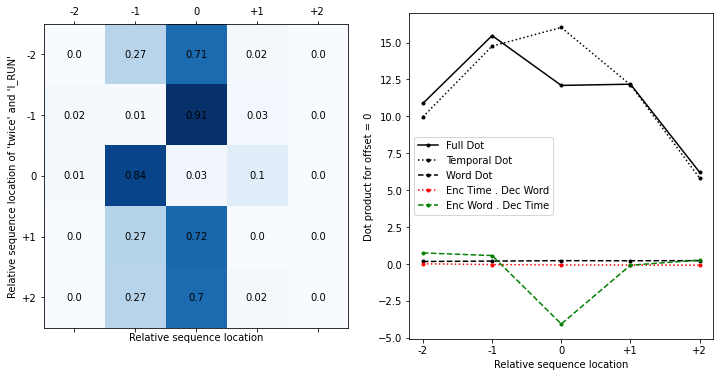

In [ ]:
look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['run', 'I_RUN'] # Input-Output pair to test
other_in_words = ['walk', 'jump', '<.>']

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))
    base = avg_hs_word_enc[toy_params['in_words'].index(other_in_words[0])]

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

      # print((base == enc_seq)[:, :2])

      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))
      # print(soft_max_vals)
      # print(soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1])
      # print(dfsdfsd)

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

dot_vals = np.zeros((len(other_in_words), 2*look_dist+1, 5))

for word_idx in range(len(other_in_words)):
  dot_vals_seq = np.zeros((min_len-2*look_dist, 2*look_dist+1, 5))
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = look_dist + seq_idx # Location of latch word in input
    dec_loc = look_dist + seq_idx # Location of latch word in output

    enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
    # Makes sequence index the latch word
    enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

    # print((base == enc_seq)[:, :2])

    dot_vals_seq[seq_idx, :, 0] = np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 1] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 2] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 3] = np.dot(avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 4] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

  dot_vals[word_idx] = np.mean(dot_vals_seq, axis=0)
# Averages over all other words:
dot_vals = np.mean(dot_vals, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\'')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,0], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,1], color='k', 
         marker='.', linestyle='dotted', label='Temporal Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,2], color='k', 
         marker='.', linestyle='dashed', label='Word Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,3], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Word')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,4], color='g', 
         marker='.', linestyle='dashed', label='Enc Word . Dec Time')
ax2.set_ylabel(f'Dot product for offset = 0')
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

In [ ]:
# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder
context_word = 'twice'
other_words = ['run', 'walk', 'left']

cw_idx = toy_params['in_words'].index(context_word)
ow_idxs = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      hs_inputs_context[ow_idxs.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

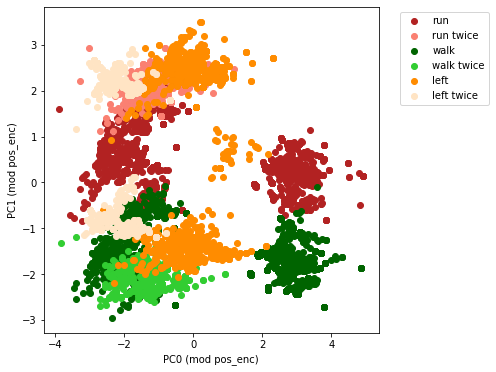

In [ ]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_word[inp_idx])).T
  ax1.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[ow_idxs.index(inp_idx)])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

#### "Exercise' Analysis

In [ ]:
# Decoposes a word's dot product into the different components, uses the average hidden states for a 
# given word to do the calculation.

from scipy.special import softmax

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

latch_words = ['exercise', 'I_EXER2'] # Input-Output pair to test
other_in_words = ['<.>',]

align_vals = np.zeros((len(other_in_words), 2*look_dist+1, 2*look_dist+1))

for word_idx in range(len(other_in_words)):
  for os_idx in range(2*look_dist+1):
    offset = os_idx - look_dist
    align_vals_offset = np.zeros((min_len-2*look_dist, 2*look_dist+1))
    base = avg_hs_word_enc[toy_params['in_words'].index(other_in_words[0])]

    for seq_idx in range(min_len-2*look_dist):
      enc_loc = look_dist + seq_idx + offset # Location of latch word in input
      dec_loc = look_dist + seq_idx # Location of latch word in output

      # print('Enc loc', enc_loc)
      # Fills encoder sequence with other word
      enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
      # Makes sequence index the latch word
      enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

      # print((base == enc_seq)[:, :2])

      soft_max_vals = softmax(np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :]))
      # print(soft_max_vals)
      # print(soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1])
      # print(dfsdfsd)

      align_vals_offset[seq_idx, :] = soft_max_vals[dec_loc-look_dist:dec_loc+look_dist+1]

    align_vals[word_idx, os_idx] = np.mean(align_vals_offset, axis=0)
# Averages over all other words:
align_vals = np.mean(align_vals, axis=0)

dot_vals = np.zeros((len(other_in_words), 2*look_dist+1, 5))

offset = -1 # Negative means encoder location is before decoder locat

for word_idx in range(len(other_in_words)):
  dot_vals_seq = np.zeros((min_len-2*look_dist, 2*look_dist+1, 5))
  for seq_idx in range(min_len-2*look_dist):
    enc_loc = look_dist + seq_idx + offset # Location of latch word in input
    dec_loc = look_dist + seq_idx # Location of latch word in output

    enc_seq = np.copy(avg_hs_word_enc[toy_params['in_words'].index(other_in_words[word_idx])])
    # Makes sequence index the latch word
    enc_seq[enc_loc, :] = avg_hs_word_enc[toy_params['in_words'].index(latch_words[0]), enc_loc, :]

    # print((base == enc_seq)[:, :2])

    dot_vals_seq[seq_idx, :, 0] = np.dot(enc_seq, avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 1] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 2] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 3] = np.dot(avg_hs[:enc_len], avg_hs_word_dec[toy_params['out_words'].index(latch_words[1]), dec_loc, :] - avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]
    dot_vals_seq[seq_idx, :, 4] = np.dot(enc_seq - avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

  dot_vals[word_idx] = np.mean(dot_vals_seq, axis=0)
# Averages over all other words:
dot_vals = np.mean(dot_vals, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.matshow(align_vals, cmap=plt.cm.Blues)
ax1.set_ylabel(f'Relative sequence location of \'{latch_words[0]}\' and \'{latch_words[1]}\' (enc-dec)')
ax1.set_xlabel('Relative sequence location')

ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,0], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,1], color='k', 
         marker='.', linestyle='dotted', label='Temporal Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,2], color='k', 
         marker='.', linestyle='dashed', label='Word Dot')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,3], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Word')
ax2.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[:,4], color='g', 
         marker='.', linestyle='dashed', label='Enc Word . Dec Time')
ax2.set_ylabel('Dot product for offset = ' + str(offset))
ax2.set_xlabel('Relative sequence location')
ax2.legend()

for i in range(align_vals.shape[1]):
  for j in range(align_vals.shape[0]):
    c = align_vals[j,i]
    ax1.text(i, j, str(round(c, 2)), va='center', ha='center')

ax1.set_xticks([j for j in range(2*look_dist + 1)])
ax1.set_yticks([j for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)
ax1.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax2.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

Using minimum sequence length of: 17


NameError: ignored

In [56]:
latch_words = ['left', 'I_TURN_LEFT'] # Input-Output pair to test
# latch_words = ['walk', 'I_WALK'] # Input-Output pair to test
latch_idx = [toy_params['in_words'].index(latch_words[0]), toy_params['out_words'].index(latch_words[1])]

dot_vals = []

offset = 1

for h_idx in range(10,20):

  in_idx = hs_data['in_index'][h_idx]
  out_idx = hs_data['out_index'][h_idx]
  min_len = np.min([in_idx, out_idx])

  enc_phrase = hs['all'][h_idx][:min_len+1]
  dec_phrase = hs['all'][h_idx][enc_len:enc_len+min_len+1]
  in_latch_locs = np.argmax(hs_data['inputs'][h_idx][:min_len+1], axis=1) == latch_idx[0]
  out_latch_locs = np.argmax(hs_data['labels'][h_idx][:min_len+1], axis=1) == latch_idx[1]

  print('Inputs:', in_latch_locs)
  print('Outputs:', out_latch_locs)

  # Finds locations in phrase where latches have the given offset
  if offset == 0: # No shift to input phrase
    locs = np.logical_and(in_latch_locs, out_latch_locs)
  elif offset > 0: # Shifts input phrase upwards
    locs = np.logical_and(in_latch_locs[offset:], out_latch_locs[:-offset]) 
  else: # Shifts input phrase backwards
    locs = np.logical_and(in_latch_locs[:offset], out_latch_locs[-offset:])

  # Finds all valid locations, eliminating idxs that are within look_dist of start or end of phrase
  if offset >= 0:
    latch_locs = [i for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 
  else: # Need to add offset since started at idx=offset when comparing
    latch_locs = [i - offset for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 

  print('Latch locations:', latch_locs)

  # Calculates aligns
  aligns = np.dot(dec_phrase, enc_phrase.T)

  for latch_loc in latch_locs:
    dot_vals.append(aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1])

print(np.asarray(dot_vals).shape)
print(np.mean(np.asarray(dot_vals), axis=0))

Inputs: [False False False False False False  True False False False False False
 False False  True]
Outputs: [False False False False  True False False False False False False  True
 False False False]
Latch locations: []
Inputs: [False False False  True False False False False False False False]
Outputs: [False  True False False False False False False False False False]
Latch locations: []
Inputs: [False  True False False  True False False False False False False]
Outputs: [ True False  True False False False False False False False False]
Latch locations: []
Inputs: [False False False False False False False False False False False False
  True False False]
Outputs: [False False False False False False False False False  True False  True
 False False False]
Latch locations: [11]
Inputs: [False False False False False False  True False False False False False
  True False]
Outputs: [False False False False  True False False False False  True False False
 False False]
Latch locations

Finding average hidden state at each time step...
Searching for: 
 ['<any>', 'walk', '<any>', '<any>', '<any>'] 
 ['<any>', '<any>', 'I_WALK', '<any>', '<any>']
Averaging over 55 latch locations
Dot val shape: (5, 55, 5)
Dot val mean shape: [[ 4.62883703 10.05643037  9.1073598   8.74805093  8.34689343]
 [ 4.31406061  7.94847581  9.96994869 10.3867229   8.53859473]
 [-0.07367989 -0.17109148 -0.51271662  0.07347853 -0.07540576]
 [ 0.23548576  0.2548165   0.20743077  0.09738187  0.04335328]
 [ 0.15297081  2.02422933 -0.55730299 -1.80953311 -0.15964868]]


[Text(0, 0, '-2'),
 Text(0, 0, '-1'),
 Text(0, 0, '0'),
 Text(0, 0, '+1'),
 Text(0, 0, '+2')]

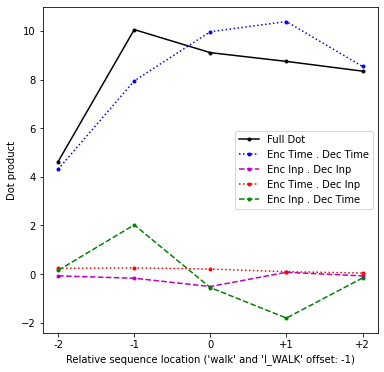

In [65]:
# Same as the decomposition above, but searches the test phrases for the desired latch alignment.

from scipy.special import softmax

index_filter = True
idx_filter_val = 5

avg_hs = find_avg_hs(hs, hs_data, toy_params)

look_dist = 2 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]

# offset is encoder location - decoder location
# latch_words, offset = ['left', 'I_TURN_LEFT'], 1 # Input-Output pair to test
latch_words, offset = ['walk', 'I_WALK'], -1 # Input-Output pair to test
# latch_words, offset = ['I0', 'O0'], 0 # Input-Output pair to test
# latch_words, offset= ['and', 'I_RUN'], 0 # Input-Output pair to test
# latch_words, offset= ['twice', 'I_RUN'], 0 # Input-Output pair to test
# latch_words = ['exercise', 'I_EXER2'], 1 # Input-Output pair to test
# latch_words, offset = ['<.>', '<.>'], 0 # Input-Output pair to test
# latch_words, offset = ['run', 'I_RUN'], 1 # Input-Output pair to test

latch_idx = [toy_params['in_words'].index(latch_words[0]), toy_params['out_words'].index(latch_words[1])]

dot_vals = [[] for _ in range(5)] # total, and 4 different parts

enc_template, dec_template = ['<any>' for _ in range(2*look_dist+1)], ['<any>' for _ in range(2*look_dist+1)]
enc_template[look_dist+offset] = latch_words[0]
dec_template[look_dist] = latch_words[1]
print('Searching for: \n', enc_template, '\n', dec_template)

for h, inp, out, in_idx, out_idx in zip(hs['all'], hs_data['inputs'], hs_data['labels'], hs_data['in_index'], hs_data['out_index']):
  min_len = np.min([in_idx, out_idx])

  enc_phrase = h[:min_len+1]
  dec_phrase = h[enc_len:enc_len+min_len+1]
  in_latch_locs = np.argmax(inp[:min_len+1], axis=1) == latch_idx[0]
  out_latch_locs = np.argmax(out[:min_len+1], axis=1) == latch_idx[1]

  # Finds locations in phrase where latches have the given offset
  if offset == 0: # No shift to input phrase
    locs = np.logical_and(in_latch_locs, out_latch_locs)
  elif offset > 0: # Shifts input phrase upwards
    locs = np.logical_and(in_latch_locs[offset:], out_latch_locs[:-offset])
  else: # Shifts input phrase backwards
    locs = np.logical_and(in_latch_locs[:offset], out_latch_locs[-offset:])

    # Finds all valid locations, eliminating idxs that are within look_dist of start or end of phrase
  if offset >= 0:
    latch_locs = [i for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 
  else: # Need to add offset since started at idx=offset when comparing
    latch_locs = [i - offset for i, x in enumerate(locs) if x and i >= look_dist and i <= min_len-look_dist] 

  # Filters out additional indexes above idx_filter_val (useful for looking only at earlier part of phrase)
  if index_filter:
    latch_locs = [i for i in latch_locs if i <= idx_filter_val] 

  # Calculates aligns and adds appropriate aligns to dot_vals
  enc_avg = avg_hs[:min_len+1]
  dec_avg = avg_hs[enc_len:enc_len+min_len+1]

  aligns = np.zeros((dec_phrase.shape[0], enc_phrase.shape[0], 5))
  aligns[:, :, 0] = np.dot(dec_phrase, enc_phrase.T)
  aligns[:, :, 1] = np.dot(dec_avg, enc_avg.T) # time dot
  aligns[:, :, 2] = np.dot(dec_phrase - dec_avg, enc_phrase.T - enc_avg.T) # input dot
  aligns[:, :, 3] = np.dot(dec_phrase - dec_avg, enc_avg.T) # inp . avg
  aligns[:, :, 4] = np.dot(dec_avg, enc_phrase.T - enc_avg.T) # avg . inp

  for latch_loc in latch_locs:
    for dot_idx in range(5):
      dot_vals[dot_idx].append(aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1, dot_idx])
      if aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1, dot_idx].shape != (5,):
        print('Different shape found')
      # print(aligns[latch_loc, latch_loc-look_dist:latch_loc+look_dist+1, dot_idx].shape)

if len(dot_vals[0]) == 0: raise ValueError('No Latch Locations Found!')
print(f'Averaging over {len(dot_vals[0])} latch locations')
print('Dot val shape:', np.array(dot_vals).shape)
print('Dot val mean shape:', np.mean(np.asarray(dot_vals), axis=1))
dot_vals = np.mean(np.array(dot_vals), axis=1)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 6))

ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[0,:], color='k', 
         marker='.', linestyle='solid', label='Full Dot')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[1,:], color='b', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Time')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[2,:], color='m', 
         marker='.', linestyle='dashed', label='Enc Inp . Dec Inp')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[3,:], color='r', 
         marker='.', linestyle='dotted', label='Enc Time . Dec Inp')
ax1.plot([j - look_dist for j in range(2*look_dist + 1)], dot_vals[4,:], color='g', 
         marker='.', linestyle='dashed', label='Enc Inp . Dec Time')
ax1.set_ylabel('Dot product')
ax1.set_xlabel(f'Relative sequence location (\'{latch_words[0]}\' and \'{latch_words[1]}\' offset: {offset})')
ax1.legend()

ax1.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

In [ ]:
# Calculates average hidden state and subtracts it out from hidden states at all time steps to isolate word subspace
# Average hidden state does NOT include repeated <pad>'s for encoder or decoder
context_word = '<.>'
other_words = ['run', 'walk', 'exercise']

cw_idx = toy_params['in_words'].index(context_word)
ow_idxs = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      if last_inp_idx in ow_idxs:
        hs_inputs_context[ow_idxs.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

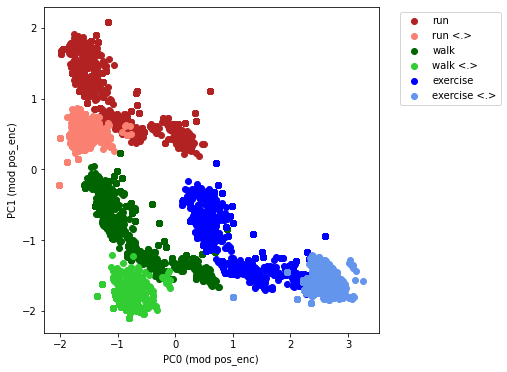

In [ ]:
# Plots decomposition of hidden states into temporal and word spaces
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_word = pca_mod_pe.transform(np.vstack(hs_word[inp_idx])).T
  ax1.scatter(pca_mod_pe_word[pc1], pca_mod_pe_word[pc2], color=state_colors[inp_idx], label=toy_params['in_words'][inp_idx])
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

In [ ]:
# This does the same thing as an above cell, but simply saves the context hidden states as something else. Used for plotting all distinct phrases below
context_word2 = 'left'
other_words = ['run', 'walk', 'exercise']

cw_idx = toy_params['in_words'].index(context_word2)
ow_idxs2 = [toy_params['in_words'].index(word) for word in other_words]

avg_hs = np.zeros((hs['all'][0].shape))
pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 
enc_len = hs_data['inputs'][0].shape[0]
dec_len = toy_params['phrase_length']

for time_idx in range(hs['all'][0].shape[0]):
  if time_idx < enc_len: # Encoder
    time_hs = []
    for h, inp in zip(hs['all'], hs_data['inputs']):
      if time_idx > 0:
        if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  else: # Decoder
    time_hs = []
    for h, out in zip(hs['all'], hs_data['labels']):
      if time_idx - enc_len> 0:
        if np.argmax(out[time_idx-enc_len]) != pad_out_idx or np.argmax(out[time_idx-enc_len-1]) != pad_out_idx:
          time_hs.append(h[time_idx])
      else: # Automatically adds if first index
        time_hs.append(h[time_idx])
    time_hs = np.asarray(time_hs)
  if time_hs.shape[0] > 0:
    avg_hs[time_idx] = np.mean(time_hs, axis=0)
  else:
    print('Zero length')

# Removes average hidden state from all hidden states
hs_mod_pos_enc = [h - avg_hs for h in hs['all']]

hs_word = [[] for _ in range(len(toy_params['in_words_pp']))]
hs_inputs_context2 = [[] for _ in range(len(other_words))]

pad_in_idx = toy_params['in_words'].index('<pad>')
pad_out_idx = toy_params['out_words'].index('<pad>') 

for time_idx in range(enc_len): # Encoder
  for h_mpe, inp in zip(hs_mod_pos_enc, hs_data['inputs']):
    if time_idx > 0:
      if np.argmax(inp[time_idx]) != pad_in_idx or np.argmax(inp[time_idx-1]) != pad_in_idx: # Does not add repeated <pads>
        hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    else: # Automatically adds if first index
      hs_word[np.argmax(inp[time_idx])].append(h_mpe[time_idx])
    if np.argmax(inp[time_idx]) == cw_idx and time_idx > 0:
      last_inp = inp[time_idx-1]
      last_inp_idx = np.argmax(last_inp)
      if last_inp_idx in ow_idxs2:
        hs_inputs_context2[ow_idxs2.index(last_inp_idx)].append(h_mpe[time_idx])

print('Done')

Done


Text(0, 0.5, 'PC1 (mod pos_enc)')

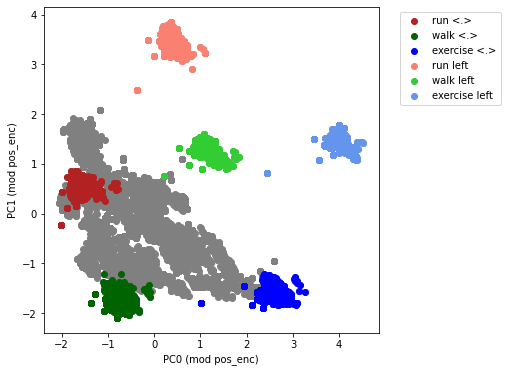

In [ ]:
# Used to plot multiple sets of context words
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 6))

##### Plotting for word part #####

pts_subset = 'enc'

pc1 = 0
pc2 = 1

pca_mod_pe = PCA(n_components=rnn_specs['hidden_size'])

_ = pca_mod_pe.fit(np.vstack(np.asarray(hs_mod_pos_enc)[:,:enc_len,:]))
pca_mod_pe_hs = pca_mod_pe.transform(np.vstack(hs_mod_pos_enc)).T

ax1.scatter(pca_mod_pe_hs[pc1], pca_mod_pe_hs[pc2], color='grey')

pca_hs = pca_mod_pe.transform(np.vstack(hs['all'])).T
for inp_idx in ow_idxs:
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word)
  
for inp_idx in ow_idxs2:
  pca_mod_pe_cword = pca_mod_pe.transform(np.vstack(hs_inputs_context2[inp_idx])).T
  ax1.scatter(pca_mod_pe_cword[pc1], pca_mod_pe_cword[pc2], color=state_colors_light[inp_idx], 
              label=toy_params['in_words'][inp_idx] + ' ' + context_word2)

# Plots readout direction
# readout_types = ['att']  #'att', 'hs', 'sum'] # 'att' or 'hs'
# ro_styles = ['solid', 'dotted', 'dashed']
# for idx in range(len(readout_types)):
#   if readout_types[idx] == 'att':
#     readout_plot = readout 
#     # readout_plot = readout - np.outer(np.dot(readout, avg_enc_dir), avg_enc_dir)
#   elif readout_types[idx] == 'hs':
#     readout_plot = readout_dec
#     # readout_plot = readout_dec - np.outer(np.dot(readout_dec, avg_dec_dir), avg_dec_dir)
#   elif readout_types[idx] == 'sum':
#     readout_plot = readout + readout_dec
#   pca_ro = pca_avg.transform(readout_plot)
#   pca_zero = pca_avg.transform(np.atleast_2d(np.zeros((rnn_specs['hidden_size'],)))).T
#   for i in range(readout_plot.shape[0]):
#     x_ro = [pca_zero[pc1], pca_ro[i][pc1]]
#     y_ro = [pca_zero[pc2], pca_ro[i][pc2]]
#     ax1.plot(x_ro, y_ro, color=state_colors[i], linewidth = 3, linestyle=ro_styles[idx],
#               label=f'RO ({readout_types[idx]}): '+toy_params['out_words'][i])

ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax1.set_xlabel('PC'+str(pc1)+' (mod pos_enc)')
ax1.set_ylabel('PC'+str(pc2)+' (mod pos_enc)')

#### Many to One Analysis

Finding average hidden state at each time step...
Using minimum sequence length of: 15
Average offset [0.         0.         0.269      0.89       0.905      0.946
 1.016      1.185      1.545      1.81       1.866      1.97267206
 2.17268041 2.53157122 2.94       2.99180328 3.00769231        nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


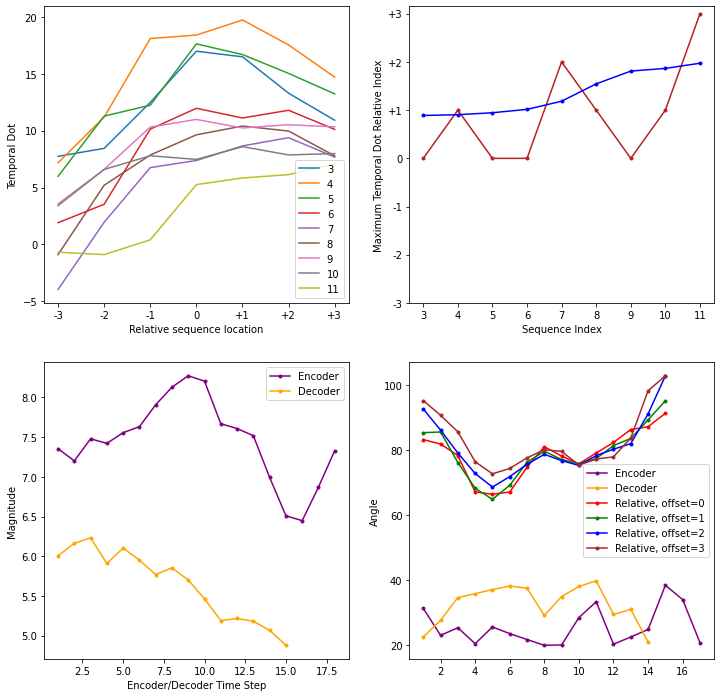

In [107]:
from scipy.special import softmax

avg_hs = find_avg_hs(hs, hs_data, toy_params)

look_dist = 3 # How many time-steps to look ahead/behind
enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])
print('Using minimum sequence length of:', min_len)

dot_vals = np.zeros((min_len-2*look_dist, 2*look_dist+1))

offset = 0 # Negative means encoder location is before decoder locat

for seq_idx in range(min_len-2*look_dist):
  enc_loc = look_dist + seq_idx + offset # Location of latch word in input
  dec_loc = look_dist + seq_idx # Location of latch word in output

  dot_vals[seq_idx, :] = np.dot(avg_hs[:enc_len], avg_hs[dec_loc+enc_len])[dec_loc-look_dist:dec_loc+look_dist+1]

# Finds the average offset of each index
displacements = np.zeros((len(hs_data['inputs']), hs_data['inputs'][0].shape[0]))
length_count = np.zeros((enc_len))
for idx, h_inp, in_idx in zip(range(len(hs_data['inputs'])), hs_data['inputs'], hs_data['in_index']):

  and_idx = toy_params['in_words'].index('and')
  and_locs = np.argmax(h_inp, axis=1) == and_idx
  length_count[:in_idx] += np.ones((in_idx))

  and_locs = [int(and_locs[i]) for i in range(and_locs.shape[0])]
  displacements[idx, :in_idx] = [np.sum(and_locs[:i]) for i in range(in_idx)]

displacements = np.sum(displacements, axis=0)
avg_offset = displacements/length_count
print('Average offset', avg_offset)

avg_hs_mags = np.array([np.linalg.norm(hs_time) for hs_time in avg_hs])
avg_hs_angles = np.array([angle_degrees(avg_hs[i], avg_hs[i+1]) for i in range(avg_hs.shape[0]-1)])
avg_hs_rel_angles = np.array([angle_degrees(avg_hs[i], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles1 = np.array([angle_degrees(avg_hs[i+1], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles2 = np.array([angle_degrees(avg_hs[i+2], avg_hs[enc_len+i]) for i in range(dec_len)])
avg_hs_rel_angles3 = np.array([angle_degrees(avg_hs[i+3], avg_hs[enc_len+i]) for i in range(dec_len)])

# for ld_idx in range(2*look+1):


fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))

for seq_idx in range(min_len-2*look_dist):
  ax1.plot([i - look_dist for i in range(2*look_dist+1)], dot_vals[seq_idx], label=str(seq_idx+look_dist))
ax1.set_ylabel('Temporal Dot')
ax1.set_xlabel('Relative sequence location')
ax1.legend()

max_dot_idx = np.argmax(dot_vals, axis=1)

ax2.plot([i+look_dist for i in range(min_len-2*look_dist)], max_dot_idx, color='firebrick', marker='.')
ax2.plot([i+look_dist for i in range(min_len-2*look_dist)], avg_offset[look_dist:min_len-look_dist]+look_dist, color='b', marker='.')

ax2.set_ylabel('Maximum Temporal Dot Relative Index')
ax2.set_xlabel('Sequence Index')

ax1.set_xticks([j-look_dist for j in range(2*look_dist + 1)])
ax1.set_xticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax2.set_yticks([j for j in range(2*look_dist + 1)])
ax2.set_yticklabels([str(i) if i < 1 else '+' + str(i) for i in range(-look_dist, look_dist+1) ], rotation=0)

ax3.plot([time_step+1 for time_step in range(enc_len)], avg_hs_mags[:enc_len], color='purple', marker='.', label='Encoder')
ax3.plot([time_step+1 for time_step in range(dec_len)], avg_hs_mags[enc_len:], color='orange', marker='.', label='Decoder')
ax3.set_xlabel('Encoder/Decoder Time Step')
ax3.set_ylabel('Magnitude')
ax3.legend()

ax4.plot([time_step+1 for time_step in range(enc_len-1)], avg_hs_angles[:enc_len-1], color='purple', marker='.', label='Encoder')
ax4.plot([time_step+1 for time_step in range(dec_len-1)], avg_hs_angles[enc_len:], color='orange', marker='.', label='Decoder')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles, color='red', marker='.', label='Relative, offset=0')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles1, color='green', marker='.', label='Relative, offset=1')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles2, color='blue', marker='.', label='Relative, offset=2')
ax4.plot([time_step+1 for time_step in range(dec_len)], avg_hs_rel_angles3, color='brown', marker='.', label='Relative, offset=3')
ax3.set_xlabel('Encoder/Decoder Time Step')
ax4.set_ylabel('Angle')
ax4.legend()

Finding average hidden state at each time step...


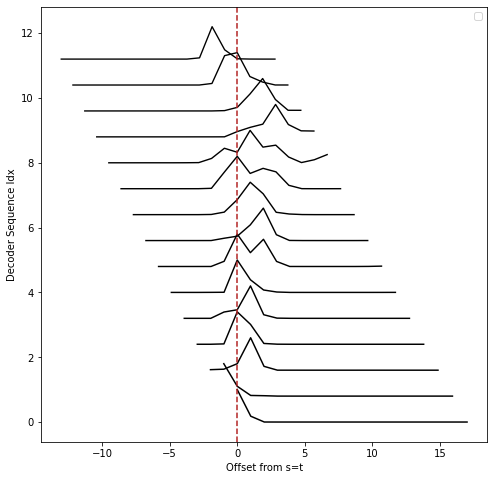

In [108]:
avg_hs = find_avg_hs(hs, hs_data, toy_params)

enc_len = hs_data['inputs'][0].shape[0]
dec_len = hs_data['labels'][0].shape[0]
min_len = np.min([enc_len, dec_len])

dot_vals = np.zeros((dec_len, enc_len))

for seq_idx in range(dec_len):
  raw_dots = softmax(np.dot(avg_hs[:enc_len], avg_hs[enc_len+seq_idx]))
  # Normalizes dot product between 0 and 1
  dot_vals[seq_idx, :] = (raw_dots - np.min(raw_dots))/(np.max(raw_dots)-np.min(raw_dots))

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# for seq_idx in range(dec_len):
#   ax1.plot([i-seq_idx for i in range(enc_len)], dot_vals[seq_idx], label=str(seq_idx+look_dist))

# Generate line plots
lines = []
for seq_idx in range(dec_len):
  # Small reduction of the X extents to get a cheap perspective effect
  xscale = 1 - seq_idx / 200.
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  line, = ax1.plot([xscale *(i-seq_idx) for i in range(enc_len)], 0.8*seq_idx + dot_vals[seq_idx], color='k', lw=lw)
  lines.append(line)

ax1.axvline(0.0, color='firebrick', linestyle='dashed')
ax1.set_ylabel('Decoder Sequence Idx')
ax1.set_xlabel('Offset from s=t')
ax1.legend()


In [ ]:
# Create new Figure with black background
fig = plt.figure(figsize=(8, 8), facecolor='black')

# Add a subplot with no frame
ax = plt.subplot(111, frameon=False)

# Generate random data
data = np.random.uniform(0, 1, (64, 75))
X = np.linspace(-1, 1, data.shape[-1])
G = 1.5 * np.exp(-4 * X ** 2)

# Generate line plots
lines = []
for i in range(len(data)):
    # Small reduction of the X extents to get a cheap perspective effect
    xscale = 1 - i / 200.
    # Same for linewidth (thicker strokes on bottom)
    lw = 1.5 - i / 100.0
    line, = ax.plot(xscale * X, i + G * data[i], color="w", lw=lw)
    lines.append(line)

# Set y limit (or first line is cropped because of thickness)
ax.set_ylim(-1, 70)

#### Positional Encoding and One-Hot Tests

Minimum angle: 66.83707147516884
Maximum angle: 115.14109578759171


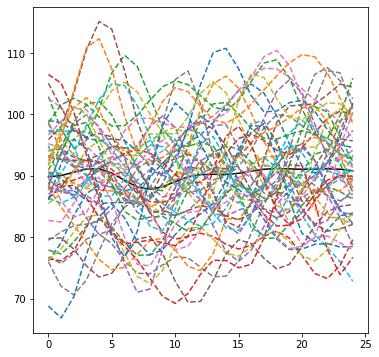

In [ ]:
seq_length_test = 25
word_dims = 50
test_seq = np.zeros((1, seq_length_test, word_dims))

pos_enc_params = {'pos_enc': True, 'time_scale': 100.0, 'amplitude': 1.0}

random_pos_enc_rot = rvs(word_dims)
# random_pos_enc_rot = np.identity(word_dims)  

pos_enc = positional_encoding(test_seq, scale=pos_enc_params['time_scale'], amp=pos_enc_params['amplitude'], 
                              rot=random_pos_enc_rot)

pe_vec = pos_enc[0]

dots = np.zeros((word_dims, seq_length_test)) 
for dim_idx in range(word_dims):
  one_hot_vec = np.zeros((word_dims))
  one_hot_vec[dim_idx] = 1.0
  for seq_idx in range(seq_length_test):
    dots[dim_idx, seq_idx] = 180/np.pi * np.arccos(np.dot(pe_vec[seq_idx], one_hot_vec)/(np.linalg.norm(pe_vec[seq_idx])*np.linalg.norm(one_hot_vec)))

avg_dots = np.mean(dots, axis=0)

print('Minimum angle:', np.min(dots))
print('Maximum angle:', np.max(dots))

fig, ax1 = plt.subplots(1, 1, figsize=(6,6))
ax1.plot([i for i in range(seq_length_test)], avg_dots, color='k', linestyle='solid')
for dim_idx in range(word_dims):
  ax1.plot([i for i in range(seq_length_test)], dots[dim_idx],  linestyle='dashed')

### Ensemble Plotting

In [89]:
# Loads many networks and computes accuracy
base_path = '/content/drive/My Drive/ml_research/fixedpoints_nlp/data_seq2seq/ao_andlefttwicescan_nolefttwice_5datasets_l2is1e-4.pickle'
dot_idx = base_path.index('.')
data_type = 'scan'
n_trials = 1000

trial_idxs = [1, 2, 6, 8, 9, 10, 11, 12, 13]

dot_vals = np.zeros((len(trial_idxs), dec_len, enc_len))

for trial_idx in range(len(trial_idxs)):
  new_path = base_path[:dot_idx] + '_' + str(trial_idxs[trial_idx]) + base_path[dot_idx:]
  with open(new_path, 'rb') as load_file:
    params_loaded = pickle.load(load_file)
    toy_params = pickle.load(load_file)
    rnn_specs = pickle.load(load_file)
    train_params = pickle.load(load_file)

  rnn_params, rnn_params_dec, readout_params = params_loaded
  final_params = params_loaded
  train_params, toy_params, rnn_specs = default_params(train_params, toy_params, rnn_specs)

  if trial_idx == 0: # Only generates new data on first run
    scan_data, _ = generate_scan(raw_in_phrases, raw_out_phrases, toy_params['scan_params'], trials=n_trials)
    hs_data =  {
      'inputs': scan_data['inputs'],
      'labels': scan_data['labels'],
      'in_index': scan_data['in_index'],
      'out_index': scan_data['out_index'],
    }

    enc_len = hs_data['inputs'][0].shape[0]
    dec_len = hs_data['labels'][0].shape[0]
    min_len = np.min([enc_len, dec_len])

  # Builds new apply and accuracy function
  _, apply_fun, _, _, accuracy_fun = build_rnn(rnn_specs)

  phrase_acc, word_acc = accuracy_fun(final_params, hs_data)
  print(f'Trial: {trial_idxs[trial_idx]},  Test Acc:', np.mean(phrase_acc), ', Word Acc:', np.mean(word_acc))

  # Gets raw hidden states
  hs['all'] = rnn_states(hs_data, final_params, rnn_specs)

  avg_hs = find_avg_hs(hs, hs_data, toy_params)

  for seq_idx in range(dec_len):
    raw_dots = np.dot(avg_hs[:enc_len], avg_hs[enc_len+seq_idx])
    # Normalizes dot product between 0 and 1
    dot_vals[trial_idx, seq_idx, :] = raw_dots


SCAN data generated in: 0.06 sec.
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 1,  Test Acc: 0.92200005 , Word Acc: 0.98253334
Finding average hidden state at each time step...
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 2,  Test Acc: 0.883 , Word Acc: 0.97333336
Finding average hidden state at each time step...
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 6,  Test Acc: 0.883 , Word Acc: 0.97966665
Finding average hidden state at each time step...
Adding pos_enc to encoder. \ Amp: 1.0 \ Time Scale: 100.0
Adding pos_enc to decoder. \ Amp: 1.0 \ Time Scale: 100.0
Zero context True
Trial: 8,  Test Acc: 0.90300006 , Word Acc: 0.97900003
Finding average hidden state at each time step...
Adding pos_enc to en

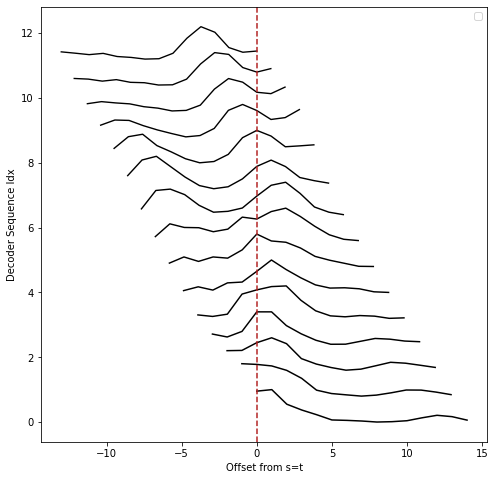

In [92]:
avg_dot_vals = np.mean(dot_vals, axis=0)
end_pad = 3
avg_softmax_vals = np.zeros((dec_len, enc_len - end_pad))

for seq_idx in range(dec_len):
  avg_softmax = softmax(avg_dot_vals[seq_idx,:-end_pad])
  # Normalizes dot product between 0 and 1
  avg_softmax_vals[seq_idx, :] = (avg_softmax - np.min(avg_softmax))/(np.max(avg_softmax)-np.min(avg_softmax))

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# Generate line plots
lines = []
for seq_idx in range(dec_len):
  # Small reduction of the X extents to get a cheap perspective effect
  xscale = 1 - seq_idx / 200.
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  line, = ax1.plot([xscale *(i-seq_idx) for i in range(enc_len- end_pad)], 0.8*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  lines.append(line)

ax1.axvline(0.0, color='firebrick', linestyle='dashed')
ax1.set_ylabel('Decoder Sequence Idx')
ax1.set_xlabel('Offset from s=t')
ax1.legend()

Average offset [0.         0.         0.325      0.905      0.918      0.947
 1.015      1.203      1.587      1.822      1.863      1.96352584
 2.17125    2.55804196 2.92385787 2.98670213 3.                nan]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide


Text(0.5, 0, 'Sequence Index')

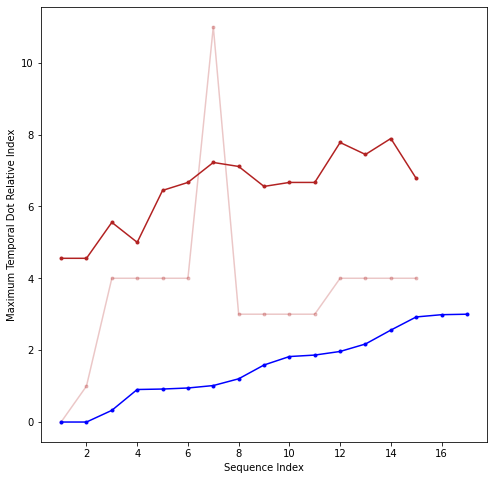

In [103]:
end_pad = 3
argmax_locs = np.mean(np.argmax(dot_vals[:, :, :-end_pad], axis=2), axis=0)

# Generate line plots
lines = []
for seq_idx in range(dec_len):
  # Small reduction of the X extents to get a cheap perspective effect
  xscale = 1 - seq_idx / 200.
  # Same for linewidth (thicker strokes on bottom)
  lw = 1.5 - seq_idx / 100.0
  line, = ax1.plot([xscale *(i-seq_idx) for i in range(enc_len- end_pad)], 0.8*seq_idx + avg_softmax_vals[seq_idx], color='k', lw=lw)
  lines.append(line)

# Finds the average offset of each index
displacements = np.zeros((len(hs_data['inputs']), hs_data['inputs'][0].shape[0]))
length_count = np.zeros((enc_len))
for idx, h_inp, in_idx in zip(range(len(hs_data['inputs'])), hs_data['inputs'], hs_data['in_index']):

  and_idx = toy_params['in_words'].index('and')
  and_locs = np.argmax(h_inp, axis=1) == and_idx
  length_count[:in_idx] += np.ones((in_idx))

  and_locs = [int(and_locs[i]) for i in range(and_locs.shape[0])]
  displacements[idx, :in_idx] = [np.sum(and_locs[:i]) for i in range(in_idx)]

displacements = np.sum(displacements, axis=0)
avg_offset = displacements/length_count
print('Average offset', avg_offset)

fig, ax1 = plt.subplots(1, 1, figsize=(8, 8))

# for trial_idx in range(len(trial_idxs)):
#   ax1.plot([i+1 for i in range(dec_len)], np.argmax(dot_vals[:, :, :-end_pad], axis=2)[trial_idx], color='firebrick', marker='.', alpha=0.25)
ax1.plot([i+1 for i in range(dec_len)], np.argmax(dot_vals[:, :, :-end_pad], axis=2)[3], color='firebrick', marker='.', alpha=0.25)

ax1.plot([i+1 for i in range(dec_len)], argmax_locs, color='firebrick', marker='.')
ax1.plot([i+1 for i in range(enc_len-1)], avg_offset[:-1], color='b', marker='.')

ax1.set_ylabel('Maximum Temporal Dot Relative Index')
ax1.set_xlabel('Sequence Index')